In [1]:
import tensorflow as tf
import keras
import numpy as np
import os
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import seaborn as sns

import scipy.stats as sc_stats

import random

from sklearn.model_selection import train_test_split


from mpl_toolkits.mplot3d import Axes3D
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf as acf
os.environ['KMP_DUPLICATE_LIB_OK']='True'



Using TensorFlow backend.


In [2]:
def add_releveant_features(task_df):


    task_df['PrevOutcome']=task_df['Outcome'].shift(1)
    task_df.loc[1,'PrevOutcome']= 0

    task_df['PrevChoice']=task_df['Choice'].shift(1)
    task_df.loc[1,'PrevChoice']= 0

    task_df['PrevSafe']=task_df['Safe'].shift(1)
    task_df.loc[1,'PrevSafe']= 0

    task_df['PrevBigRisky']=task_df['BigRisky'].shift(1)
    task_df.loc[1,'PrevBigRisky']= 0

    task_df['PrevSmallRisky']=task_df['SmallRisky'].shift(1)
    task_df.loc[1,'PrevSmallRisky']= 0
    
#     task_df['PrevRT']=task_df['RT'].shift(1)
#     task_df.loc[1,'PrevRT']= 0
    
    
    
    return task_df

In [3]:
def add_kback_features(task_df):

    for k in range(1,11):
        task_df[str(k)+'backOutcome']=task_df['Outcome'].shift(k)
        task_df[str(k)+'backChoice']=task_df['Choice'].shift(k)
        task_df[str(k)+'backSafe']=task_df['Safe'].shift(k)
        task_df[str(k)+'backBigRisky']=task_df['BigRisky'].shift(k)
        task_df[str(k)+'backSmallRisky']=task_df['SmallRisky'].shift(k)

    return task_df

In [4]:
dir_list = os.listdir("/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/")
dir_path ="/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/"

subj_files_list =[]; ## list of subject_files fullfilling a criteria

dir_files = [i for i in os.listdir(dir_path) if i.startswith('sub')]

for subj_file_path in dir_files:

    file_path  ="/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/"+ subj_file_path
    mypath =file_path
    
    play_names = [i for i in os.listdir(mypath) if os.path.isfile(os.path.join(mypath,i)) and i.startswith('app')]   
    
    if len(play_names) >= 50: ## criteria
        subj_files_list.append(subj_file_path)
        


### GET TRAIN AND TEST DATA SETS

In [67]:
# for num, subj_file_path in enumerate(subj_files_list[0:1]):
    
#     file_path  ="/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/"+ subj_file_path
#     Keras_file_path = file_path
                
#     file_path = file_path + "/OddEvenPlays/RandomizedPlays1"

#     train_data_df= pd.read_csv(file_path+"/train_data.csv")
#     test_data_df = pd.read_csv(file_path+"/val_test_data.csv")
    
#     Keras_file_path = Keras_file_path + "/Play_by_play"
    
#     ## REMOVE USELESS COLUMNS 
#     train_data_df = train_data_df.drop(columns=['Unnamed: 0'])
#     test_data_df = test_data_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
    
#     if (test_data_df.shape[0]/2).is_integer():

#         train_data_df = pd.concat((add_kback_features(train_data_df), test_data_df.iloc[0:int(test_data_df.shape[0]/(2))]  ), axis=0)
#         test_data_df = test_data_df.iloc[int(test_data_df.shape[0]/(2)):test_data_df.shape[0]]
    
#     else:
#         train_data_df = pd.concat((add_kback_features(train_data_df), test_data_df.iloc[0:29*int(test_data_df.shape[0]/(2*29))]  ), axis=0)
#         test_data_df = test_data_df.iloc[29*int(test_data_df.shape[0]/(2*29)):test_data_df.shape[0]]
    
    
#     print(train_data_df.shape[0]/29)
#     print(test_data_df.shape[0]/29)
#     print(Keras_file_path)
# #     train_data_df.to_csv(Keras_file_path + "/train_data.csv")
# #     test_data_df.to_csv(Keras_file_path + "/test_data.csv")
    

61.0
20.0
/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/subject_num_27883/Play_by_play


In [102]:
randomize_trials_flag=False
hist_flag=0
no_restore = False ### only if not restoring the feature back in after randomizing

PT_generated_flag=True

In [103]:
all_subj_metrics_df = pd.DataFrame(); all_subj_metrics_manual_df = pd.DataFrame()
neurons=8
dir_list = os.listdir("/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/")
dir_path ="/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/"

dir_files = [i for i in os.listdir(dir_path) if i.startswith('sub')]


# for num, subj_file_path in enumerate(dir_files):
for num, subj_file_path in enumerate(subj_files_list):
    
    
    file_path  ="/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/"+ subj_file_path
    Keras_file_path = file_path
    Keras_file_path = Keras_file_path + "/Play_by_play"
    
    if randomize_trials_flag==True:
        Keras_file_path = Keras_file_path + "/RandomizeTrials"
  
        if no_restore == True: 
            print("no restore")
            Keras_file_path = Keras_file_path + "/UnrestoredFeatures"

    
    
    subj_num = subj_file_path
    
    
    if PT_generated_flag == True:
        Keras_file_path = Keras_file_path + "/PT_generated"

    
    
    
    
#     all_subj_metrics_df["Subject_number"]=subj_num

    if hist_flag==0:
        
        file_name = Keras_file_path+"/LSTM_updated_Crossval_currO_metricsneurons="+str(neurons)+".csv"
        
    elif hist_flag==1:
         file_name = Keras_file_path+"/LSTM_updated_Crossval_currOprevC_metricsneurons="+str(neurons)+".csv"
            
    elif hist_flag==2:
         file_name = Keras_file_path+"/LSTM_updated_Crossval_currOprevR_metricsneurons="+str(neurons)+".csv"
            
            
    elif hist_flag==3:
         file_name = Keras_file_path+"/LSTM_updated_Crossval_currOprevRC_metricsneurons="+str(neurons)+".csv"


    
    elif hist_flag==4:
        file_name = Keras_file_path + "/LSTM_updated_Crossval_currprev_opts_metricsneurons="+str(neurons)+".csv"
    
    
    elif hist_flag==5:
        file_name = Keras_file_path +"/LSTM_updated_Crossval_prevC_metricsneurons="+str(neurons)+".csv"
    
    elif hist_flag==6:
        file_name = Keras_file_path +"/LSTM_updated_Crossval_prevR_metricsneurons="+str(neurons)+".csv"
    
    elif hist_flag==7:
        file_name = Keras_file_path +"/LSTM_updated_Crossval_currOprevRPE_metricsneurons="+str(neurons)+".csv"
    
    
#     all_subj_metrics_manual_df = all_subj_metrics_manual_df.append(pd.read_csv(file_path+"/metric_manual.csv"))
    
    
    
    
    
    
#     metric_out_df.to_csv(file_path+"LSTM_updated_CrossvalTESTinsess2ndhalf_currprev_opts_metrics_neurons="+str(neurons)+".csv")

    all_subj_metrics_df = all_subj_metrics_df.append(pd.read_csv(file_name))
    

In [104]:
all_subj_metrics_df.drop(columns = ["Unnamed: 0"])

accuracy_train  loss_train  pseudoR2_train  accuracy_test  loss_test  \
0        0.713963    0.538310        0.223383       0.658621   0.614672   
0        0.776489    0.446607        0.355682       0.785182   0.453339   
0        0.639257    0.622972        0.101241       0.604775   0.646535   
0        0.753448    0.502067        0.275670       0.660477   0.661177   
0        0.667288    0.649523        0.062936       0.700265   0.636637   
0        0.561347    0.677593        0.022441       0.540230   0.681934   
0        0.676576    0.565601        0.184010       0.698276   0.571022   
0        0.706558    0.561602        0.189779       0.653144   0.601333   
0        0.853573    0.325991        0.529694       0.859820   0.323837   
0        0.647005    0.649273        0.063298       0.679045   0.627826   
0        0.807178    0.424742        0.387227       0.799189   0.452953   
0        0.750663    0.504870        0.271627       0.734748   0.535907   
0        0.710526    0.579798        0.163528       0.681698   0.598010   
0        0.875440    0.293927        0.575953       0.811359   0.408033   
0        0.795699    0.430918        0.378316       0.803115   0.436139   
0        0.750958    0.532299        0.232056       0.735632   0.551068   
0        0.837973    0.372995        0.461882       0.852217   0.361051   
0        0.725000    0.563878        0.186496       0.738916   0.560961   
0        0.706049    0.577173        0.167315       0.651724   0.622754   
0        0.750375    0.497370        0.282447       0.751724   0.526117   
0        0.761619    0.471264        0.320109       0.741379   0.517804   
0        0.887403    0.284457        0.589615       0.894523   0.273193   
0        0.767905    0.484237        0.301394       0.691571   0.593322   
0        0.592622    0.677209        0.022994       0.629885   0.666231   
0        0.630300    0.662418        0.044333       0.612069   0.668343   
0        0.664620    0.605230        0.126838       0.681035   0.607863   
0        0.676332    0.587908        0.151827       0.650575   0.626512   
0        0.753257    0.519158        0.251014       0.717241   0.583438   
0        0.535266    0.689125        0.005803       0.494253   0.696638   
0        0.809047    0.408805        0.410220       0.791991   0.436498   
0        0.656855    0.611511        0.117776       0.678722   0.601648   
0        0.847458    0.346777        0.499707       0.836207   0.352493   
0        0.813953    0.418402        0.396373       0.770936   0.476904   
0        0.543103    0.688812        0.006254       0.474138   0.698299   
0        0.795132    0.429826        0.379892       0.821501   0.414236   
0        0.829907    0.344161        0.503481       0.824138   0.359231   
0        0.815777    0.411641        0.406128       0.815172   0.445200   

   pseudoR2_test  neurons  epochs  
0       0.113215      8.0  5000.0  
0       0.345970      8.0  5000.0  
0       0.067248      8.0  5000.0  
0       0.046123      8.0  5000.0  
0       0.081527      8.0  5000.0  
0       0.016177      8.0  5000.0  
0       0.176190      8.0  5000.0  
0       0.132460      8.0  5000.0  
0       0.532803      8.0  5000.0  
0       0.094238      8.0  5000.0  
0       0.346528      8.0  5000.0  
0       0.226850      8.0  5000.0  
0       0.137253      8.0  5000.0  
0       0.411332      8.0  5000.0  
0       0.370784      8.0  5000.0  
0       0.204977      8.0  5000.0  
0       0.479114      8.0  5000.0  
0       0.190705      8.0  5000.0  
0       0.101555      8.0  5000.0  
0       0.240974      8.0  5000.0  
0       0.252966      8.0  5000.0  
0       0.605865      8.0  5000.0  
0       0.144017      8.0  5000.0  
0       0.038832      8.0  5000.0  
0       0.035785      8.0  5000.0  
0       0.123040      8.0  5000.0  
0       0.096134      8.0  5000.0  
0       0.158277      8.0  5000.0  
0      -0.005036      8.0  5000.0  
0       0.370267      8.0  5000.0  
0       0.132006      8.0  5000.0  


In [105]:
all_subj_metrics_df8=all_subj_metrics_df
# all_subj_metrics_manual_df8 = all_subj_metrics_manual_df

In [107]:
# os.mkdir(dir_path+"Summaries/Play_by_play/RandomizedTrials/UnrestoredFeatures")
os.mkdir(dir_path+"Summaries/Play_by_play/PT_generated/")

In [108]:
# all_subj_metrics_df8.to_csv(dir_path+"Summaries/curr_prev_opts_all_subj_metrics_df8_testsess.csv") ## current options, prev actions, prev outcome, prev opts
# all_subj_metrics_manual_df8.to_csv(dir_path+"Summaries/curr_prev_opts_all_subj_metrics_manual_df8_testsess.csv") ## current options, prev actions, prev outcome, prev opts


if PT_generated_flag == True:
        
        print("PT")
        all_subj_metrics_df8.to_csv(dir_path+"Summaries/Play_by_play/PT_generated/currO_all_subj_metrics_df8_testsess.csv") ## generate from PT, fit by RNN, current options


if hist_flag ==0 :
    if randomize_trials_flag==True:
        all_subj_metrics_df8.to_csv(dir_path+"Summaries/Play_by_play/RandomizedTrials/currO_all_subj_metrics_df8_testsess.csv") ## current options
#         all_subj_metrics_manual_df8.to_csv(dir_path+"Summaries/OddEvenPlays/RandomizedPlays1/RandomizedTrials/currO_all_subj_metrics_manual_df8_testsess.csv") ## current options
        if no_restore==True:
            
            all_subj_metrics_df8.to_csv(dir_path+"Summaries/Play_by_play/RandomizedTrials/UnrestoredFeatures/currO_all_subj_metrics_df8_testsess.csv") ## current options

    else:
        
        all_subj_metrics_df8.to_csv(dir_path+"Summaries/Play_by_play/currO_all_subj_metrics_df8_testsess.csv") ## current options
#     all_subj_metrics_manual_df8.to_csv(dir_path+"Summaries/OddEvenPlays/RandomizedPlays1/currO_all_subj_metrics_manual_df8_testsess.csv") ## current options

    
    
    
elif hist_flag ==1 :
    
     if randomize_trials_flag==True:
        all_subj_metrics_df8.to_csv(dir_path+"Summaries/Play_by_play/RandomizedTrials/currOprevC_all_subj_metrics_df8_testsess.csv") ##
            
        if no_restore==True:
            
                all_subj_metrics_df8.to_csv(dir_path+"Summaries/Play_by_play/RandomizedTrials/UnrestoredFeatures/currOprevC_all_subj_metrics_df8_testsess.csv") ## current options

   
     else:
        
        all_subj_metrics_df8.to_csv(dir_path+"Summaries/Play_by_play/currOprevC_all_subj_metrics_df8_testsess.csv") ## current options, prev actions
#     all_subj_metrics_manual_df8.to_csv(dir_path+"Summaries/OddEvenPlays/RandomizedPlays1/currOprevC_all_subj_metrics_manual_df8_testsess.csv") ## current options, prev actions,


   
   
        

elif hist_flag ==2:
    all_subj_metrics_df8.to_csv(dir_path+"Summaries/Play_by_play/currOprevR_all_subj_metrics_df8_testsess.csv") ## current options, prev reward
#     all_subj_metrics_manual_df8.to_csv(dir_path+"Summaries/OddEvenPlays/RandomizedPlays1/currOprevR_all_subj_metrics_manual_df8_testsess.csv") ## current options, prev reward
    
    
    
elif hist_flag ==3 :
    all_subj_metrics_df8.to_csv(dir_path+"Summaries/Play_by_play/currOprevRC_all_subj_metrics_df8_testsess.csv") ## current options, prev actions, prev outcomes
#     all_subj_metrics_manual_df8.to_csv(dir_path+"Summaries/OddEvenPlays/RandomizedPlays1/currOprevRC_all_subj_metrics_manual_df8_testsess.csv") ## current options, prev outcomes


elif hist_flag==4 :
    all_subj_metrics_df8.to_csv(dir_path+"Summaries/Play_by_play/curr_prev_opts_all_subj_metrics_df8_testsess.csv") ## current options, prev actions, prev outcome, prev opts
#     all_subj_metrics_manual_df8.to_csv(dir_path+"Summaries/OddEvenPlays/RandomizedPlays1/curr_prev_opts_all_subj_metrics_manual_df8_testsess.csv") ## current options, prev actions, prev outcome, prev opts
elif hist_flag==5 :
    all_subj_metrics_df8.to_csv(dir_path+"Summaries/Play_by_play/prev_C_all_subj_metrics_df8_testsess.csv") ## prev actions only (like RL)

elif hist_flag==6 :
    all_subj_metrics_df8.to_csv(dir_path+"Summaries/Play_by_play/prev_R_all_subj_metrics_df8_testsess.csv") ## prev rewards only (like RL)

elif hist_flag==7 :
    all_subj_metrics_df8.to_csv(dir_path+"Summaries/Play_by_play/currOprevRPE_all_subj_metrics_df8_testsess.csv") ## prev rewards only (like RL)


PT


In [109]:
Keras_file_path

'/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/subject_num_108107/Play_by_play/PT_generated'

In [87]:
hist_flag

7

In [19]:
PT_file_path ="/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/"
PT_file_name = PT_file_path + "/Summaries/Play_by_play/PT_loss_updated_50_split_combined_1sthalf.csv"


PT_metrics = pd.read_csv(PT_file_name)
PT_metrics = PT_metrics[PT_metrics.PT_loss !=0]
PT_metrics

Subject_number      PT_loss  PT_pseudoR2  PT_accuracy  PT_loss_test  \
1                 2   567.365232     0.294366     0.679303    227.529278   
37               38   749.700999     0.282765     0.668177    253.586744   
64               65  2038.057545     0.512550     0.791298    792.580183   
80               81   486.984270     0.378807     0.710877    152.149790   
89               90   636.797837     0.311316     0.688079    234.748513   
118             119   641.121418     0.160669     0.602749    231.515115   
131             132   808.523027     0.064593     0.543084    268.052235   
133             134   800.669783     0.094732     0.560968    283.186921   
157             158   582.357962     0.356195     0.703467    201.292635   
171             172   624.287954     0.391036     0.727257    213.987819   
181             182   502.334459     0.342363     0.697674    168.462633   
182             183   967.543229    -0.002780     0.499042    322.479424   
209             210  1071.508300     0.426823     0.746383    308.325225   
235             236   933.772230     0.199079     0.620281    380.221362   
237             238  2111.049074     0.146173     0.594002    676.836696   
242             243  1089.617193     0.111371     0.572037    382.836268   
249             250   952.056962     0.223557     0.643123    319.948847   
268             269   676.888553     0.216886     0.637811    248.649601   
270             271   470.241813     0.455962     0.761653    179.651514   
294             295   658.887323     0.159528     0.598978    219.912043   
304             305  1012.149540     0.174549     0.612528    335.117849   
319             320  1212.043778     0.351646     0.709258    359.164864   
323             324   586.496088     0.211431     0.626976    211.292294   
337             338   703.322188     0.222468     0.641271    222.424684   
421             422  1233.095899     0.159669     0.602495    423.792572   
459             460   499.708380     0.578652     0.823015    194.707171   
460             461   369.607139     0.624750     0.842832    114.006072   
471             472   743.437115     0.159441     0.601234    243.352739   
487             488   837.271108     0.183281     0.616548    267.850312   
518             519  2787.665474     0.369631     0.714532   1073.946634   
540             541   449.141689     0.544001     0.803410    170.154484   
553             554   569.927253     0.291180     0.674364    187.487411   
579             580   848.758995     0.491275     0.779896    268.166826   
602             603   622.047167     0.368456     0.715887    196.954858   
609             610   785.759116     0.464520     0.766076    262.416516   
625             626   636.726583     0.311393     0.684967    243.063644   
628             629  1289.362161     0.535193     0.799004    459.730262   

     PT_pseudoR2_test  PT_accuracy_test  
1            0.191489          0.653583  
37           0.299141          0.662793  
64           0.436723          0.776178  
80           0.417757          0.714872  
89           0.221447          0.665120  
118          0.114043          0.591037  
131          0.110994          0.555557  
133          0.060799          0.553099  
157          0.332405          0.688506  
171          0.373795          0.724487  
181          0.355331          0.698076  
182         -0.002671          0.499079  
209          0.505207          0.760471  
235          0.054235          0.586059  
237          0.178748          0.603411  
242          0.047731          0.557708  
249          0.204158          0.633364  
268          0.175344          0.632635  
270          0.361620          0.750812  
294          0.158446          0.596512  
304          0.166426          0.604603  
319          0.423620          0.734394  
323          0.191431          0.616324  
337          0.262320          0.648109  
421          0.121547          0.593305  
459          0.515684   

## MODEL COMPARISON

In [112]:
all_subj_metrics_manual_currO=pd.read_csv(dir_path+"Summaries/Play_by_play/currO_all_subj_metrics_df8_testsess.csv") ## current options
all_subj_metrics_manual_currOprevC=pd.read_csv(dir_path+"Summaries/Play_by_play/currOprevC_all_subj_metrics_df8_testsess.csv") ## current options + prev actionn

all_subj_metrics_manual_currOprevR=pd.read_csv(dir_path+"Summaries/Play_by_play/currOprevR_all_subj_metrics_df8_testsess.csv") ## current options + prev rewards

all_subj_metrics_manual_currOprevRC=pd.read_csv(dir_path+"Summaries/Play_by_play/currOprevRC_all_subj_metrics_df8_testsess.csv") ## current options + prev action+ prev outcomes

all_subj_metrics_manual_currprevopts=pd.read_csv(dir_path+"Summaries/Play_by_play/curr_prev_opts_all_subj_metrics_df8_testsess.csv") ## current options, prev actions, prev outcome, prev opts


all_subj_metrics_manual_currOprevRPE=pd.read_csv(dir_path+"Summaries/Play_by_play/currOprevRPE_all_subj_metrics_df8_testsess.csv") ## prev rewards only


### RL type models
all_subj_metrics_manual_prevC=pd.read_csv(dir_path+"Summaries/Play_by_play/prev_C_all_subj_metrics_df8_testsess.csv") ## prev actions only
all_subj_metrics_manual_prevR=pd.read_csv(dir_path+"Summaries/Play_by_play/prev_R_all_subj_metrics_df8_testsess.csv") ## prev rewards only




### Genreate from PT, fit with RNN 
all_subj_metrics_manual_currOPT=pd.read_csv(dir_path+"Summaries/Play_by_play/PT_generated/currO_all_subj_metrics_df8_testsess.csv") ## current options


# ######## RANDOMIZED TRIALS
all_subj_metrics_manual_currO_randomtrials  = pd.read_csv(dir_path+"Summaries/Play_by_play/RandomizedTrials/currO_all_subj_metrics_df8_testsess.csv") ## current options
all_subj_metrics_manual_currOprevC_randomtrials  = pd.read_csv(dir_path+"Summaries/Play_by_play/RandomizedTrials/currOprevC_all_subj_metrics_df8_testsess.csv") ## current options



#### NO RESTORE
all_subj_metrics_manual_currOprevC_randomtrials_norestore  = pd.read_csv(dir_path+"Summaries/Play_by_play/RandomizedTrials/UnrestoredFeatures/currOprevC_all_subj_metrics_df8_testsess.csv") ## current options


## PROSPECT THEORY VS RNN

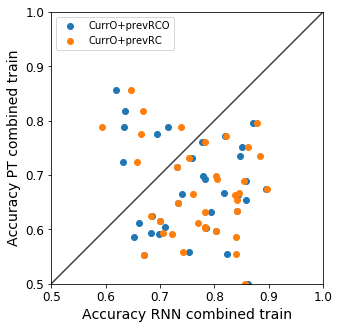

In [8]:
fig,ax= plt.subplots(figsize=(5,5))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims,lims,color='black',alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlabel('Accuracy RNN combined train',Fontsize=14);
ax.set_ylabel('Accuracy PT combined train'  ,Fontsize=14);

ax.set_xlim([0.5,1])
ax.set_ylim([0.5,1]);


plt.scatter(all_subj_metrics_manual_currprevopts.accuracy_test,PT_metrics.PT_accuracy_test,label = "CurrO+prevRCO")
plt.scatter(all_subj_metrics_manual_currOprevRC.accuracy_test, PT_metrics.PT_accuracy_test, label="CurrO+prevRC")

# plt.scatter(all_subj_metrics_manual_currO.accuracy_test, PT_metrics.PT_accuracy_test, label="CurrO")




plt.legend(loc=0);
# plt.savefig(dir_path+"Summaries/OddEvenPlays/RandomizedPlays1" +"/Accuracy_train_RNN_PT.pdf")

In [329]:
sc_stats.wilcoxon(all_subj_metrics_manual_currO.accuracy_test, PT_metrics.PT_accuracy_test)

WilcoxonResult(statistic=166.0, pvalue=0.005133961518895217)

## RNN vs RNN

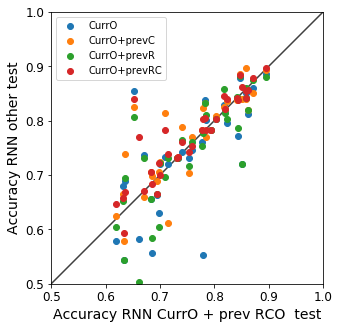

In [352]:
fig,ax= plt.subplots(figsize=(5,5))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims,lims,color='black',alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlabel('Accuracy RNN CurrO + prev RCO  test',Fontsize=14);
ax.set_ylabel('Accuracy RNN other test'  ,Fontsize=14);

ax.set_xlim([0.5,1])
ax.set_ylim([0.5,1]);



plt.scatter(all_subj_metrics_manual_currprevopts.accuracy_test, all_subj_metrics_manual_currO.accuracy_test,label="CurrO")

plt.scatter(all_subj_metrics_manual_currprevopts.accuracy_test, all_subj_metrics_manual_currOprevC.accuracy_test,label="CurrO+prevC")
plt.scatter(all_subj_metrics_manual_currprevopts.accuracy_test, all_subj_metrics_manual_currOprevR.accuracy_test,label="CurrO+prevR")

plt.scatter(all_subj_metrics_manual_currprevopts.accuracy_test, all_subj_metrics_manual_currOprevRC.accuracy_test,label="CurrO+prevRC")




plt.legend(loc=0);
# plt.savefig(dir_path+"Summaries/OddEvenPlays/RandomizedPlays1" +"/Accuracy_train_RNN_PT.pdf")

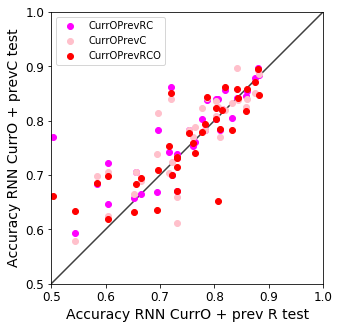

In [373]:
### RNN prevChoice vs RNN prevR

fig,ax= plt.subplots(figsize=(5,5))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims,lims,color='black',alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlabel('Accuracy RNN CurrO + prev R test',Fontsize=14);
ax.set_ylabel('Accuracy RNN CurrO + prevC test'  ,Fontsize=14);

ax.set_xlim([0.5,1])
ax.set_ylim([0.5,1]);


plt.scatter(all_subj_metrics_manual_currOprevR.accuracy_test, all_subj_metrics_manual_currOprevRC.accuracy_test,label="CurrOPrevRC",color="magenta")

plt.scatter(all_subj_metrics_manual_currOprevR.accuracy_test, all_subj_metrics_manual_currOprevC.accuracy_test,label="CurrOPrevC",color="pink")
plt.scatter(all_subj_metrics_manual_currOprevR.accuracy_test, all_subj_metrics_manual_currprevopts.accuracy_test,label="CurrOPrevRCO",color="red")




plt.legend(loc=0);
# plt.savefig(dir_path+"Summaries/OddEvenPlays/RandomizedPlays1" +"/Accuracy_train_RNN_PT.pdf")

In [355]:
sc_stats.wilcoxon(all_subj_metrics_manual_currOprevR.accuracy_test, all_subj_metrics_manual_currOprevC.accuracy_test)

WilcoxonResult(statistic=160.5, pvalue=0.03201485728313478)

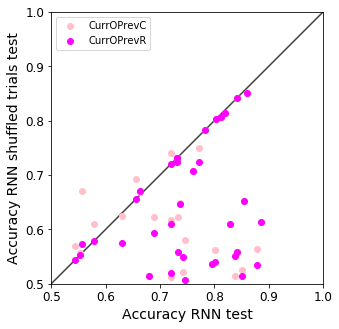

In [62]:
fig,ax= plt.subplots(figsize=(5,5))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims,lims,color='black',alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlabel('Accuracy RNN test',Fontsize=14);
ax.set_ylabel('Accuracy RNN shuffled trials test'  ,Fontsize=14);

ax.set_xlim([0.5,1])
ax.set_ylim([0.5,1]);


# plt.scatter(all_subj_metrics_manual_currO.accuracy_test, all_subj_metrics_manual_currO_randomtrials.accuracy_test,label="CurrO",color="blue")
plt.scatter(all_subj_metrics_manual_currO.accuracy_test, all_subj_metrics_manual_prevC.accuracy_test,label="CurrOPrevC",color="pink")
plt.scatter(all_subj_metrics_manual_currO.accuracy_test, all_subj_metrics_manual_prevR.accuracy_test,label="CurrOPrevR",color="magenta")

# plt.scatter(all_subj_metrics_manual_currOprevC.accuracy_test, all_subj_metrics_manual_currOprevC_randomtrials_norestore.accuracy_test,label="CurrOPrevC",color="red")



plt.legend(loc=0);
# plt.savefig(dir_path+"Summaries/OddEvenPlays/RandomizedPlays1" +"/Accuracy_train_RNN_PT.pdf")

## Random Trials

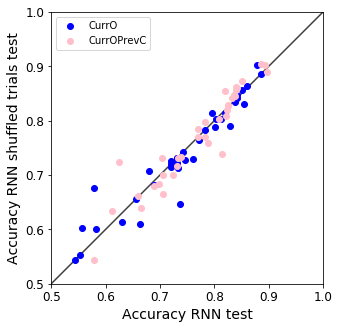

In [214]:
fig,ax= plt.subplots(figsize=(5,5))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims,lims,color='black',alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlabel('Accuracy RNN test',Fontsize=14);
ax.set_ylabel('Accuracy RNN shuffled trials test'  ,Fontsize=14);

ax.set_xlim([0.5,1])
ax.set_ylim([0.5,1]);


plt.scatter(all_subj_metrics_manual_currO.accuracy_test, all_subj_metrics_manual_currO_randomtrials.accuracy_test,label="CurrO",color="blue")
plt.scatter(all_subj_metrics_manual_currOprevC.accuracy_test, all_subj_metrics_manual_currOprevC_randomtrials.accuracy_test,label="CurrOPrevC",color="pink")

# plt.scatter(all_subj_metrics_manual_currOprevC.accuracy_test, all_subj_metrics_manual_currOprevC_randomtrials_norestore.accuracy_test,label="CurrOPrevC",color="red")



plt.legend(loc=0);
# plt.savefig(dir_path+"Summaries/OddEvenPlays/RandomizedPlays1" +"/Accuracy_train_RNN_PT.pdf")

In [191]:
sc_stats.wilcoxon(all_subj_metrics_manual_currO.accuracy_test - all_subj_metrics_manual_currO_randomtrials.accuracy_test)

WilcoxonResult(statistic=147.0, pvalue=0.312950675522914)

### Generate from PT per person, and fit with PT

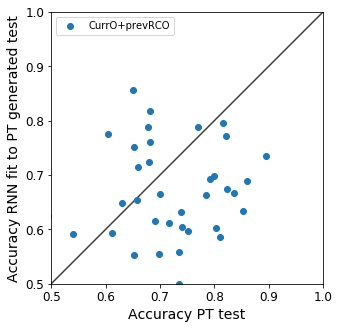

In [113]:
fig,ax= plt.subplots(figsize=(5,5))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims,lims,color='black',alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlabel('Accuracy PT test',Fontsize=14);
ax.set_ylabel('Accuracy RNN fit to PT generated test'  ,Fontsize=14);

ax.set_xlim([0.5,1])
ax.set_ylim([0.5,1]);


plt.scatter(all_subj_metrics_manual_currOPT.accuracy_test,PT_metrics.PT_accuracy_test,label = "CurrO+prevRCO")




plt.legend(loc=0);


In [114]:
sc_stats.wilcoxon(all_subj_metrics_manual_currOPT.accuracy_test,PT_metrics.PT_accuracy_test)

WilcoxonResult(statistic=220.0, pvalue=0.047272946391042465)

0.7172414064407349


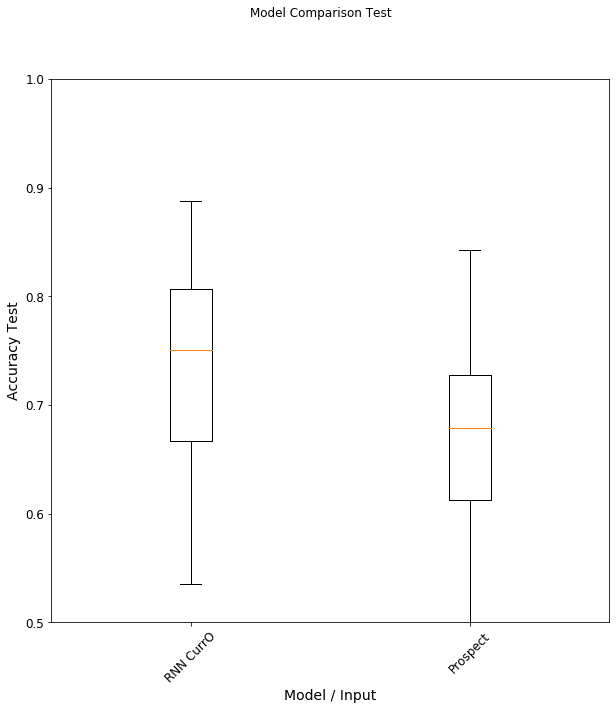

In [121]:
PT_all_models_df = {'RNNCurrO':all_subj_metrics_manual_currOPT.accuracy_train, 'PT':PT_metrics.PT_accuracy.to_list()}
PT_all_models_df = pd.DataFrame(PT_all_models_df)
plt.figure(figsize=(10,10))
# plt.boxplot(np.array([train_R2_all_models_df.PrevCRORT,train_R2_all_models_df.PrevCRO,train_R2_all_models_df.PrevCR,train_R2_all_models_df.Curr,train_R2_all_models_df.PT]).T,labels=["PrevC+R+O+RT+ CurrO","PrevC+R+O+ CurrO","PrevC+R +CurrO","CurrO","Prospect"]);
plt.boxplot(np.array([PT_all_models_df.RNNCurrO, PT_all_models_df.PT]).T, labels=["RNN CurrO","Prospect"] );

plt.xlabel("Model / Input");
plt.ylabel('Accuracy Test');
plt.suptitle("Model Comparison Test");
plt.xticks(rotation=45)
plt.ylim([0.5,1]);

print(np.median(all_subj_metrics_manual_currOPT.accuracy_test))
print(np.median(PT_metrics.PT_accuracy_test))








## Model Comparison

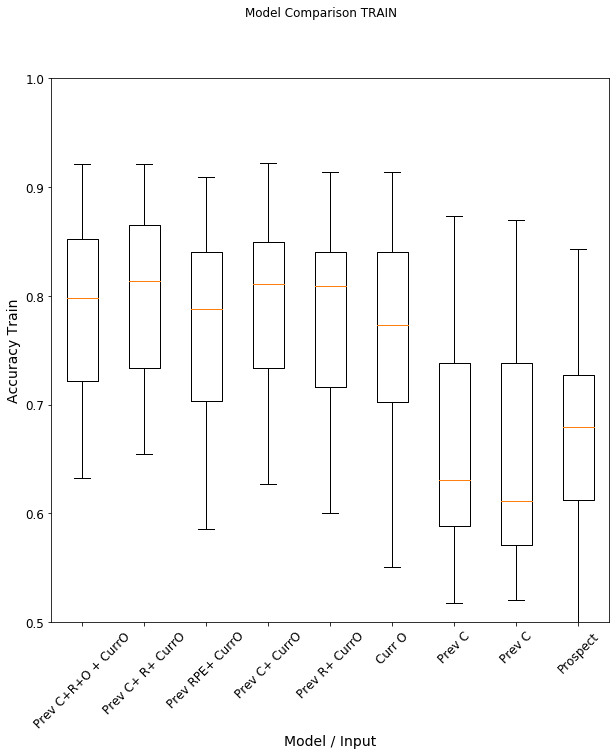

In [96]:
train_Acc_all_models_df = {'currprevopts':all_subj_metrics_manual_currprevopts.accuracy_train,'currOprevRC':all_subj_metrics_manual_currOprevRC.accuracy_train, 'currOprevRPE':all_subj_metrics_manual_currOprevRPE.accuracy_train, 'currOprevC':all_subj_metrics_manual_currOprevC.accuracy_train, 'currOprevR':all_subj_metrics_manual_currOprevR.accuracy_train,'currO':all_subj_metrics_manual_currO.accuracy_train, 'prevC':all_subj_metrics_manual_prevC.accuracy_train, 'prevR':all_subj_metrics_manual_prevR.accuracy_train, 'PT':PT_metrics.PT_accuracy.to_list()}
train_Acc_all_models_df = pd.DataFrame(train_Acc_all_models_df)
plt.figure(figsize=(10,10))
# plt.boxplot(np.array([train_R2_all_models_df.PrevCRORT,train_R2_all_models_df.PrevCRO,train_R2_all_models_df.PrevCR,train_R2_all_models_df.Curr,train_R2_all_models_df.PT]).T,labels=["PrevC+R+O+RT+ CurrO","PrevC+R+O+ CurrO","PrevC+R +CurrO","CurrO","Prospect"]);
plt.boxplot(np.array([train_Acc_all_models_df.currprevopts,train_Acc_all_models_df.currOprevRC,train_Acc_all_models_df.currOprevRPE,train_Acc_all_models_df.currOprevC,train_Acc_all_models_df.currOprevR, train_Acc_all_models_df.currO,train_Acc_all_models_df.prevC, train_Acc_all_models_df.prevR, train_Acc_all_models_df.PT]).T, labels=["Prev C+R+O + CurrO","Prev C+ R+ CurrO","Prev RPE+ CurrO","Prev C+ CurrO","Prev R+ CurrO","Curr O","Prev C","Prev C","Prospect"] );

plt.xlabel("Model / Input");
plt.ylabel('Accuracy Train');
plt.suptitle("Model Comparison TRAIN");
plt.xticks(rotation=45)
plt.ylim([0.5,1]);



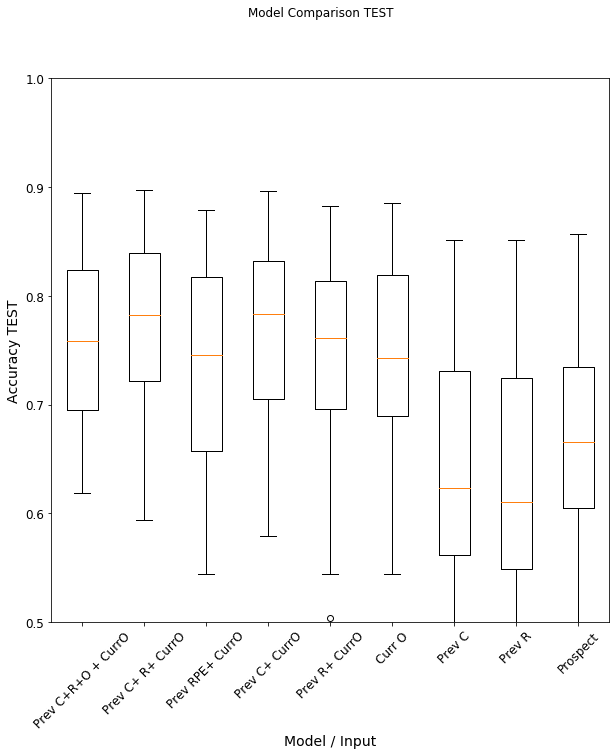

In [98]:
test_Acc_all_models_df = {'currprevopts':all_subj_metrics_manual_currprevopts.accuracy_test,  'currOprevRC':all_subj_metrics_manual_currOprevRC.accuracy_test,'currOprevRPE':all_subj_metrics_manual_currOprevRPE.accuracy_test,'currOprevC':all_subj_metrics_manual_currOprevC.accuracy_test, 'currOprevR':all_subj_metrics_manual_currOprevR.accuracy_test,'currO':all_subj_metrics_manual_currO.accuracy_test, 'prevC':all_subj_metrics_manual_prevC.accuracy_test,'prevR':all_subj_metrics_manual_prevR.accuracy_test, 'PT':PT_metrics.PT_accuracy_test.to_list()}
test_Acc_all_models_df = pd.DataFrame(test_Acc_all_models_df)
plt.figure(figsize=(10,10))
# plt.boxplot(np.array([train_R2_all_models_df.PrevCRORT,train_R2_all_models_df.PrevCRO,train_R2_all_models_df.PrevCR,train_R2_all_models_df.Curr,train_R2_all_models_df.PT]).T,labels=["PrevC+R+O+RT+ CurrO","PrevC+R+O+ CurrO","PrevC+R +CurrO","CurrO","Prospect"]);
plt.boxplot(np.array([test_Acc_all_models_df.currprevopts,test_Acc_all_models_df.currOprevRC, test_Acc_all_models_df.currOprevRPE, test_Acc_all_models_df.currOprevC,test_Acc_all_models_df.currOprevR, test_Acc_all_models_df.currO,test_Acc_all_models_df.prevC,test_Acc_all_models_df.prevR, test_Acc_all_models_df.PT]).T, labels=["Prev C+R+O + CurrO","Prev C+ R+ CurrO","Prev RPE+ CurrO","Prev C+ CurrO","Prev R+ CurrO","Curr O","Prev C","Prev R","Prospect"] );

plt.xlabel("Model / Input");
plt.ylabel('Accuracy TEST');
plt.suptitle("Model Comparison TEST");
plt.xticks(rotation=45)
plt.ylim([0.5,1]);



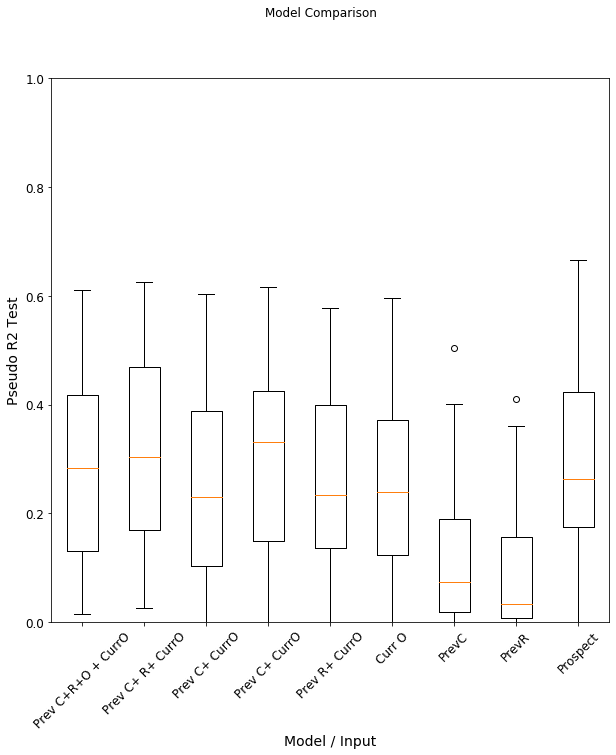

In [100]:
test_R2_all_models_df = {'currprevopts':all_subj_metrics_manual_currprevopts.pseudoR2_test, 'currOprevRC':all_subj_metrics_manual_currOprevRC.pseudoR2_test,'currOprevRPE':all_subj_metrics_manual_currOprevRPE.pseudoR2_test,'currOprevC':all_subj_metrics_manual_currOprevC.pseudoR2_test, 'currOprevR':all_subj_metrics_manual_currOprevR.pseudoR2_test,'currO':all_subj_metrics_manual_currO.pseudoR2_test, 'prevC':all_subj_metrics_manual_prevC.pseudoR2_test, 'prevR':all_subj_metrics_manual_prevR.pseudoR2_test,'PT':PT_metrics.PT_pseudoR2_test.to_list()}
test_R2_all_models_df = pd.DataFrame(test_R2_all_models_df)
plt.figure(figsize=(10,10))
# plt.boxplot(np.array([train_R2_all_models_df.PrevCRORT,train_R2_all_models_df.PrevCRO,train_R2_all_models_df.PrevCR,train_R2_all_models_df.Curr,train_R2_all_models_df.PT]).T,labels=["PrevC+R+O+RT+ CurrO","PrevC+R+O+ CurrO","PrevC+R +CurrO","CurrO","Prospect"]);
plt.boxplot(np.array([test_R2_all_models_df.currprevopts,test_R2_all_models_df.currOprevRC,test_R2_all_models_df.currOprevRPE,test_R2_all_models_df.currOprevC,test_R2_all_models_df.currOprevR, test_R2_all_models_df.currO,test_R2_all_models_df.prevC,test_R2_all_models_df.prevR,test_R2_all_models_df.PT]).T, labels=["Prev C+R+O + CurrO","Prev C+ R+ CurrO","Prev C+ CurrO","Prev C+ CurrO","Prev R+ CurrO","Curr O","PrevC","PrevR","Prospect"] );

plt.xlabel("Model / Input");
plt.ylabel('Pseudo R2 Test');
plt.suptitle("Model Comparison");
plt.xticks(rotation=45)
plt.ylim([0,1]);


In [382]:
# all_subj_metrics_manual_currO.pseudoR2_test

## Subject by Subject

/Users/ritwik7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ritwik7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:235: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ritwik7/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, 

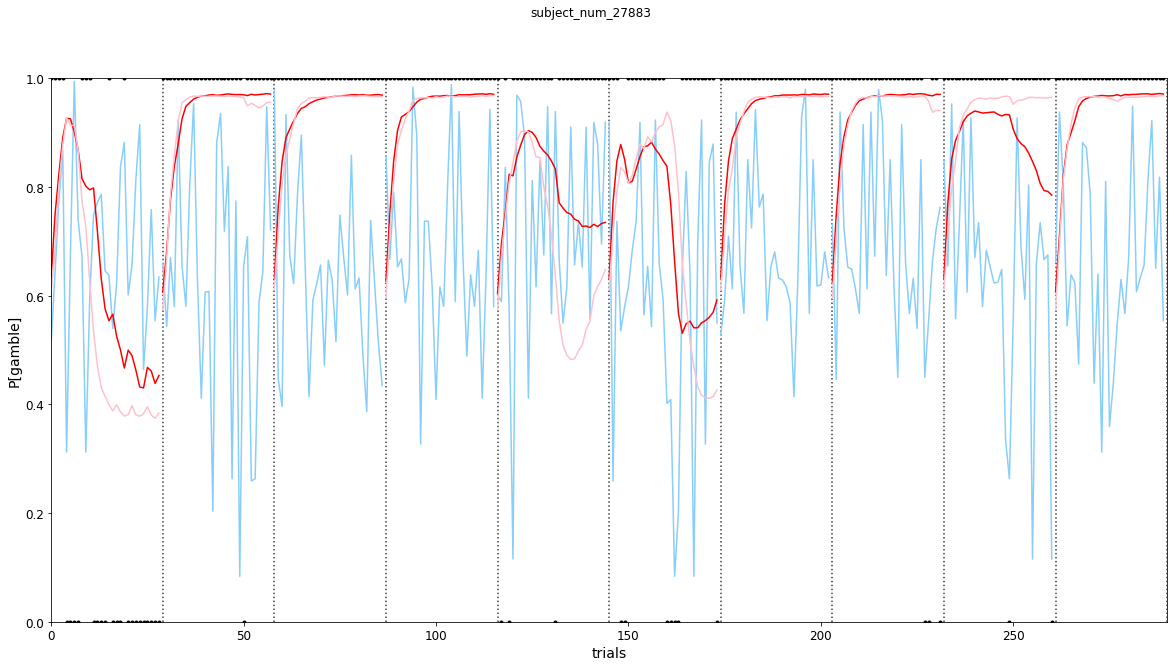

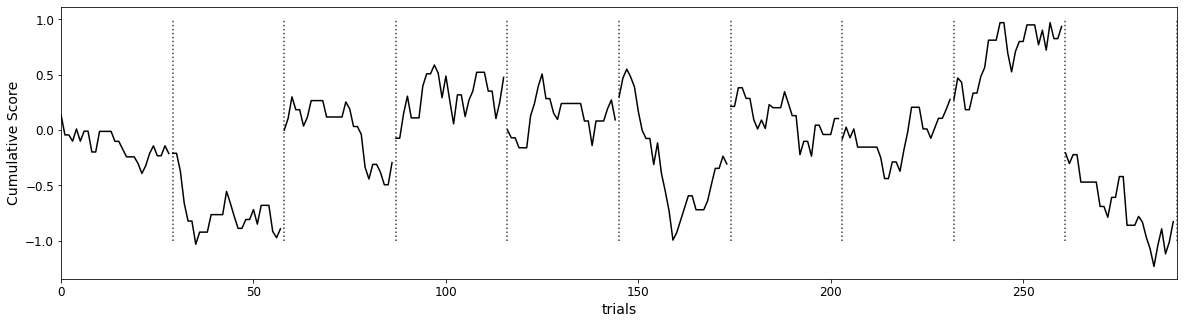

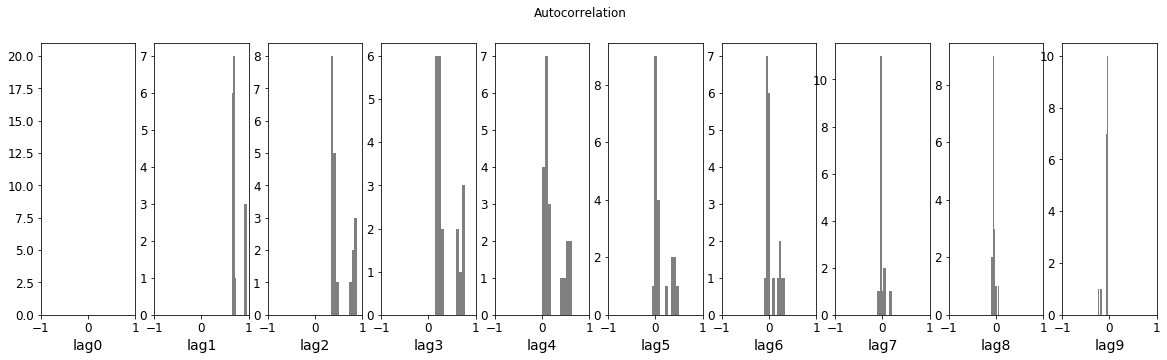

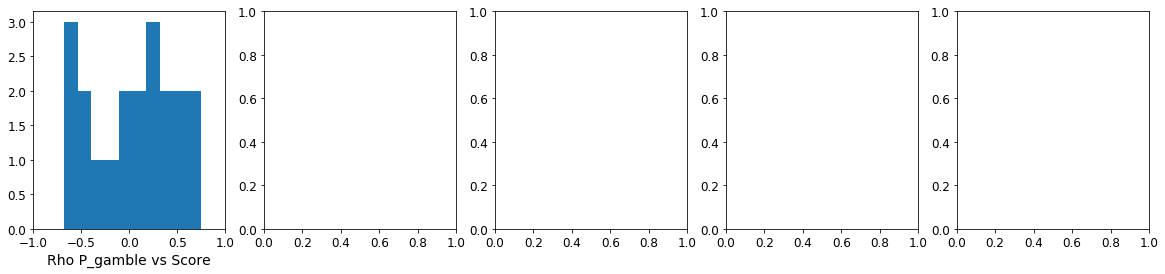

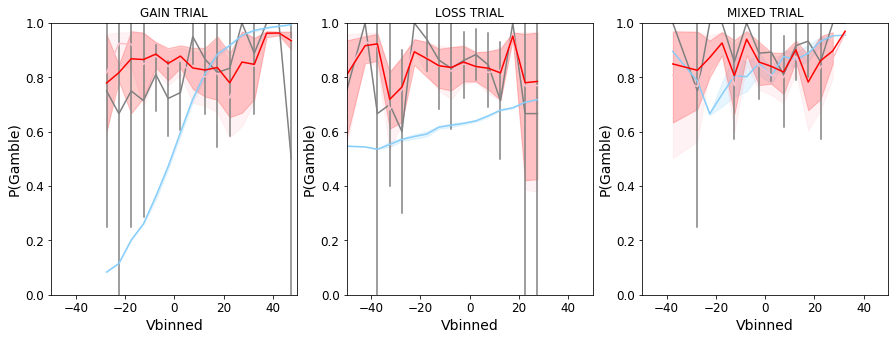

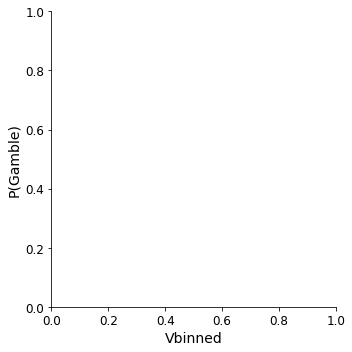

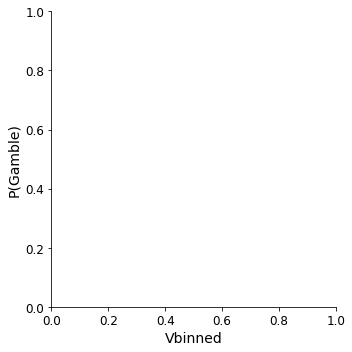

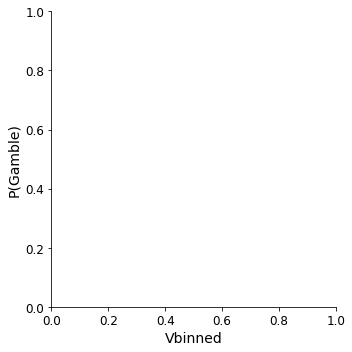

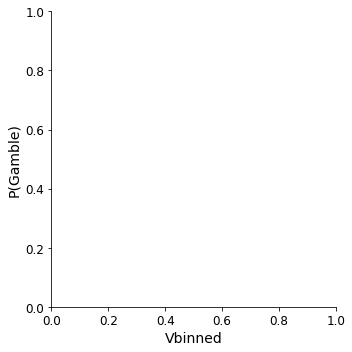

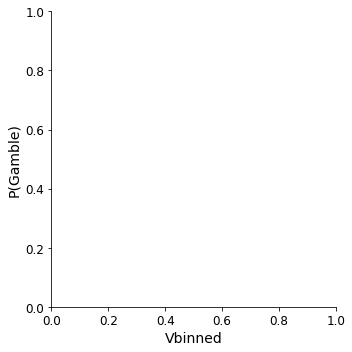

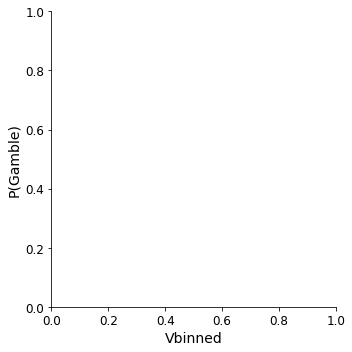

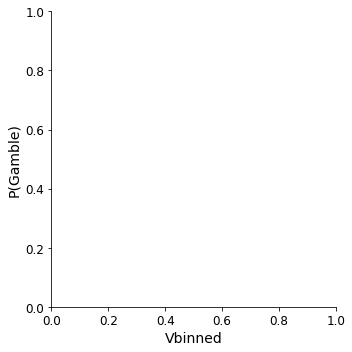

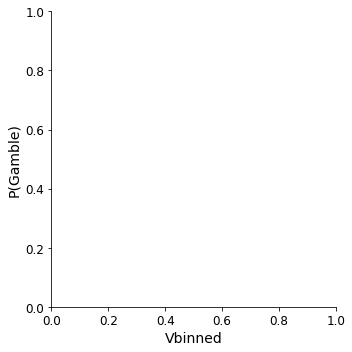

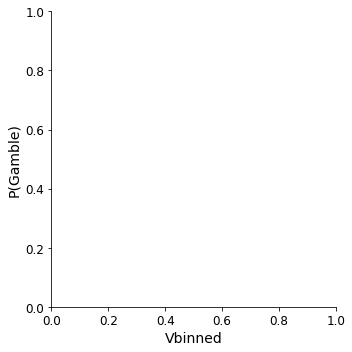

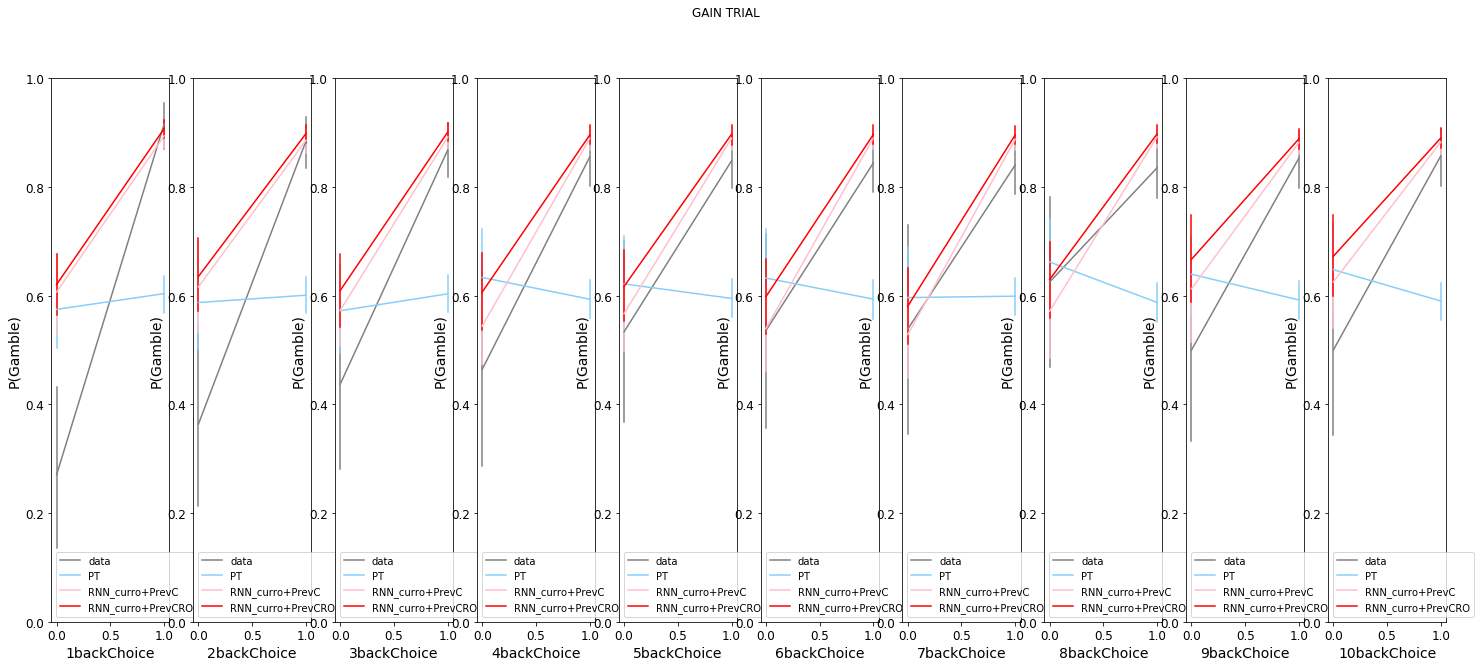

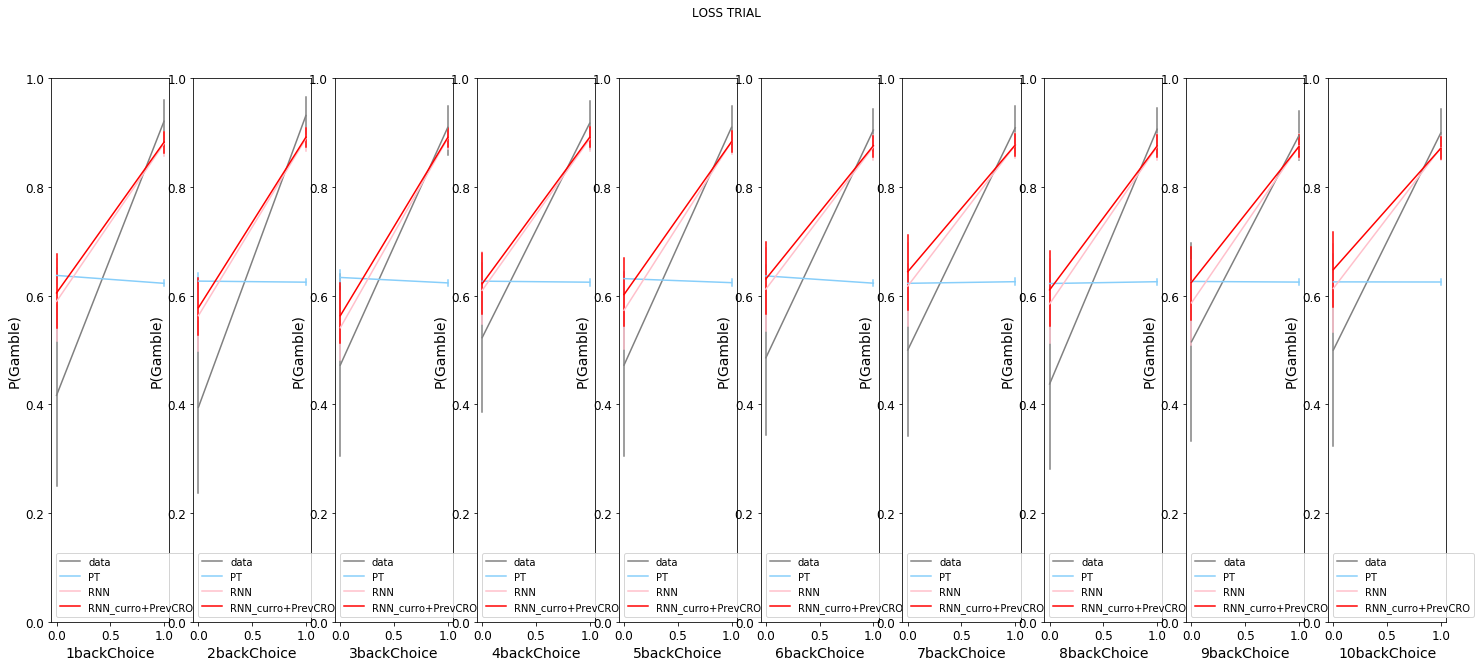

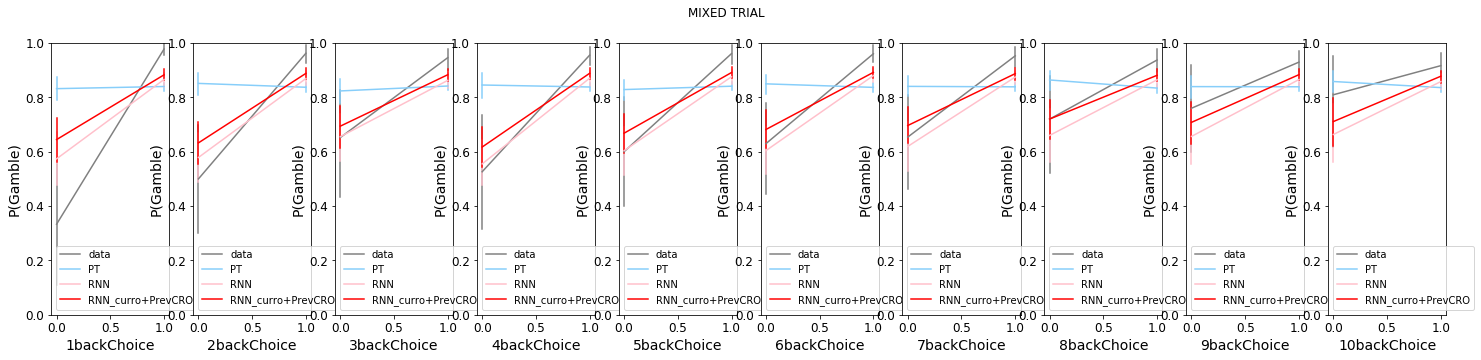

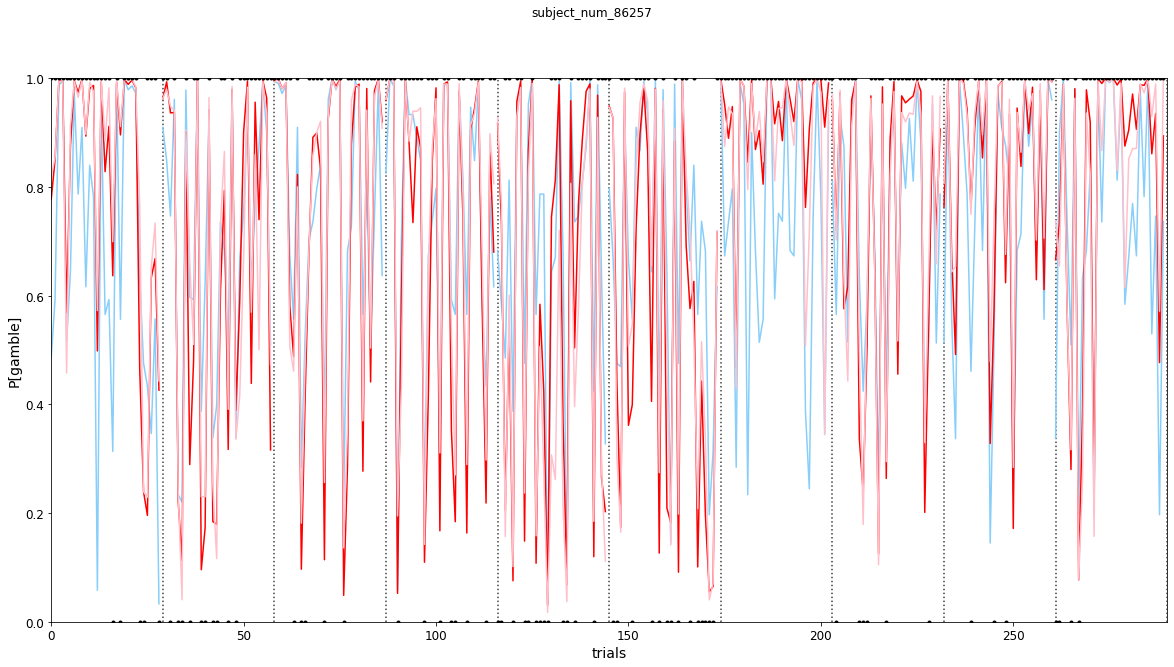

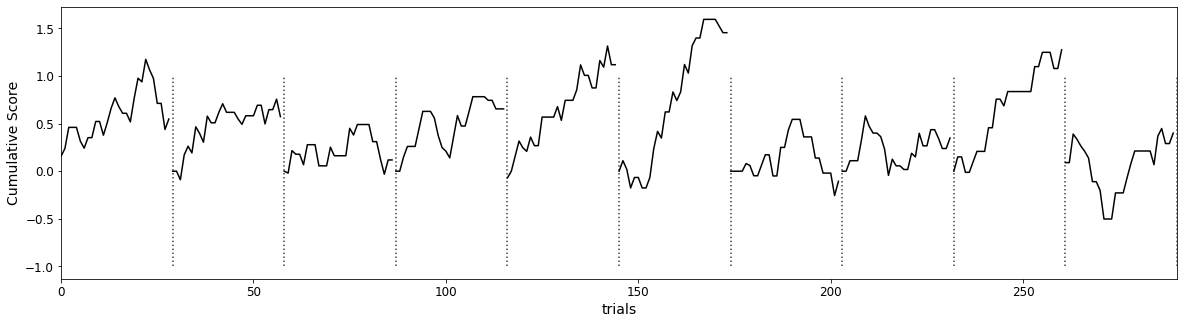

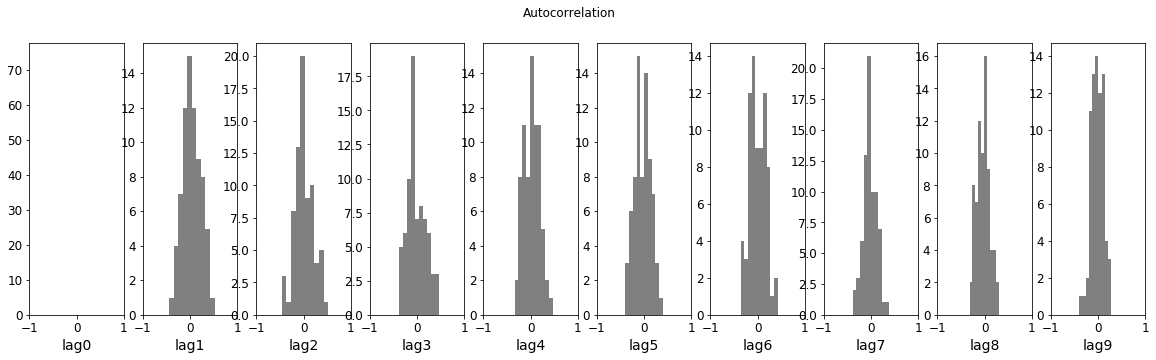

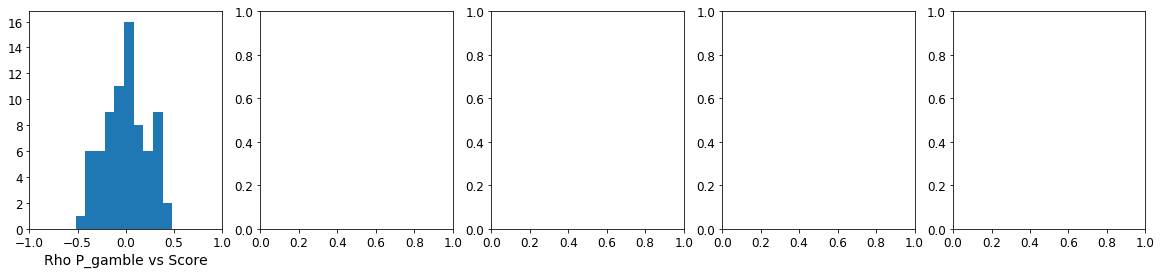

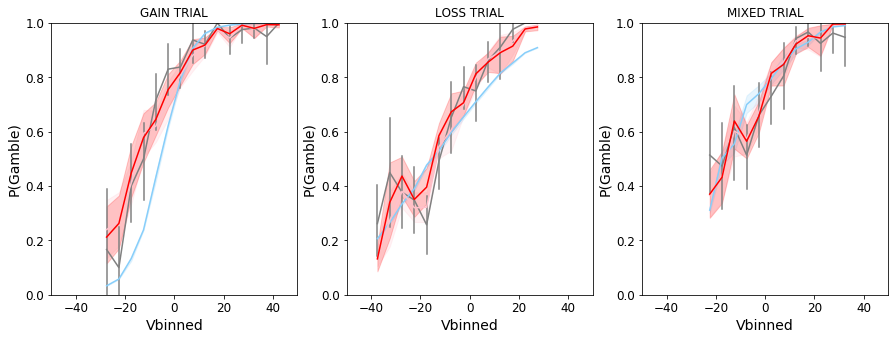

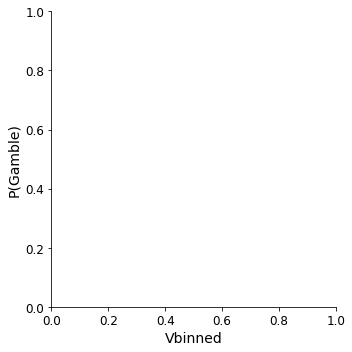

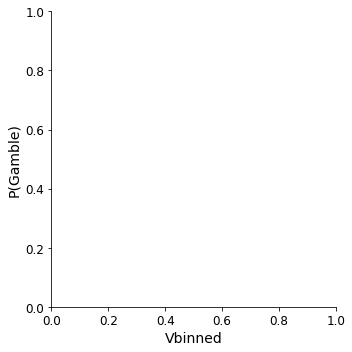

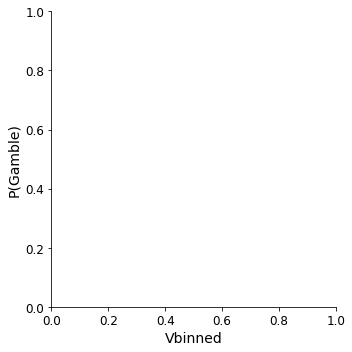

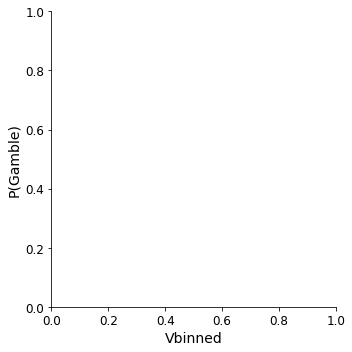

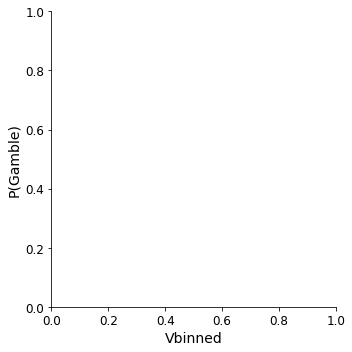

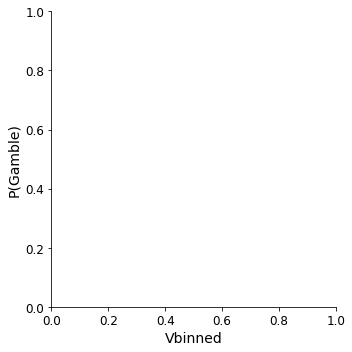

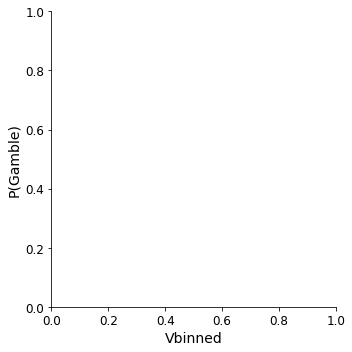

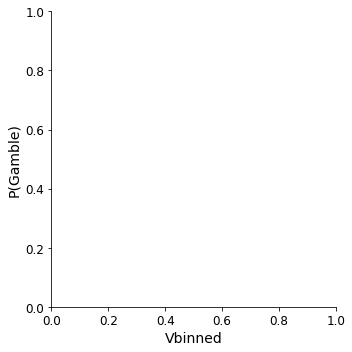

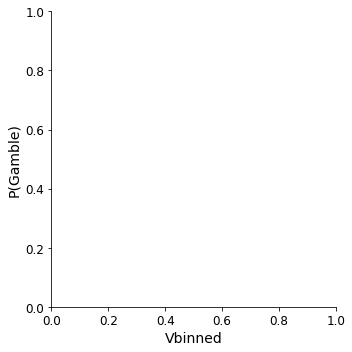

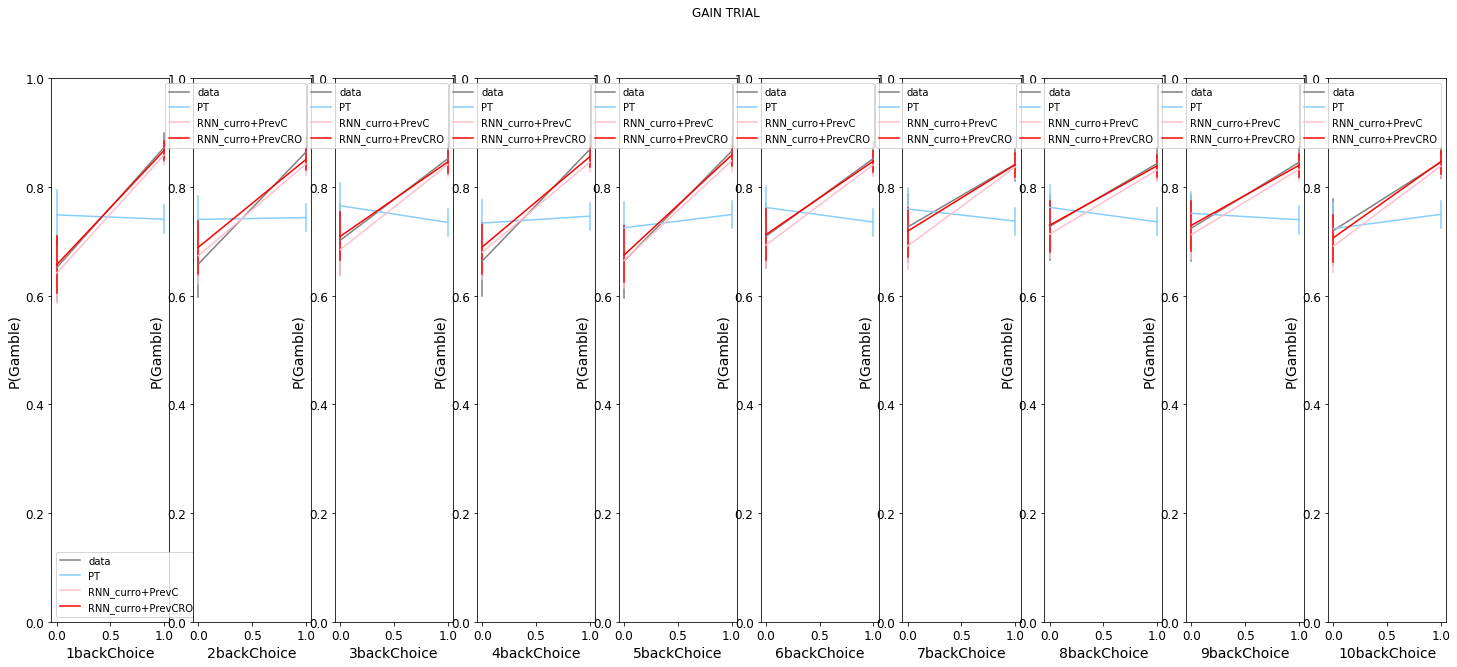

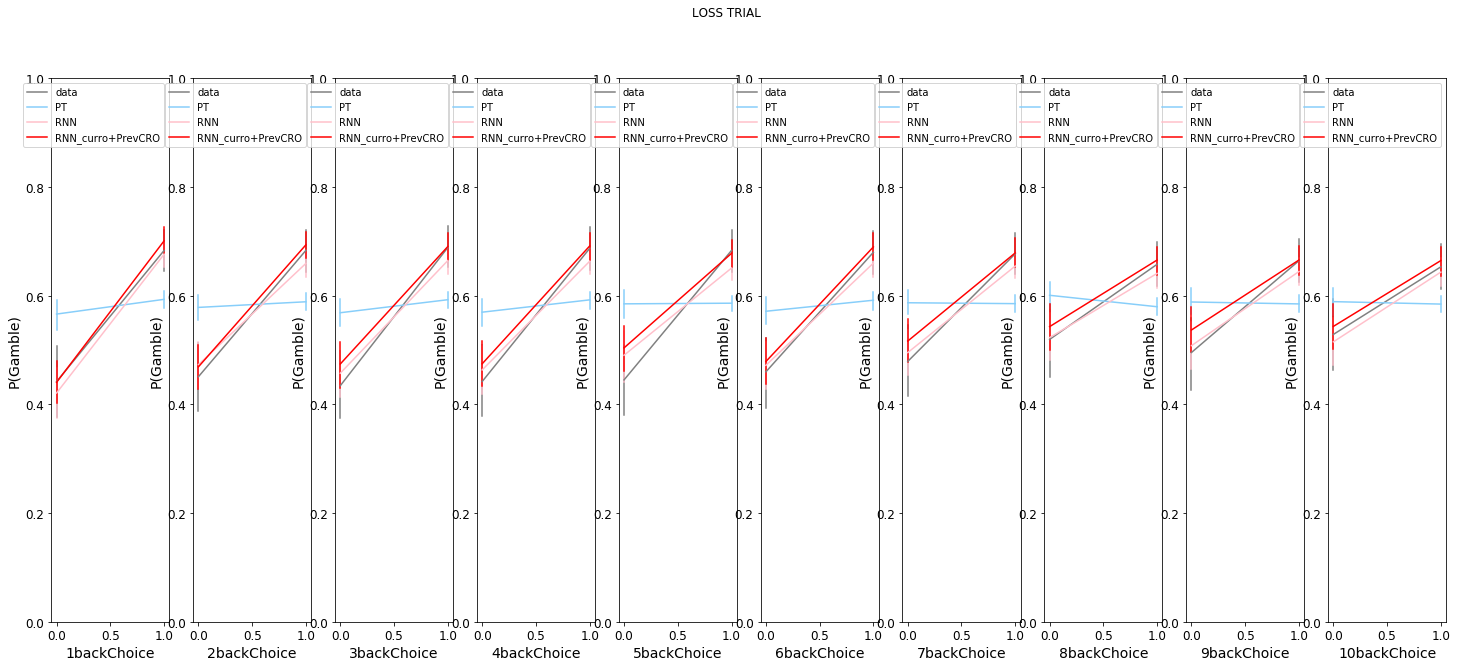

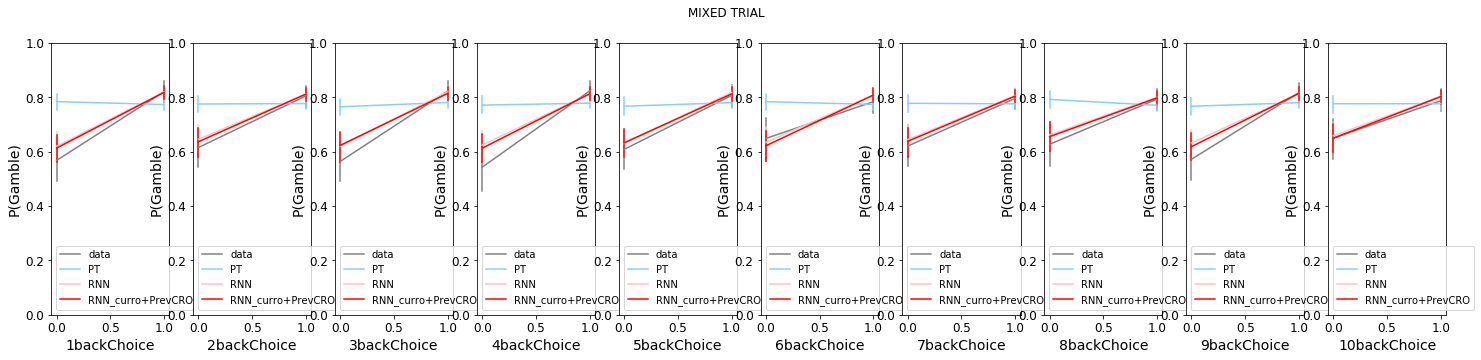

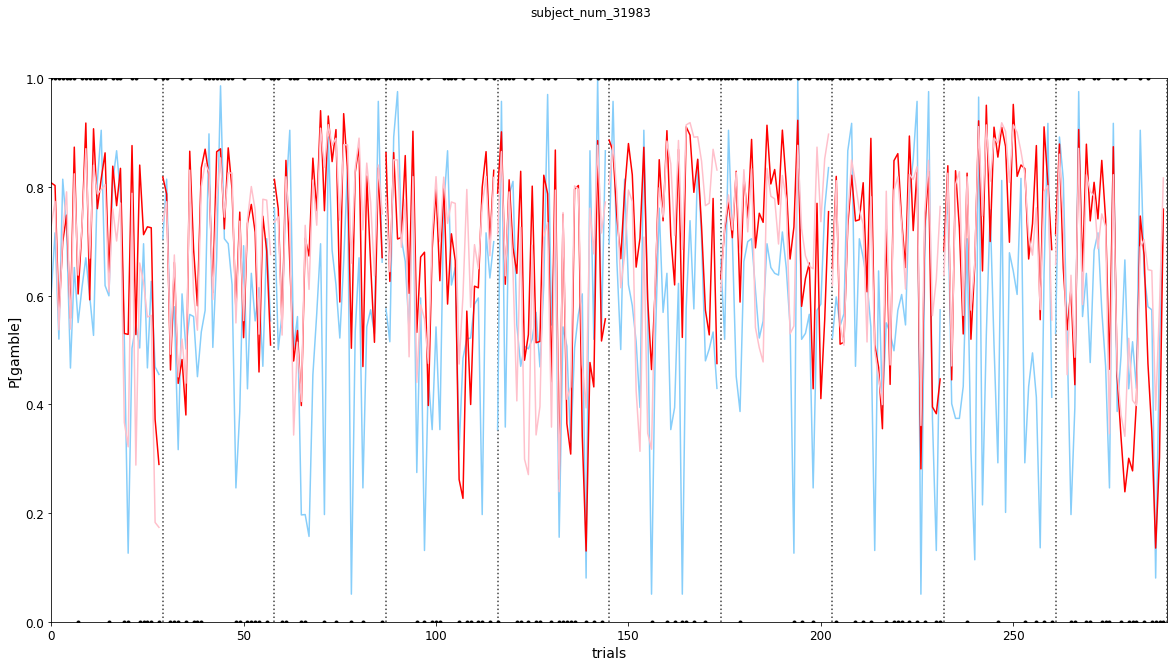

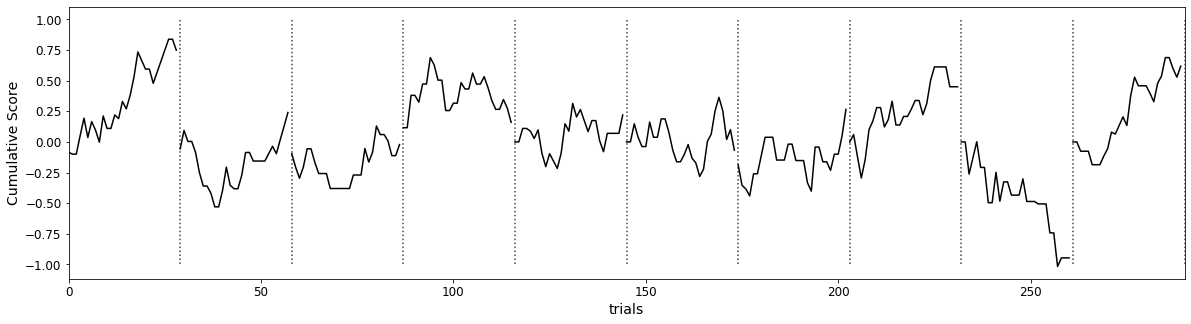

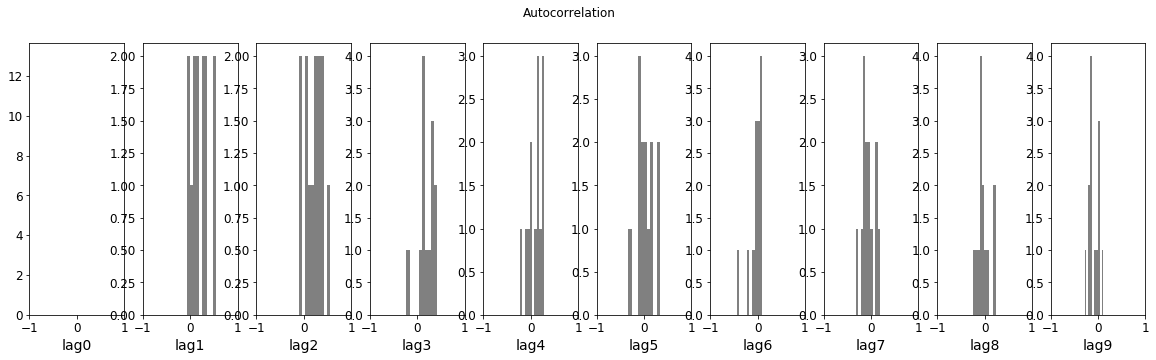

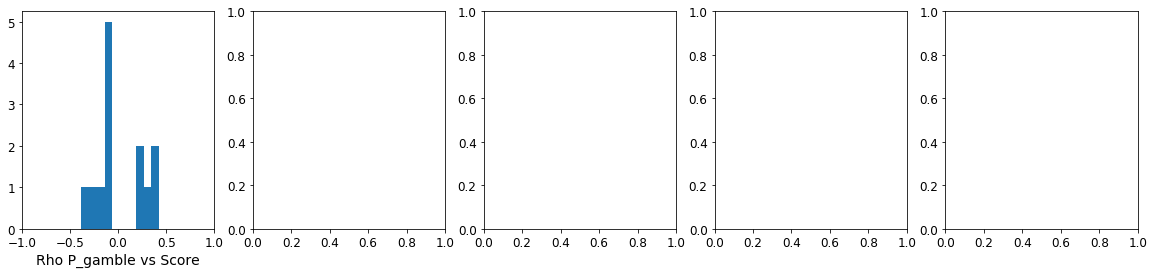

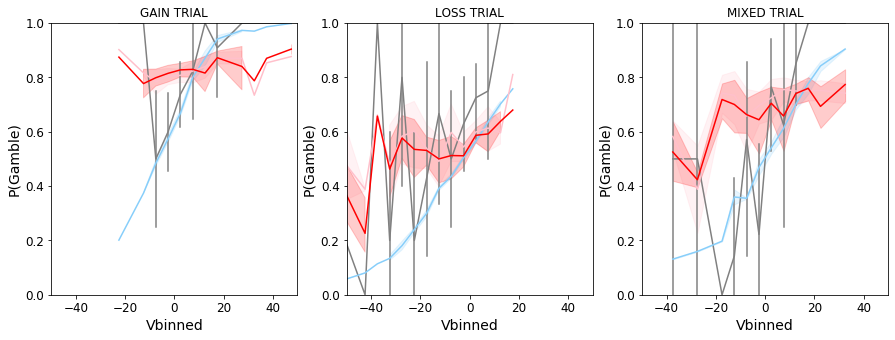

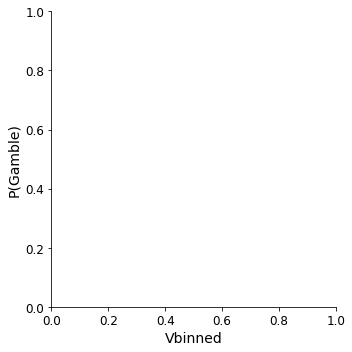

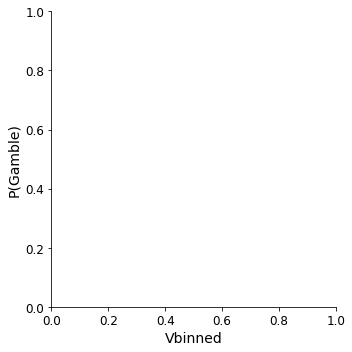

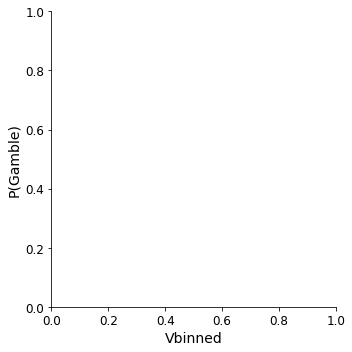

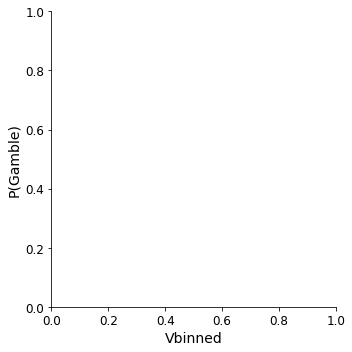

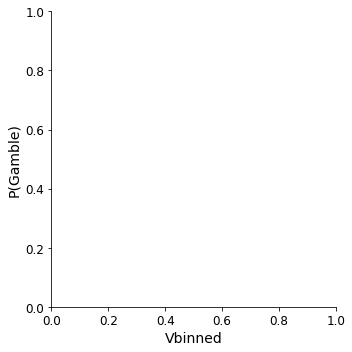

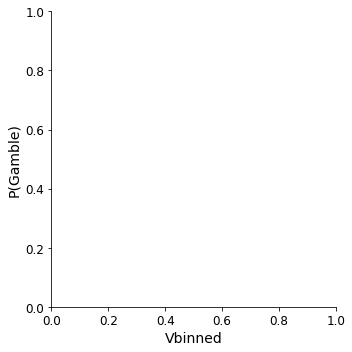

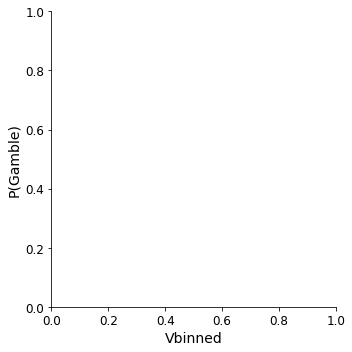

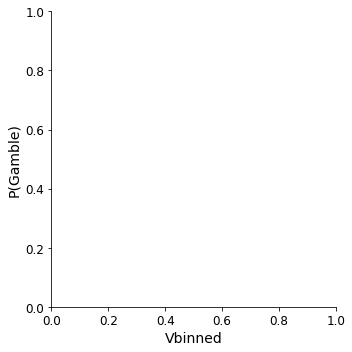

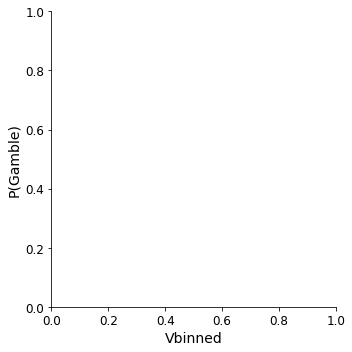

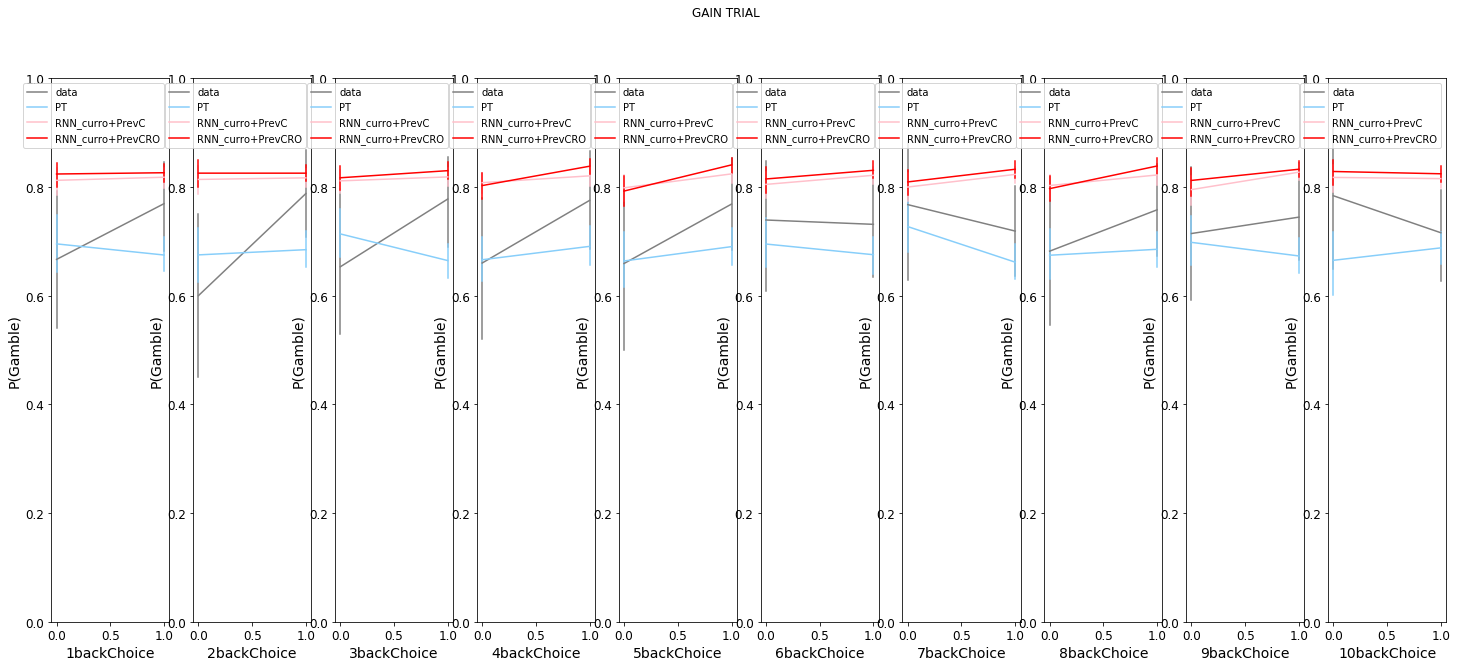

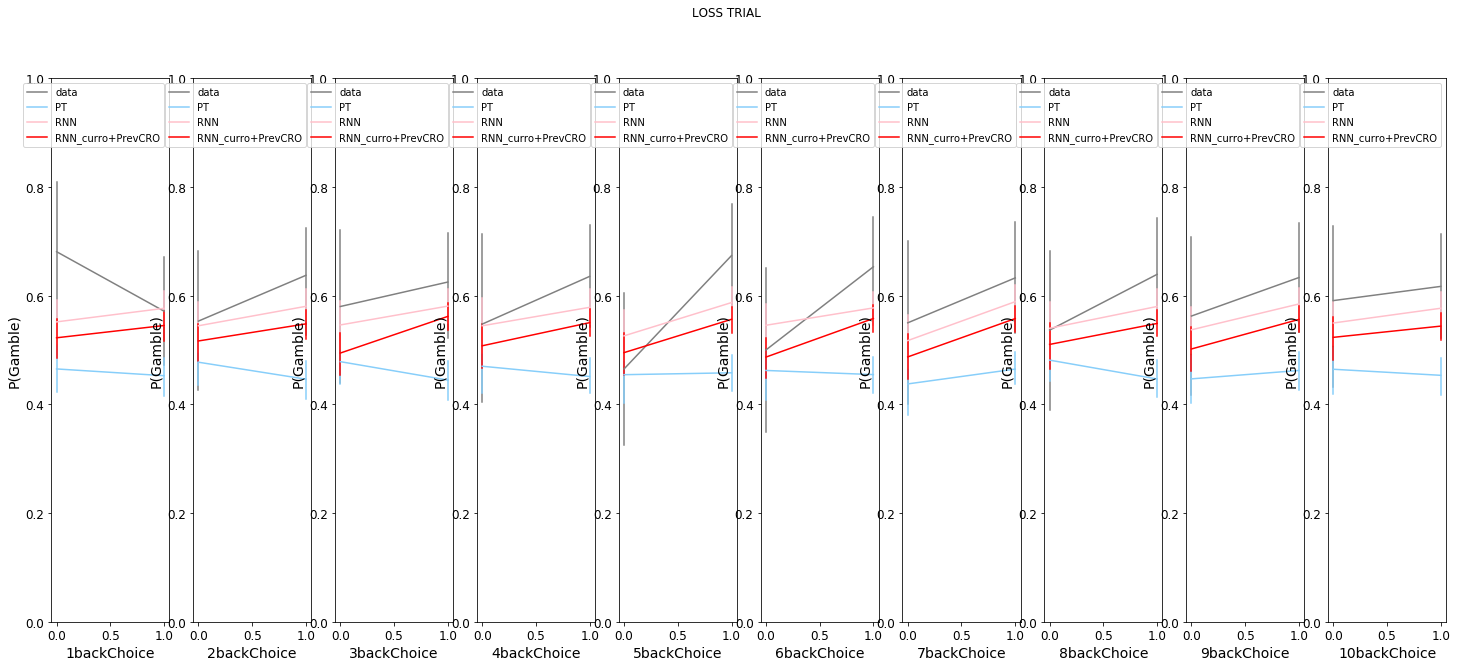

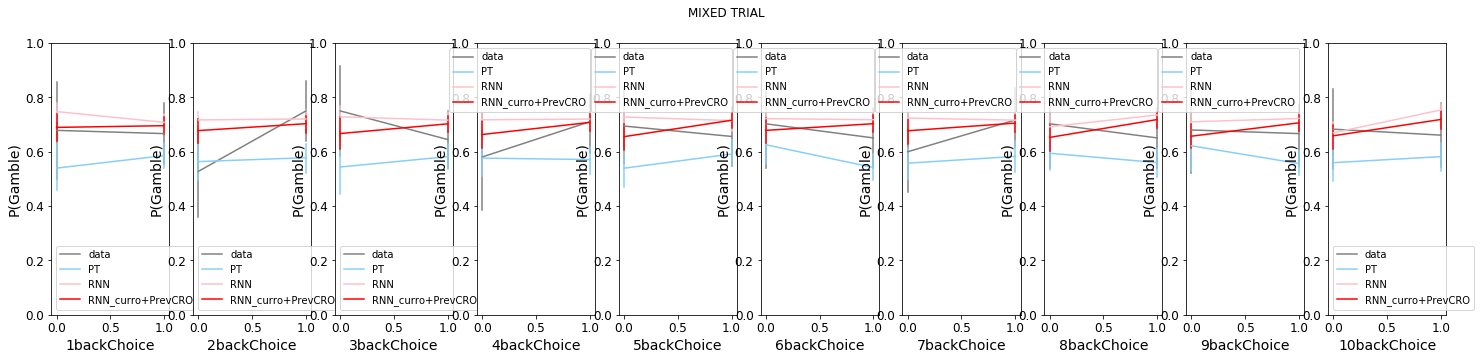

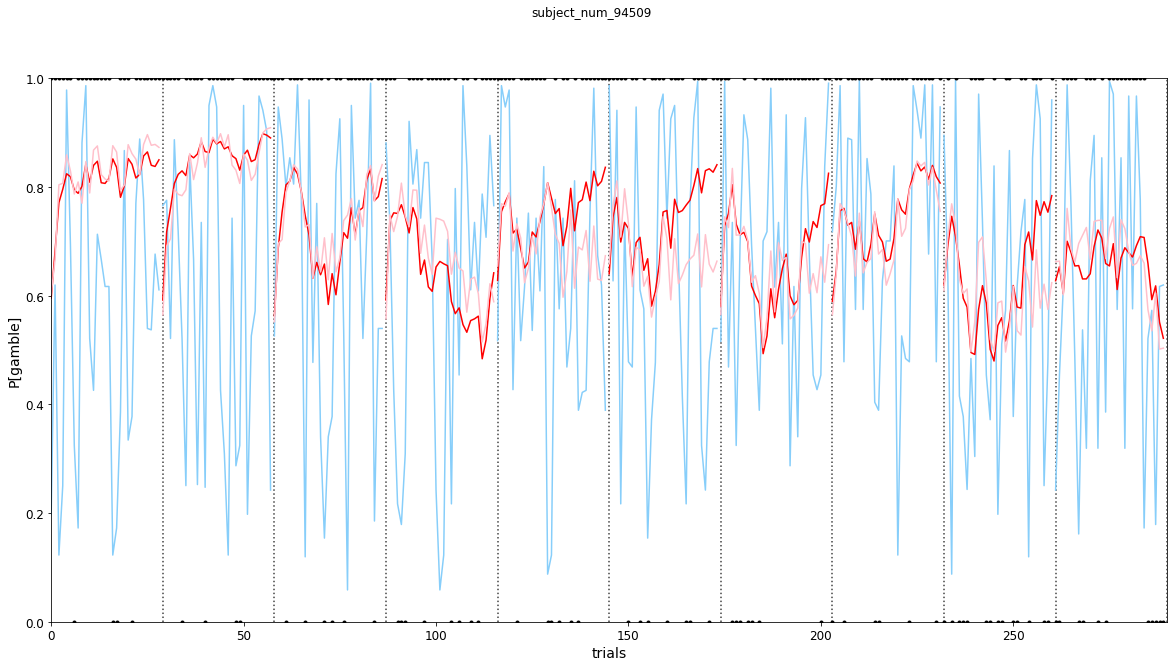

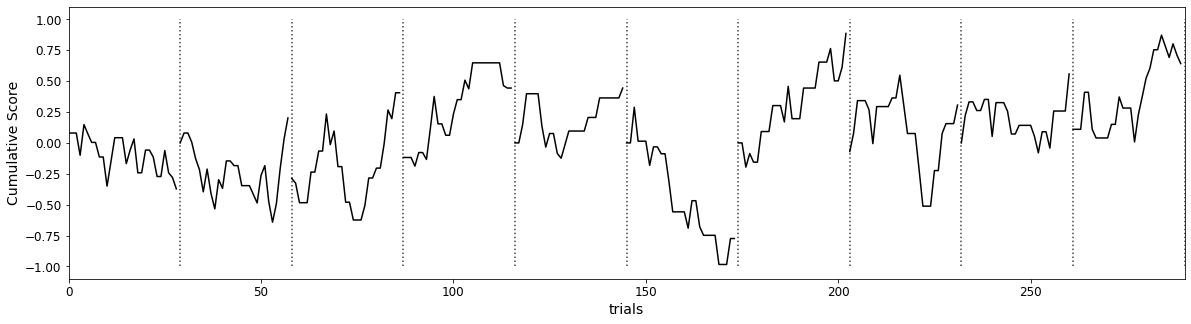

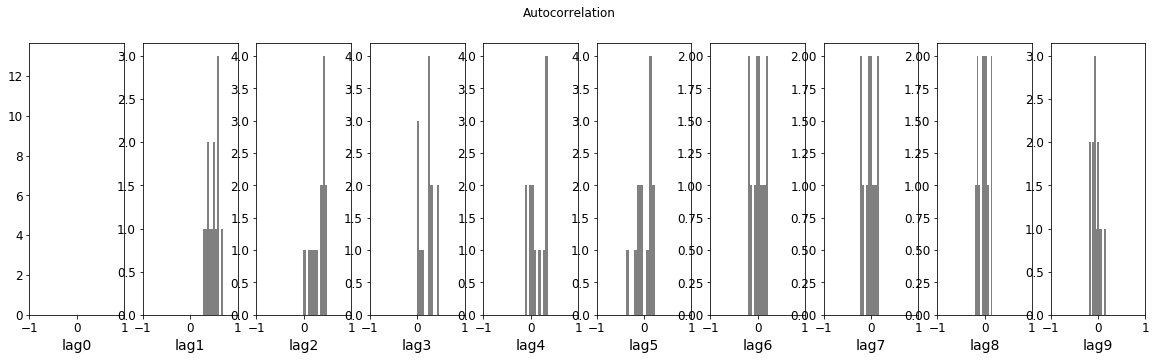

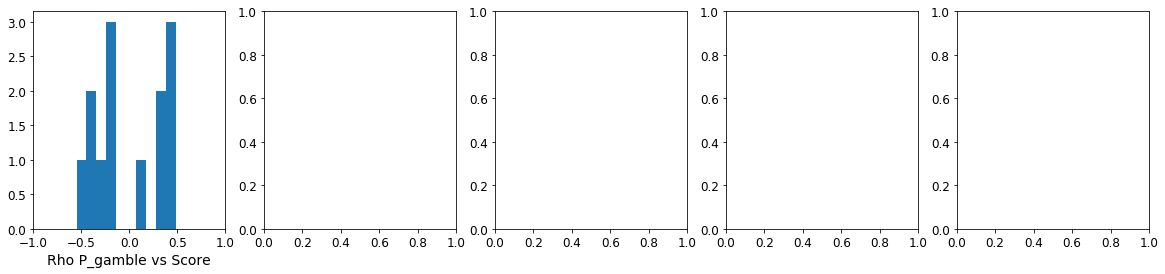

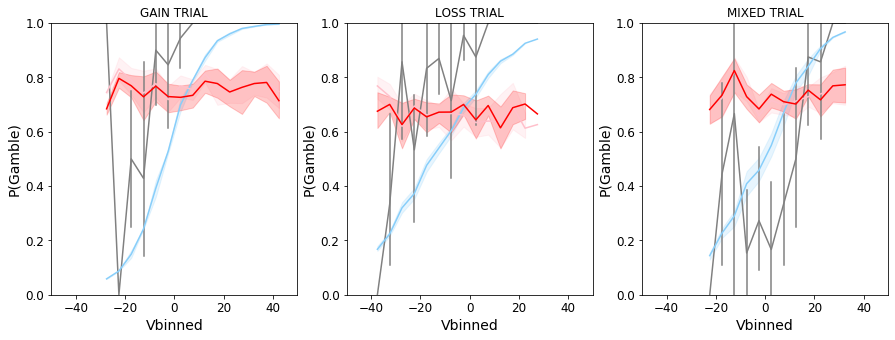

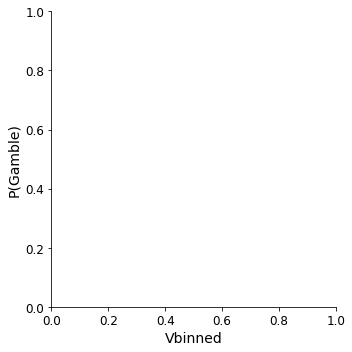

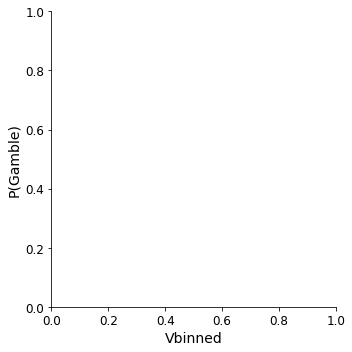

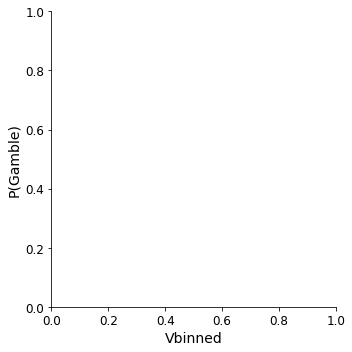

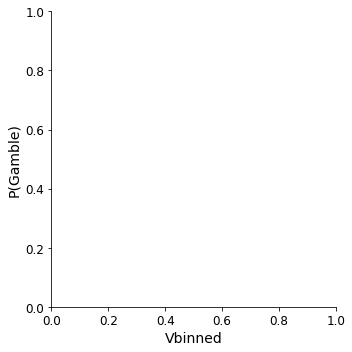

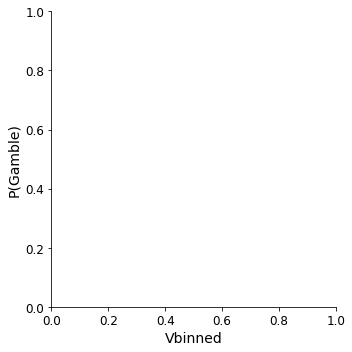

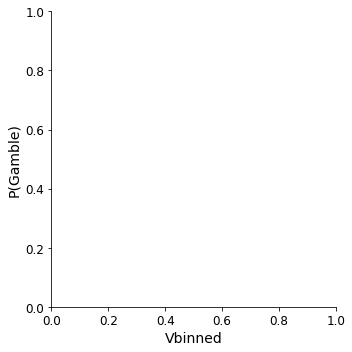

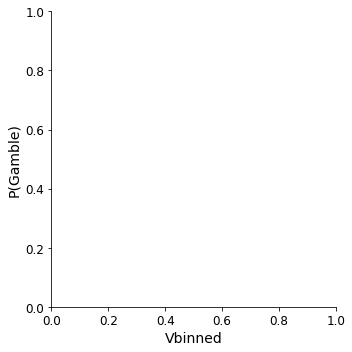

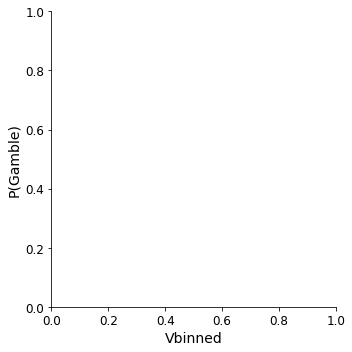

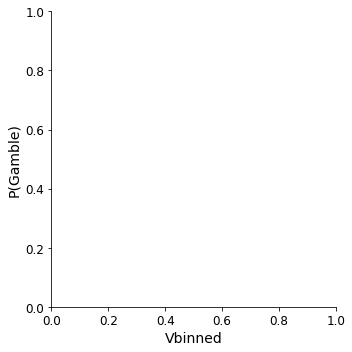

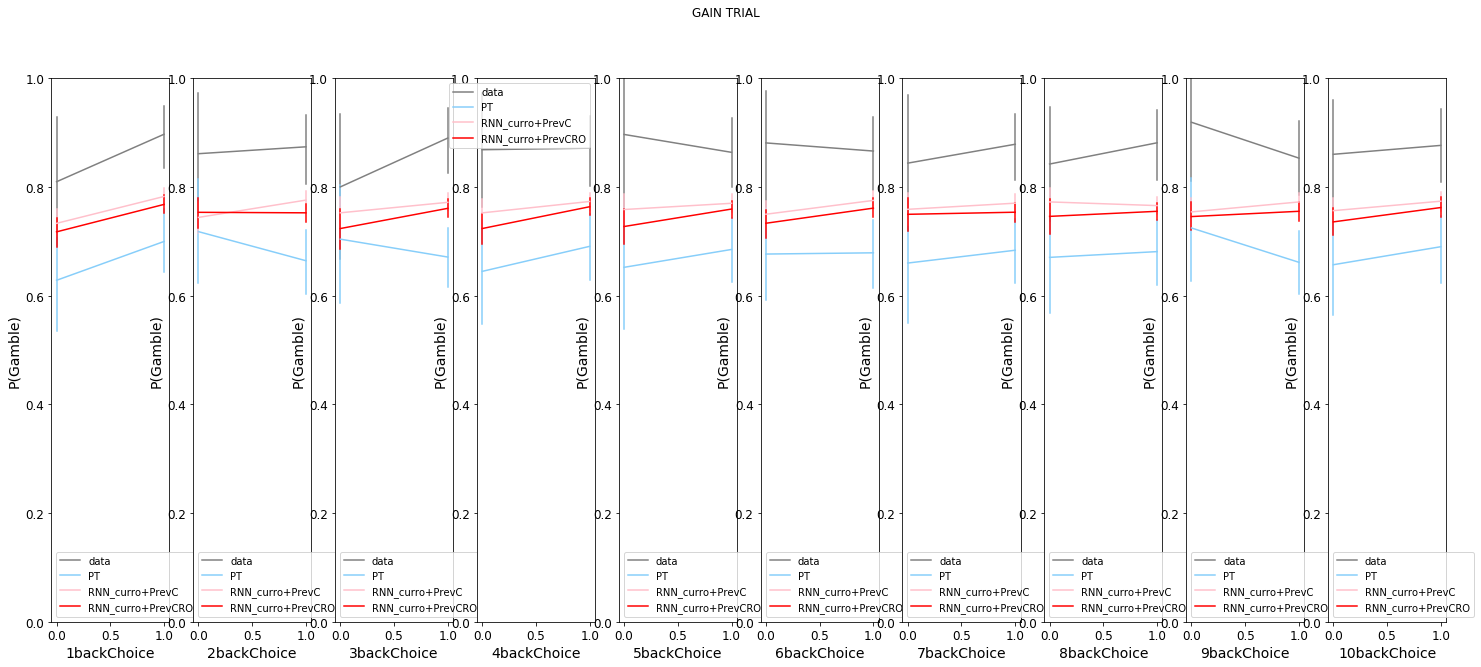

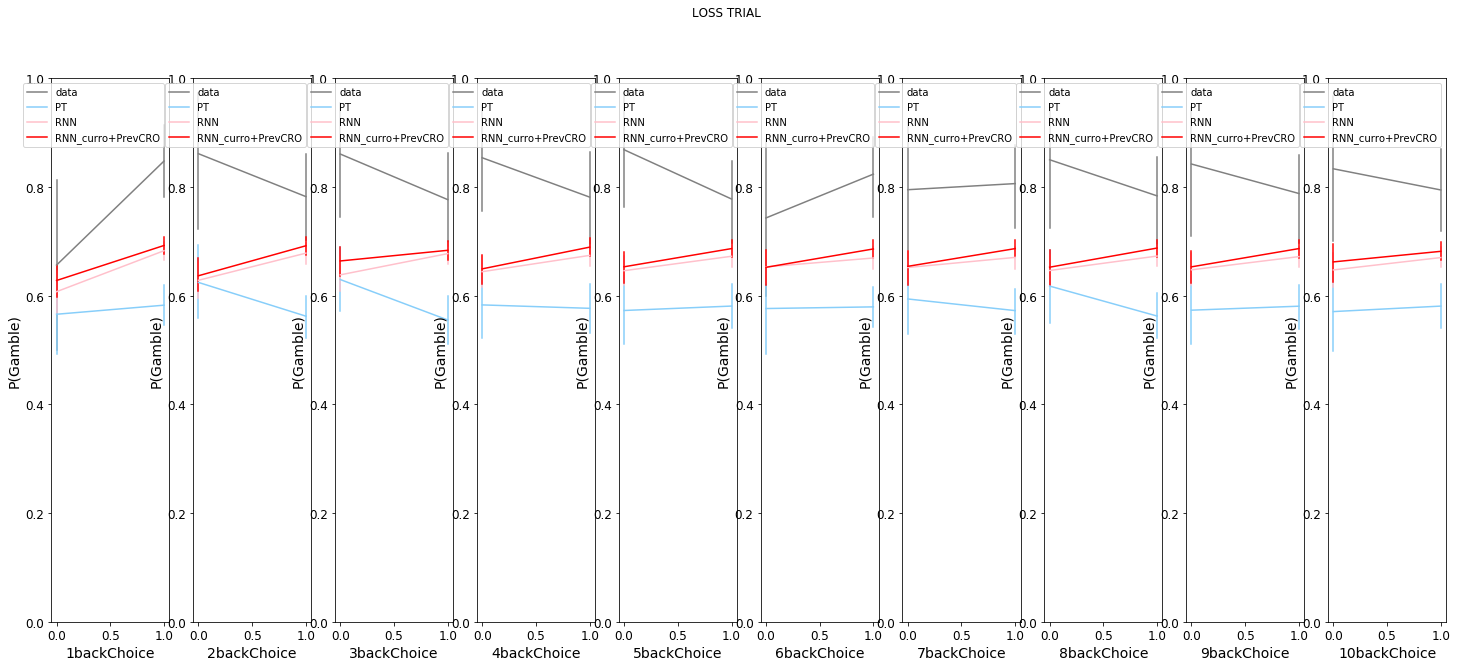

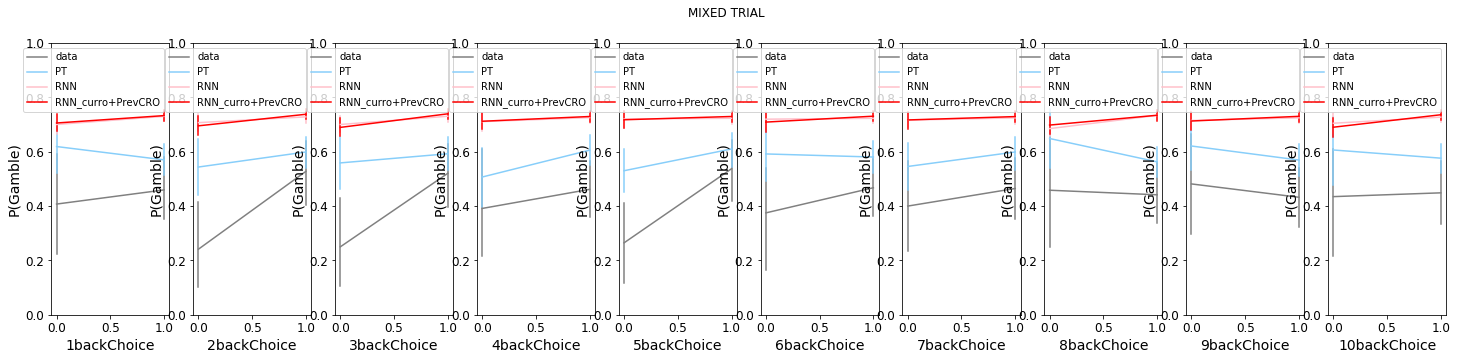

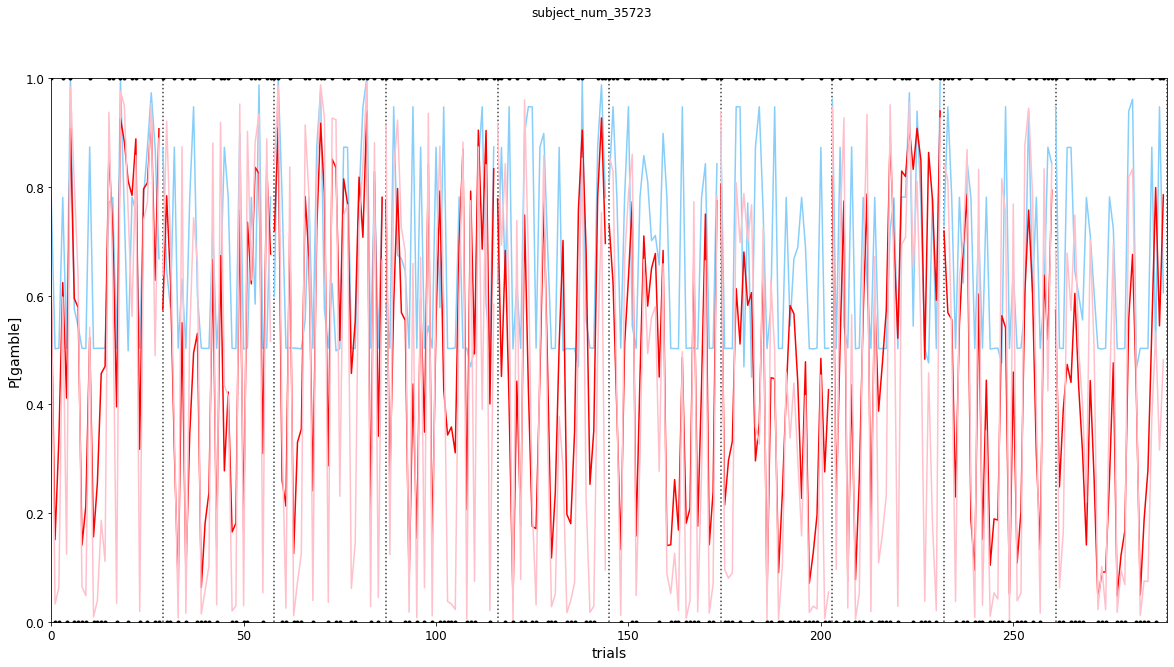

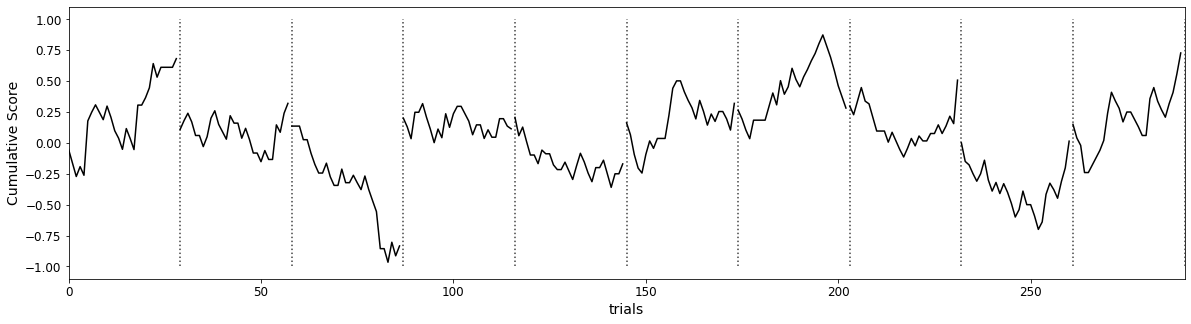

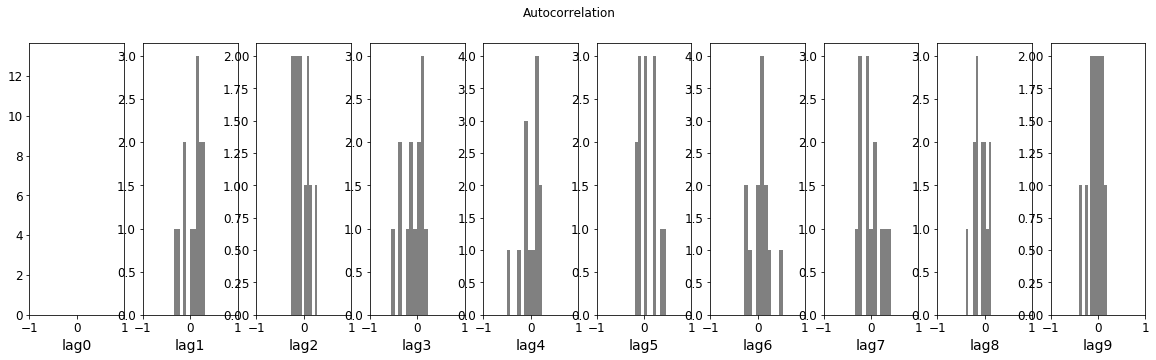

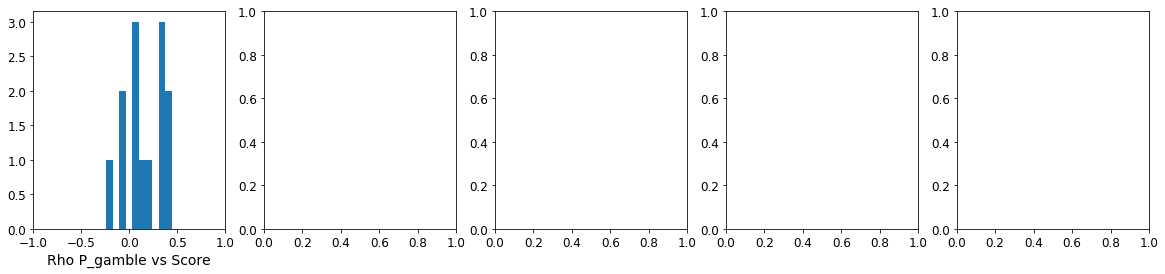

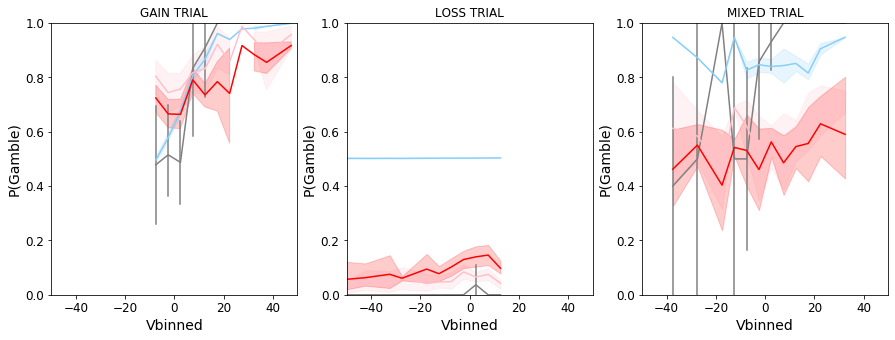

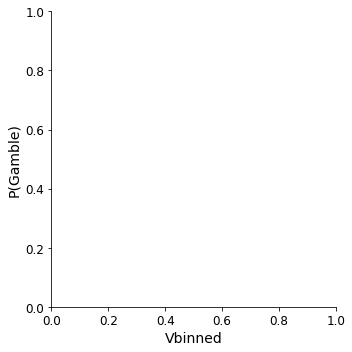

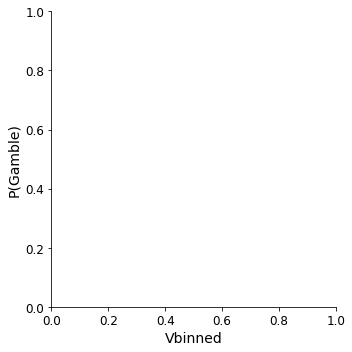

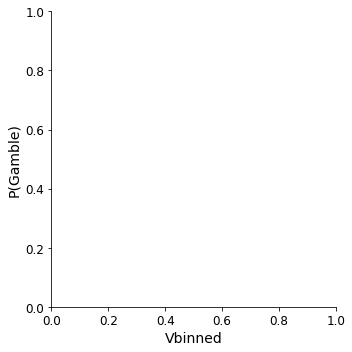

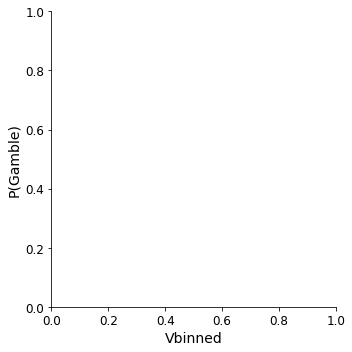

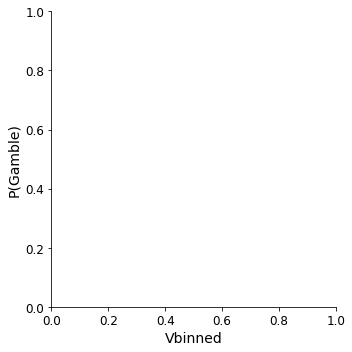

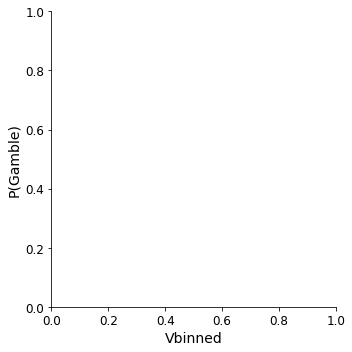

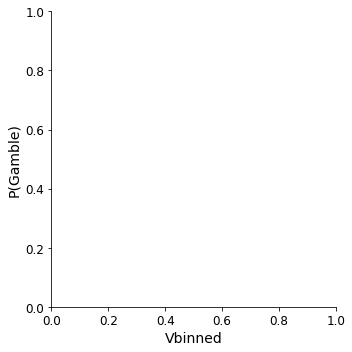

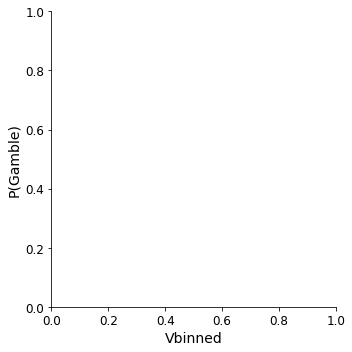

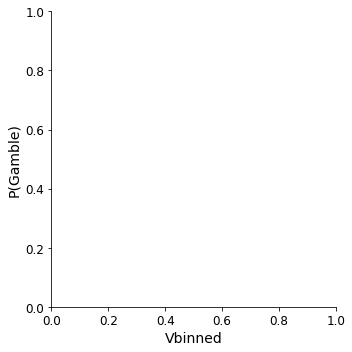

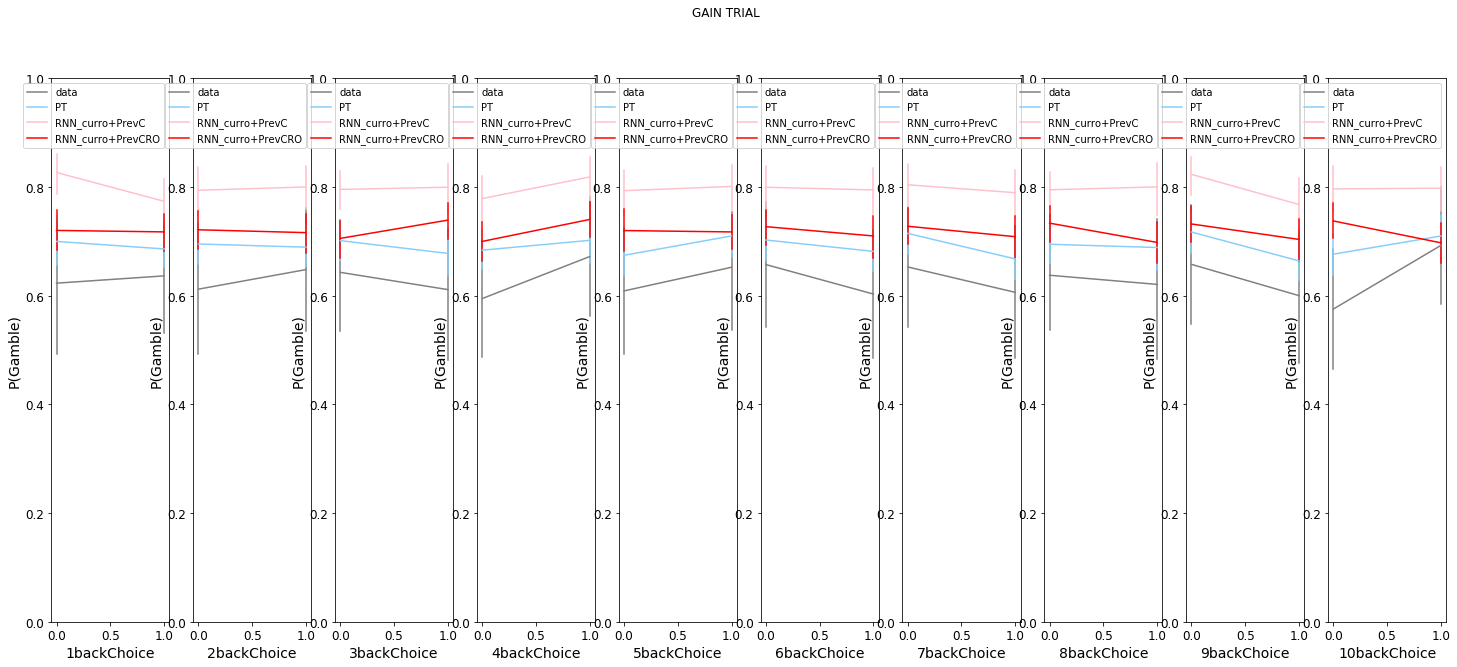

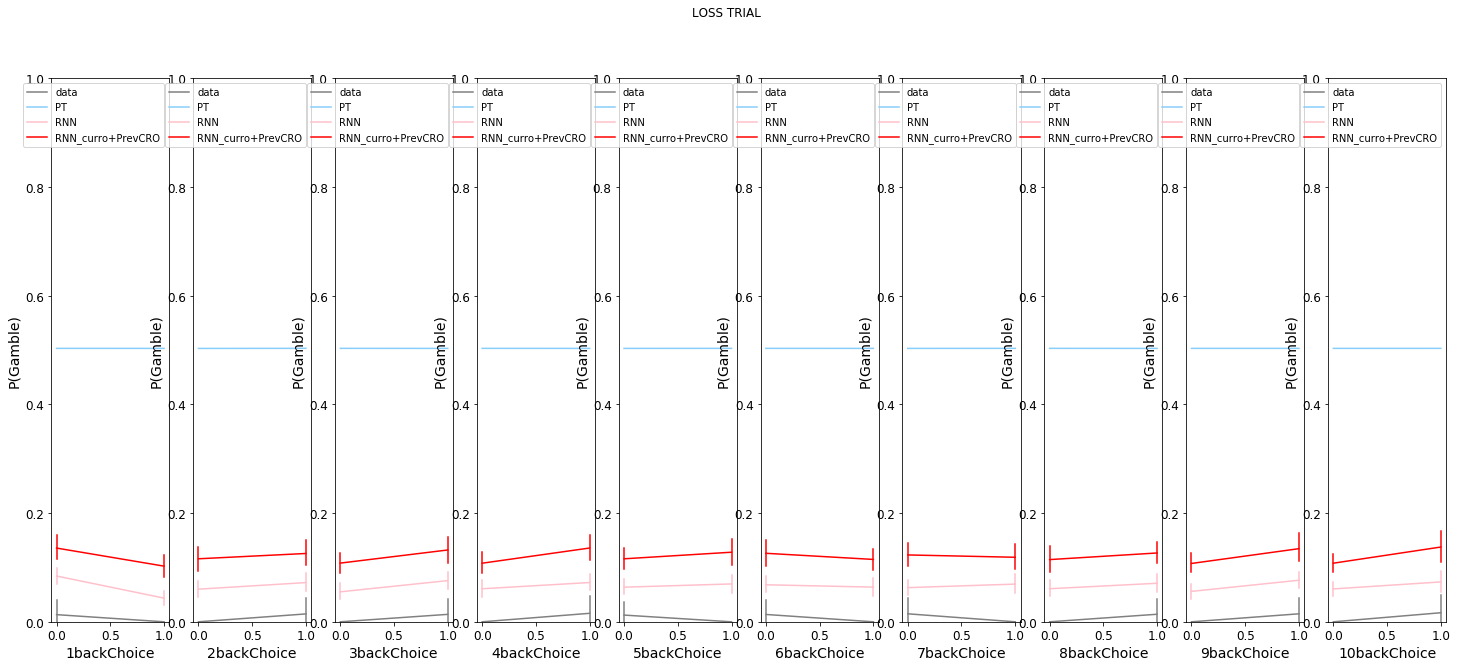

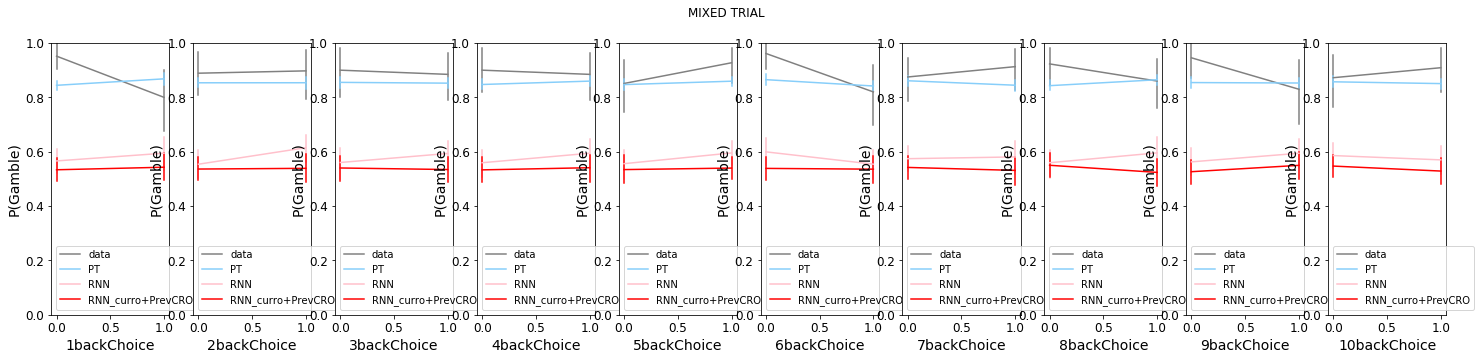

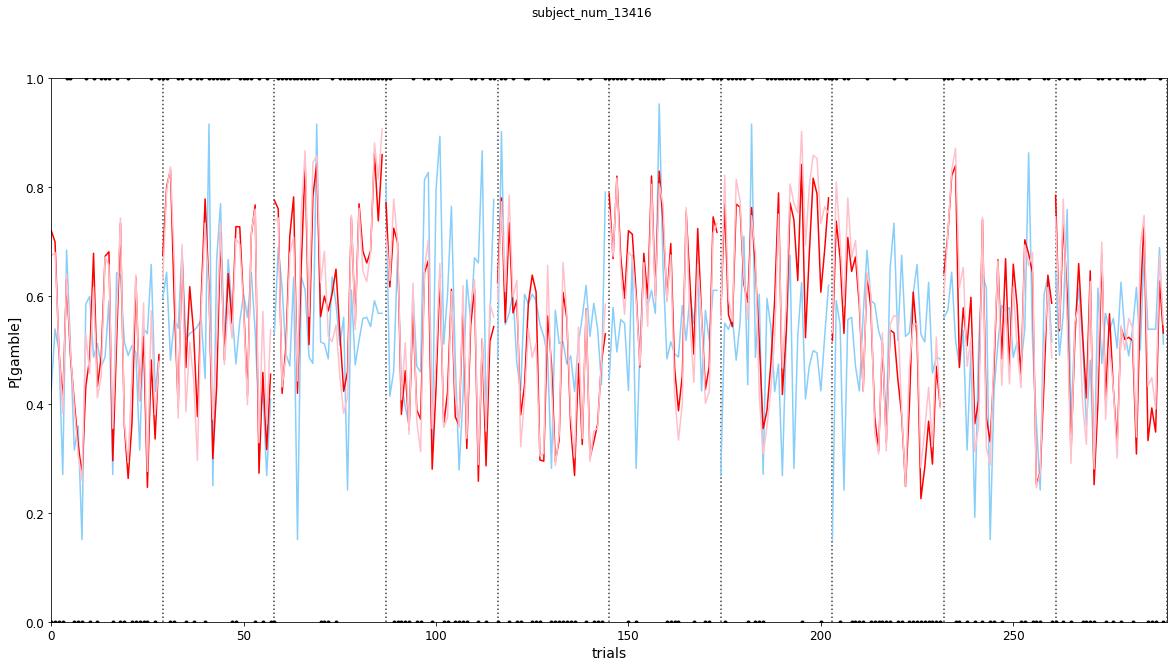

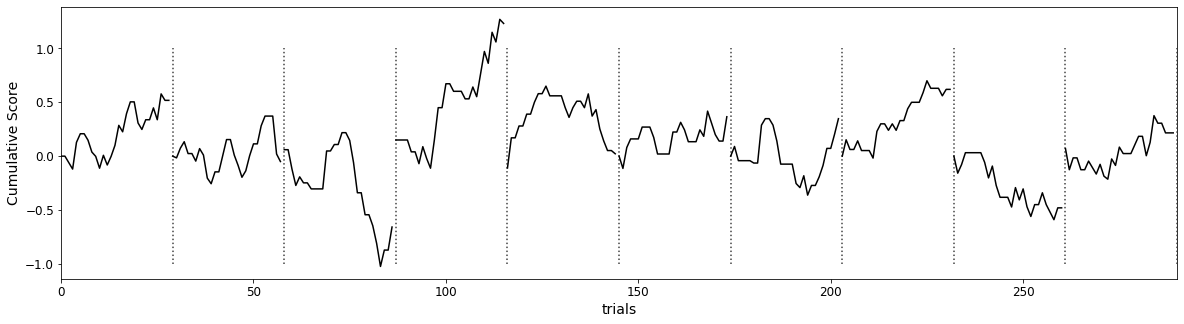

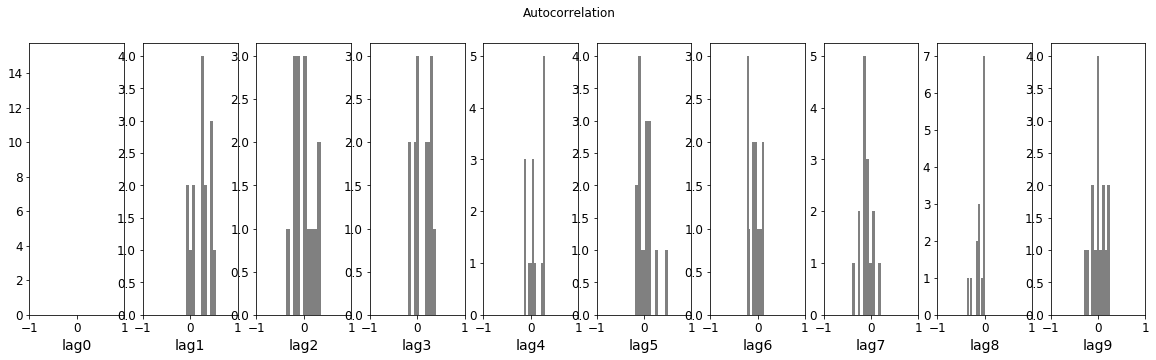

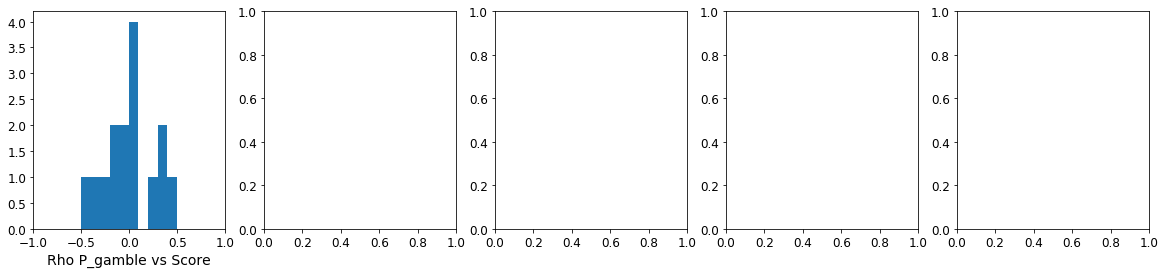

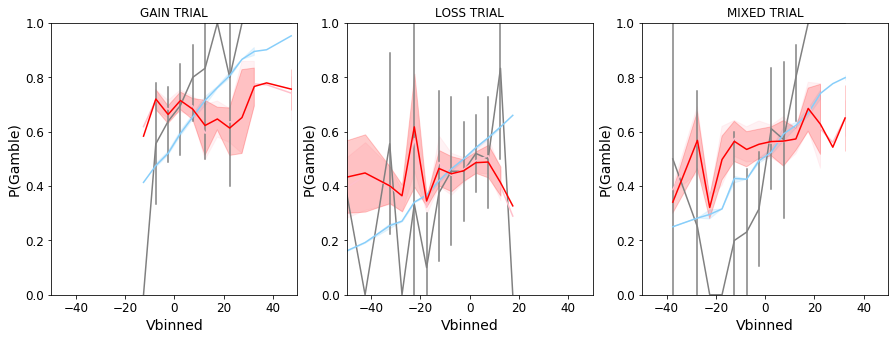

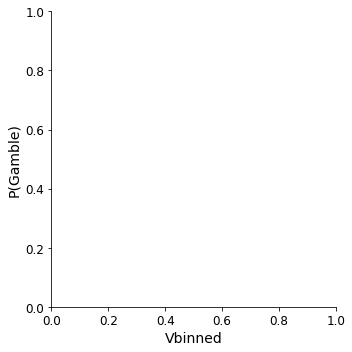

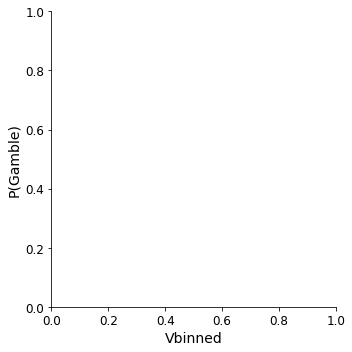

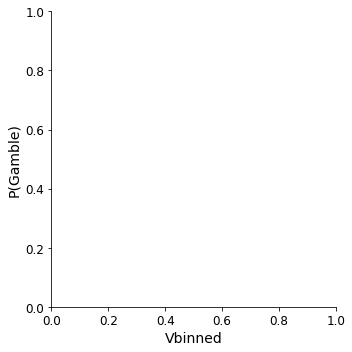

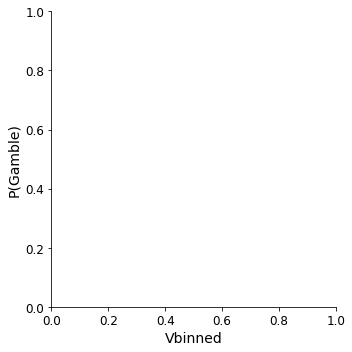

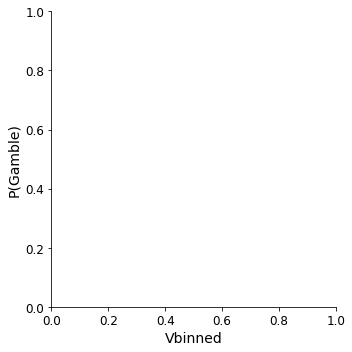

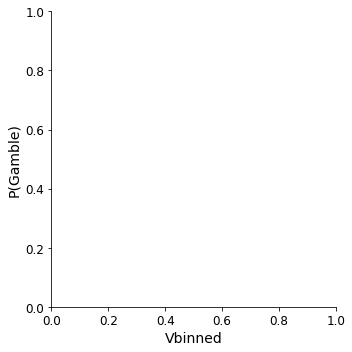

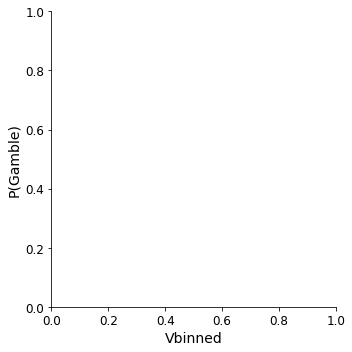

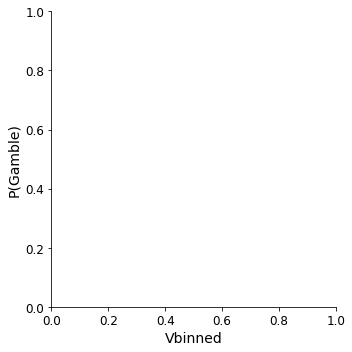

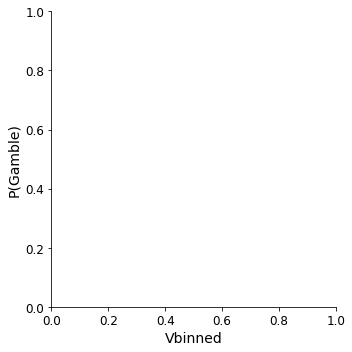

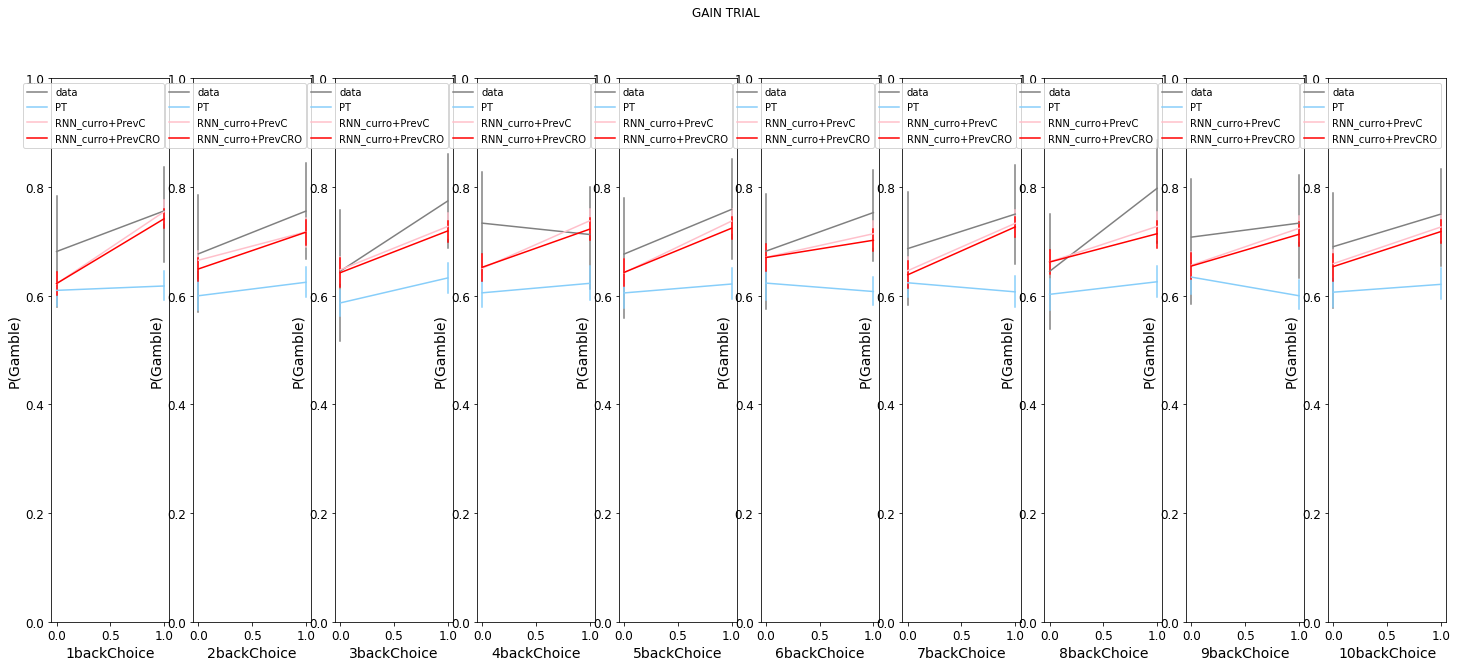

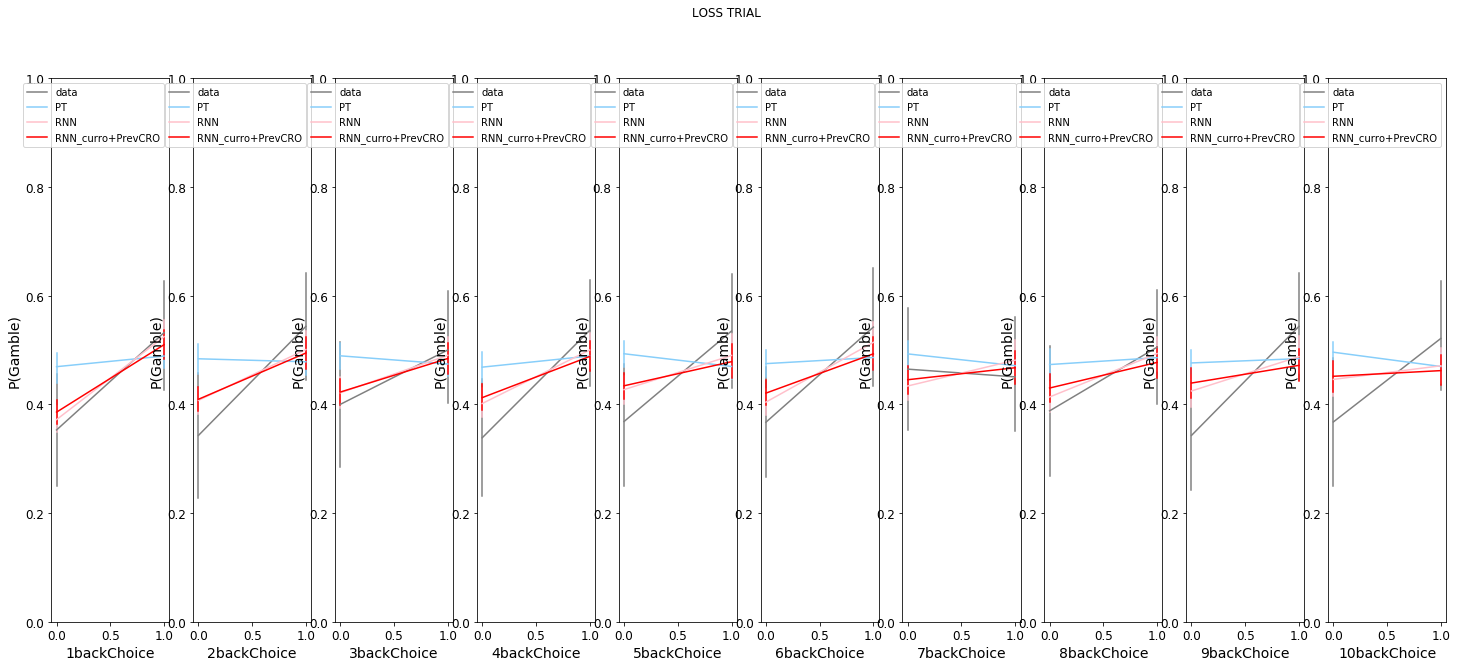

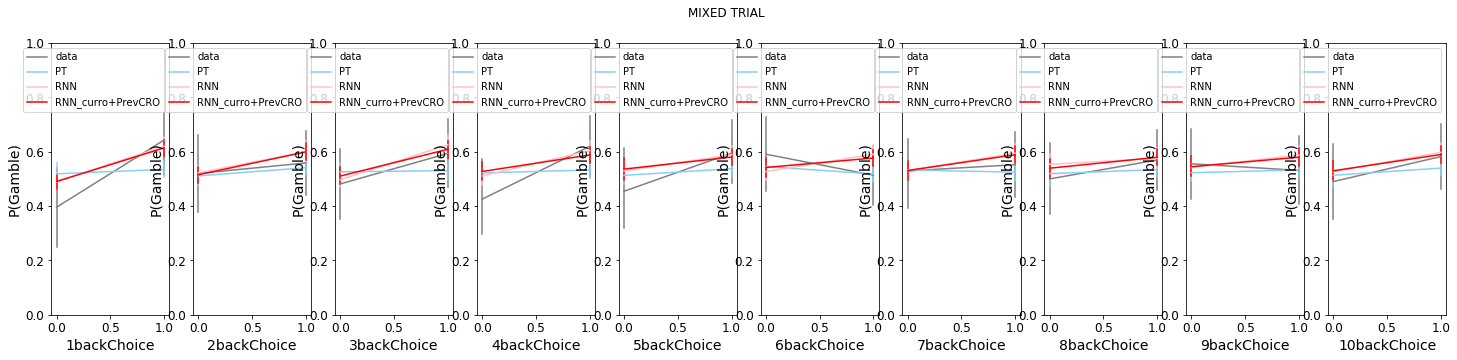

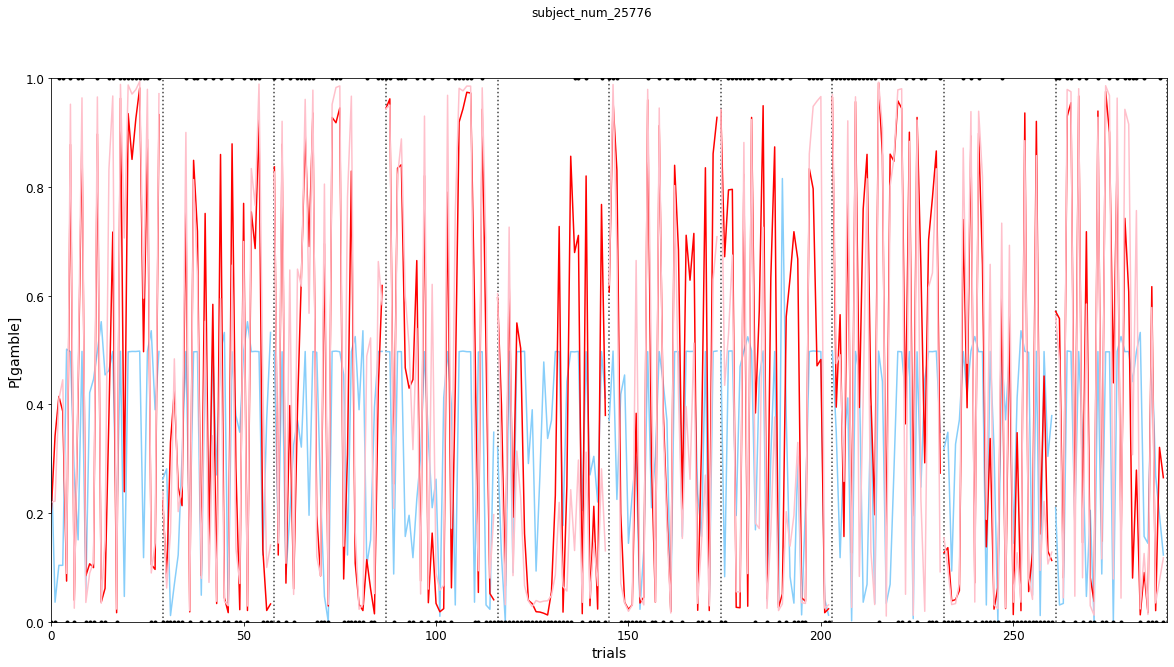

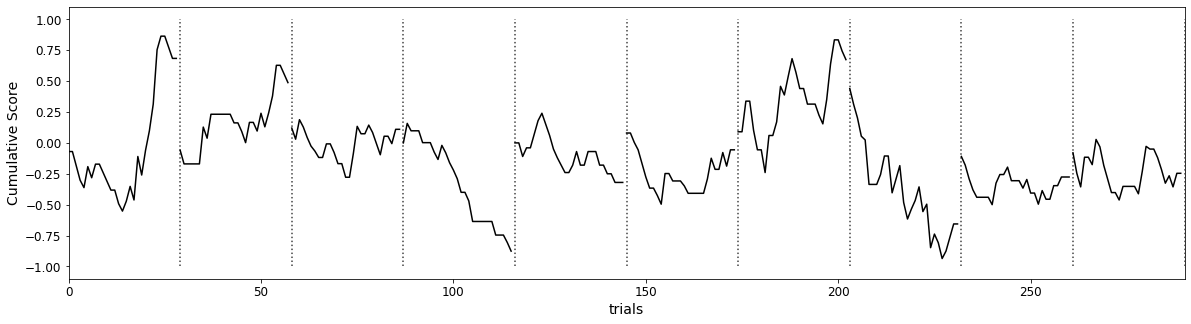

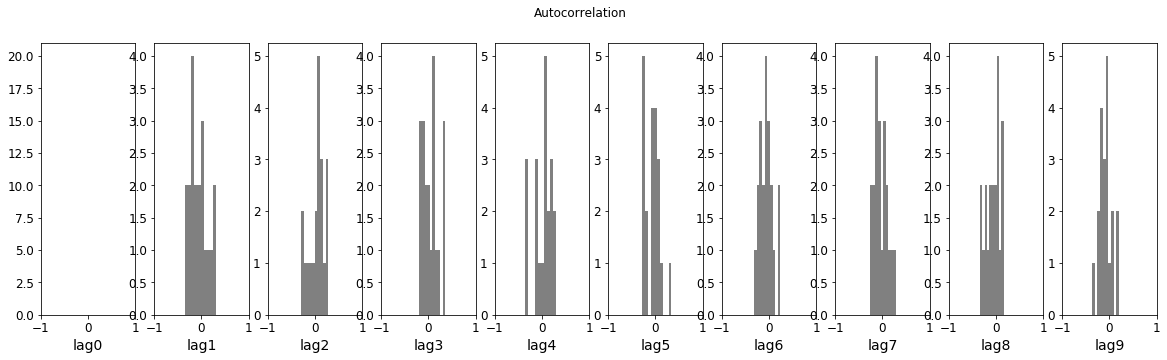

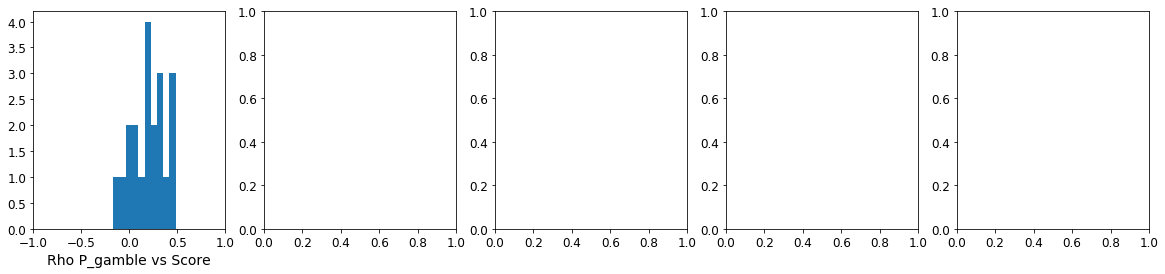

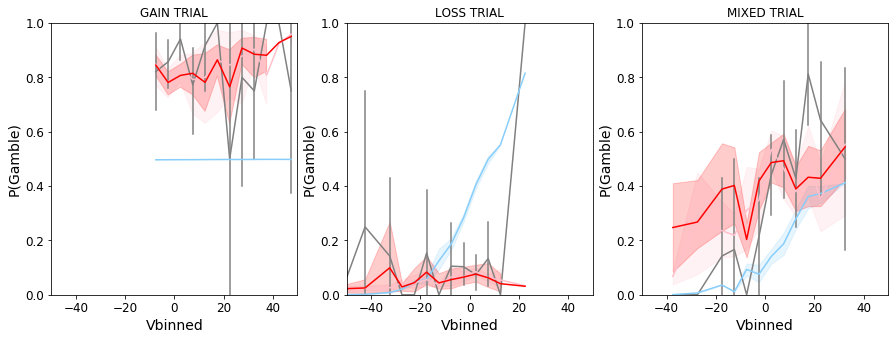

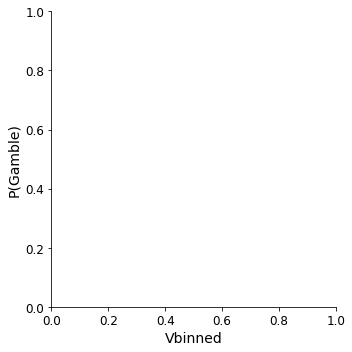

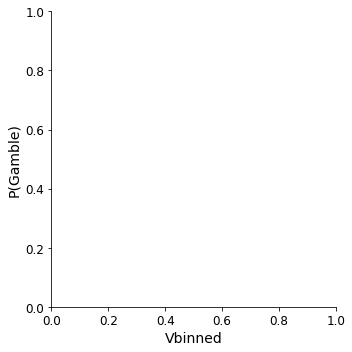

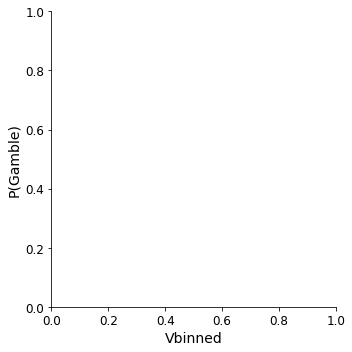

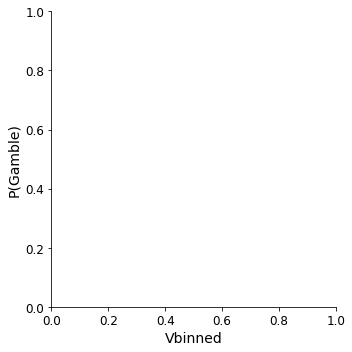

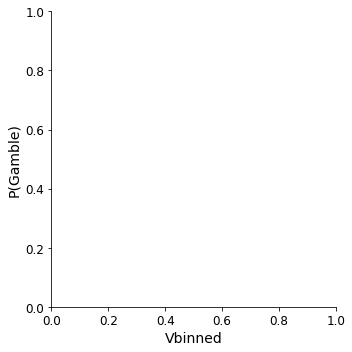

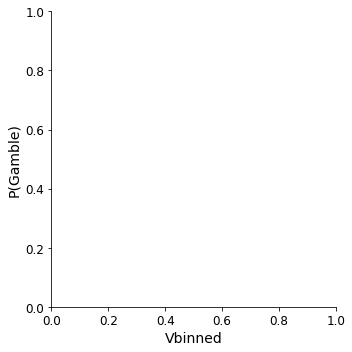

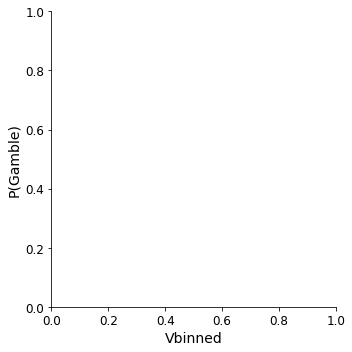

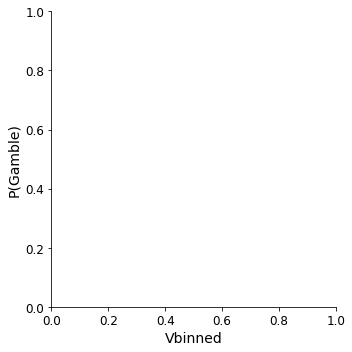

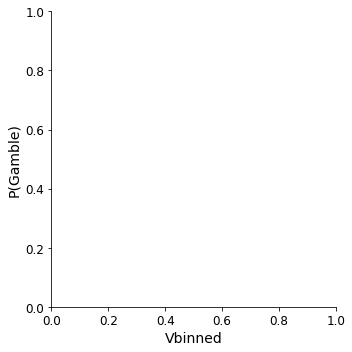

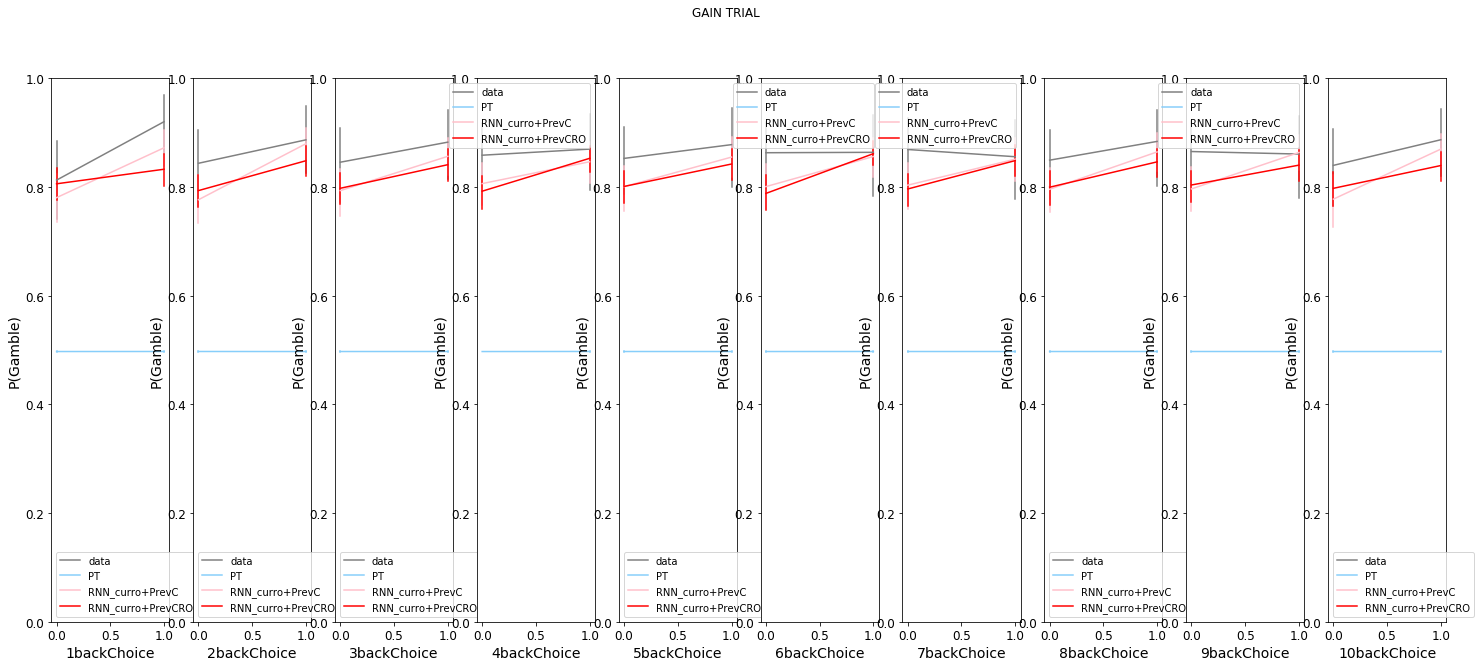

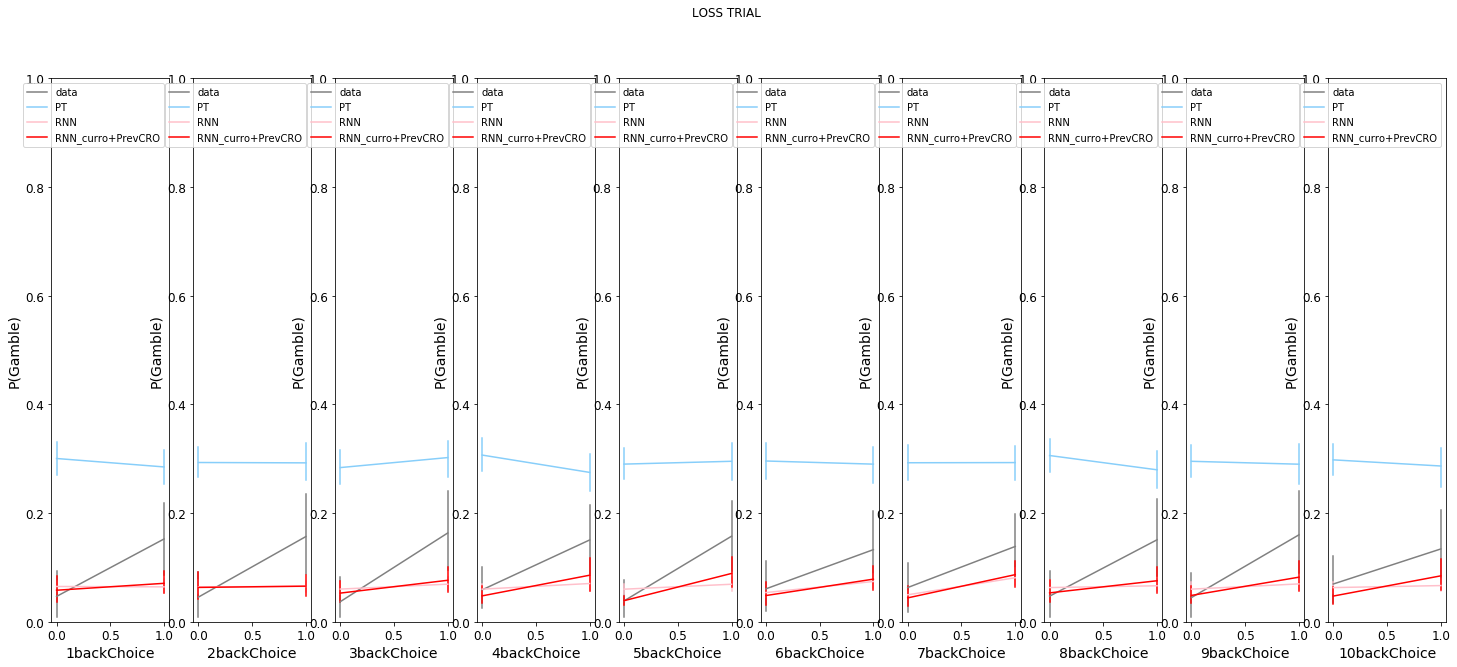

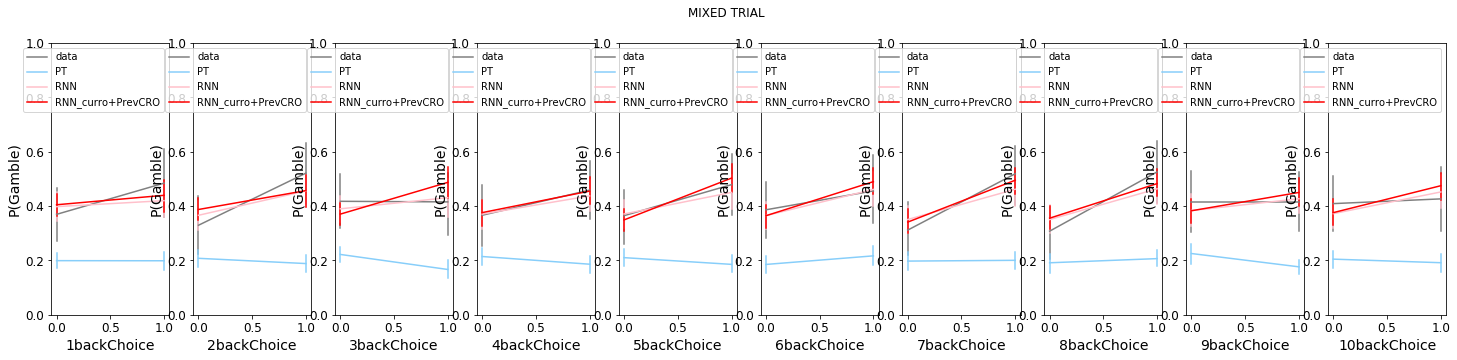

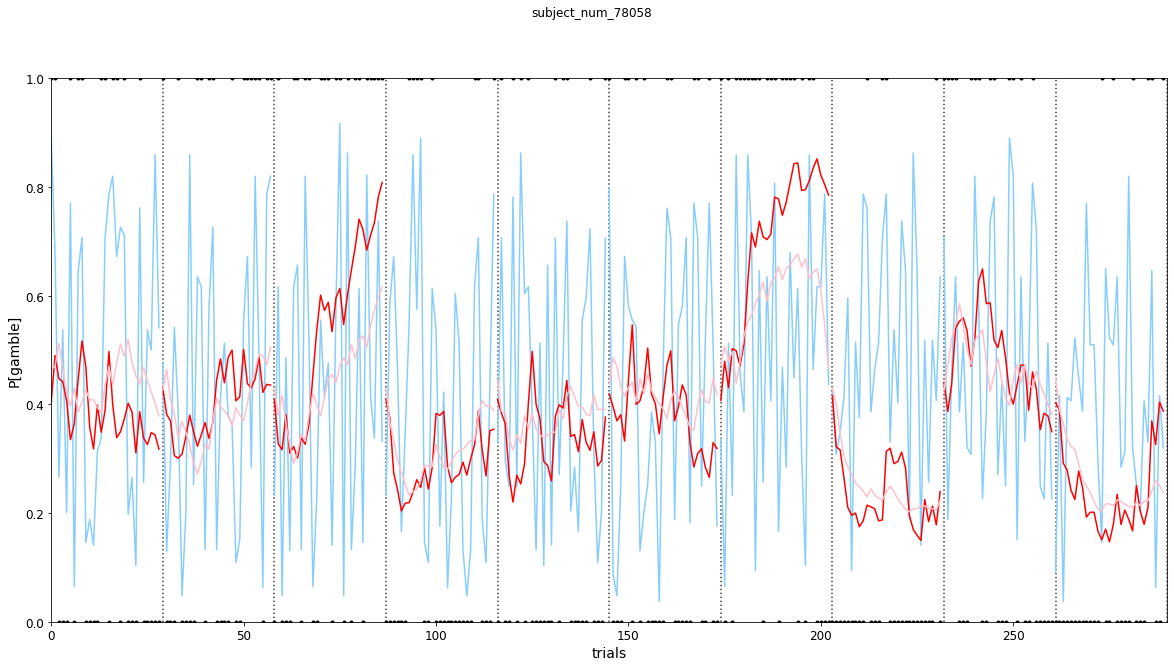

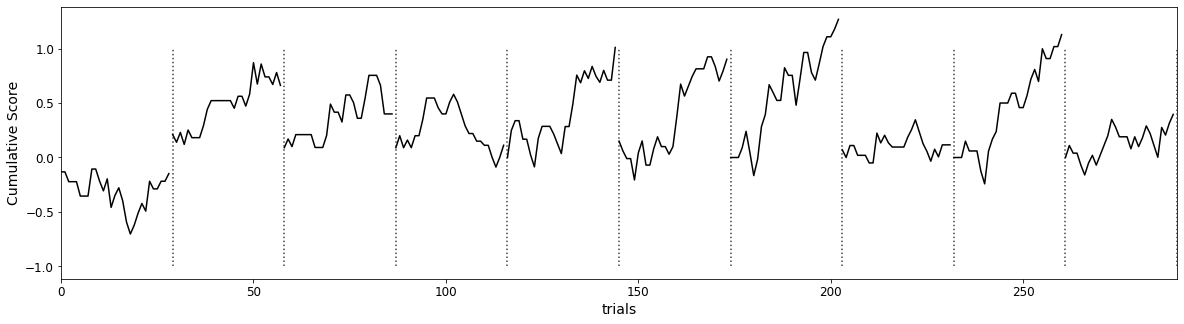

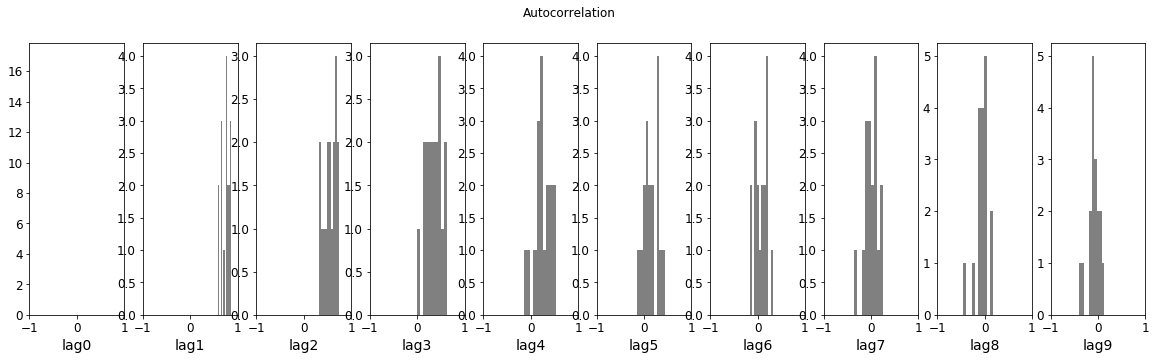

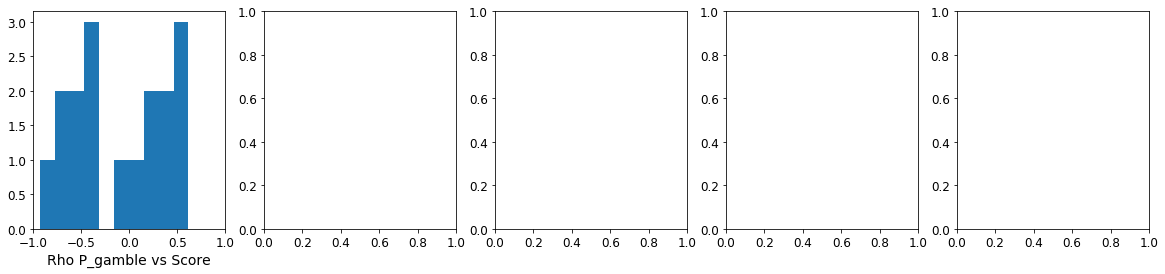

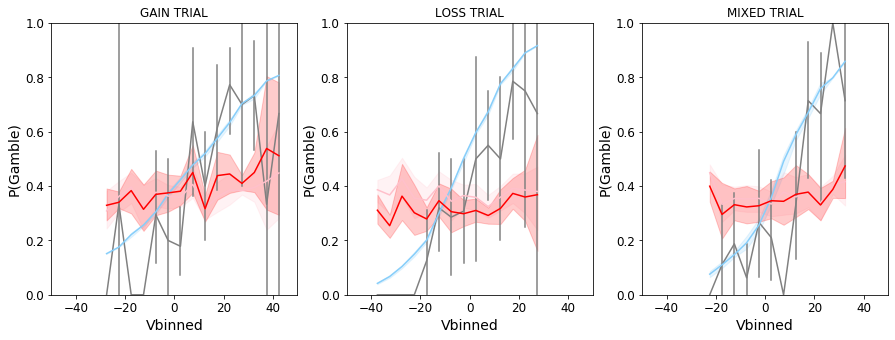

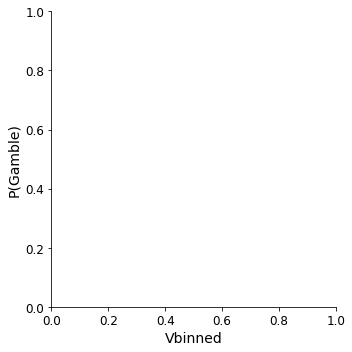

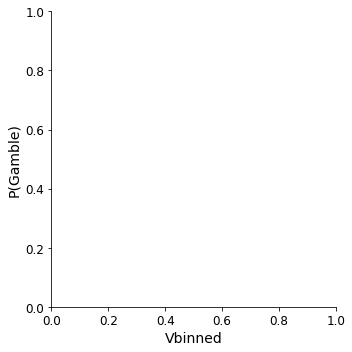

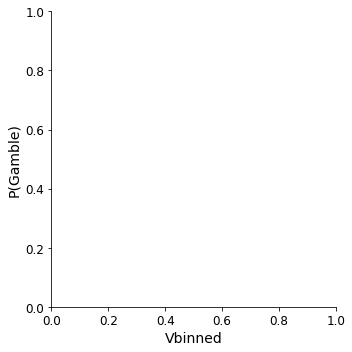

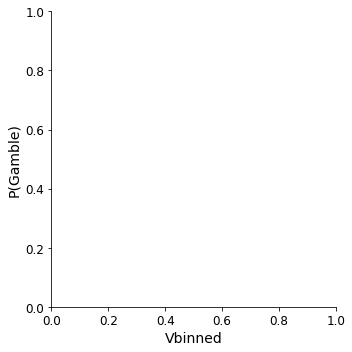

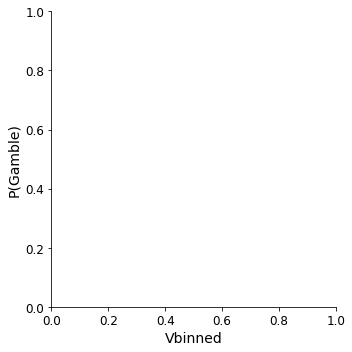

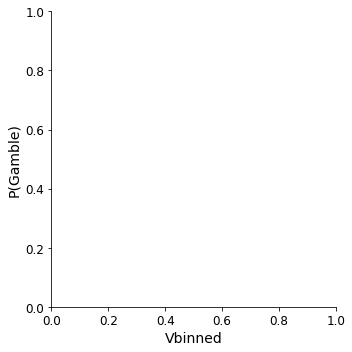

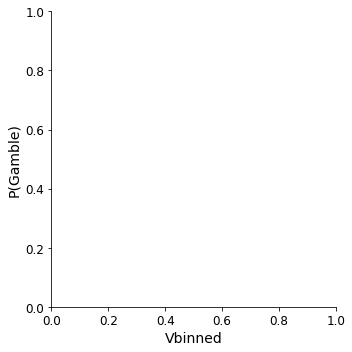

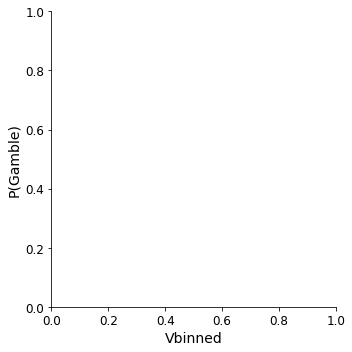

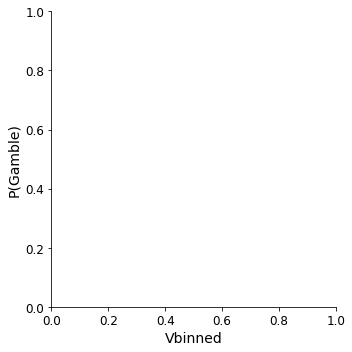

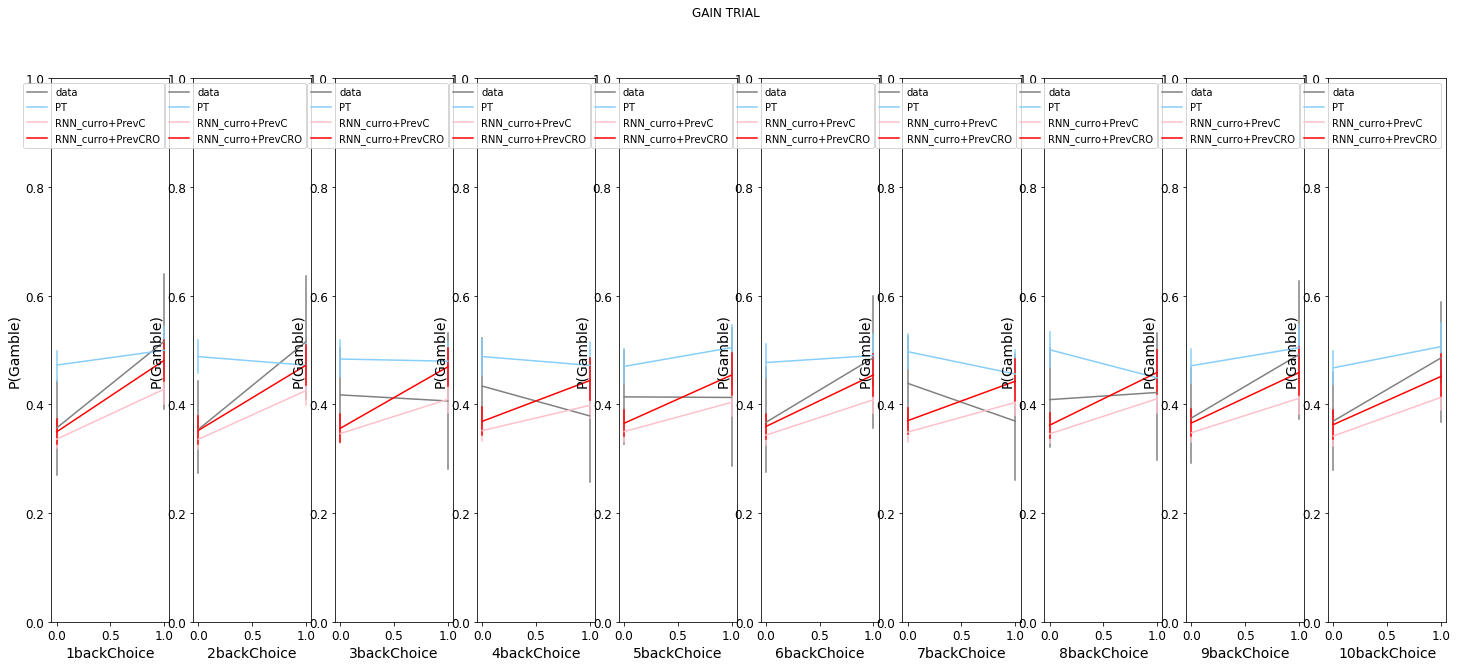

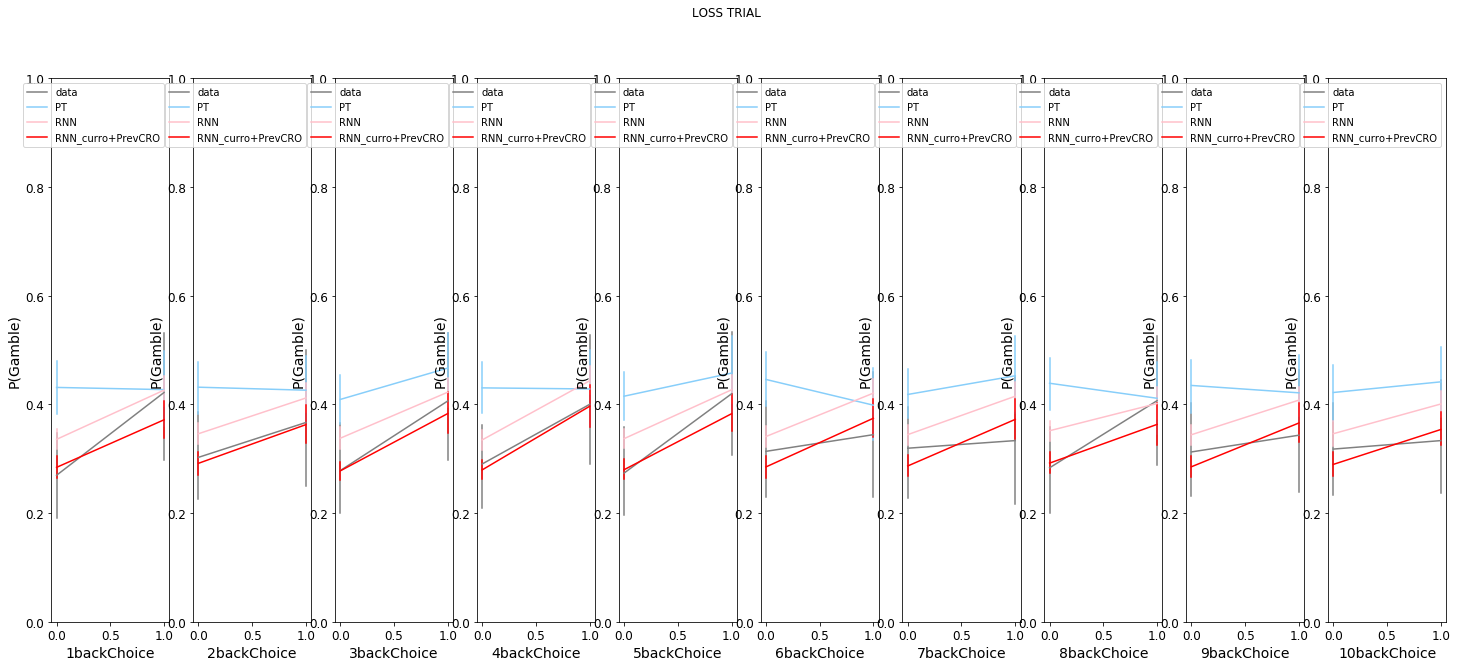

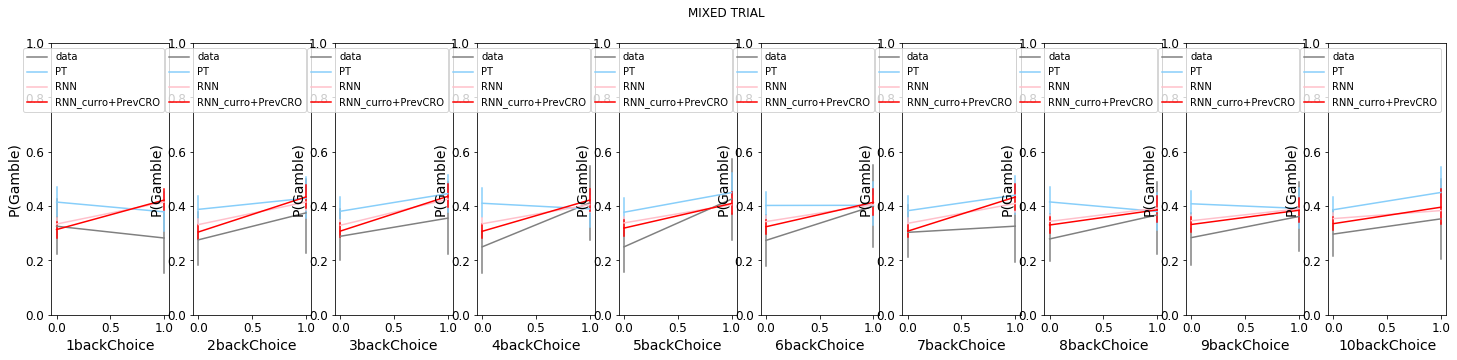

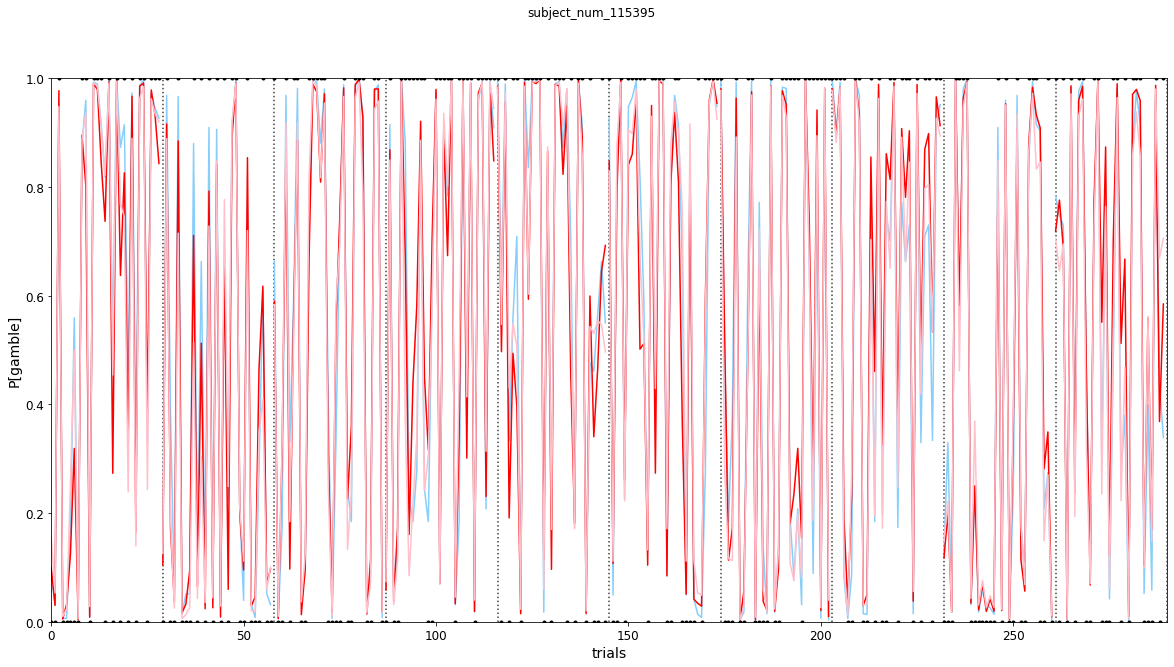

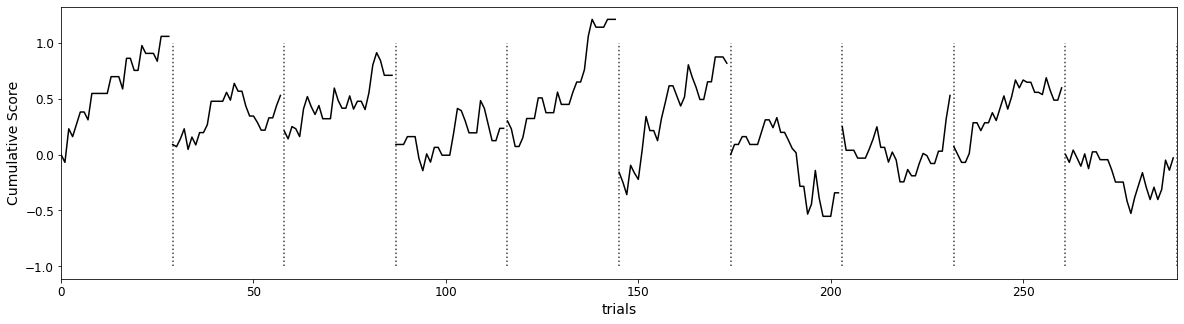

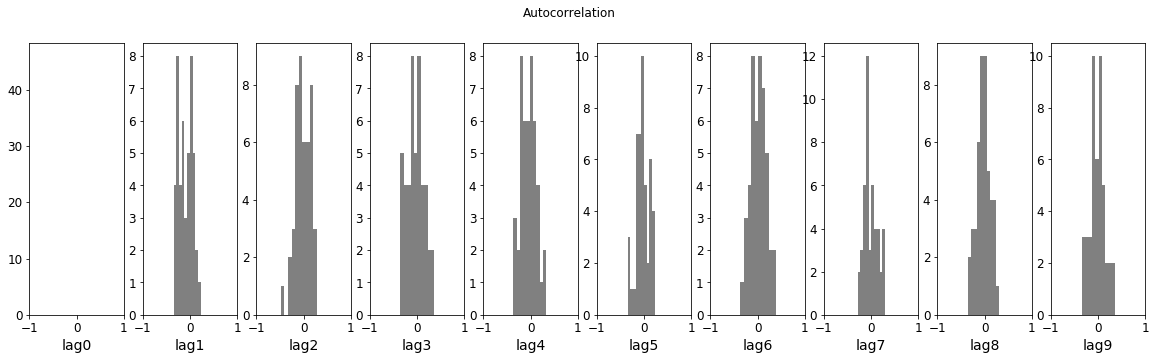

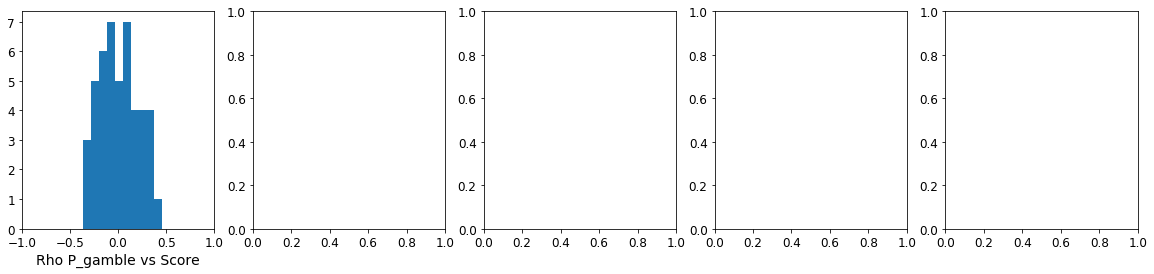

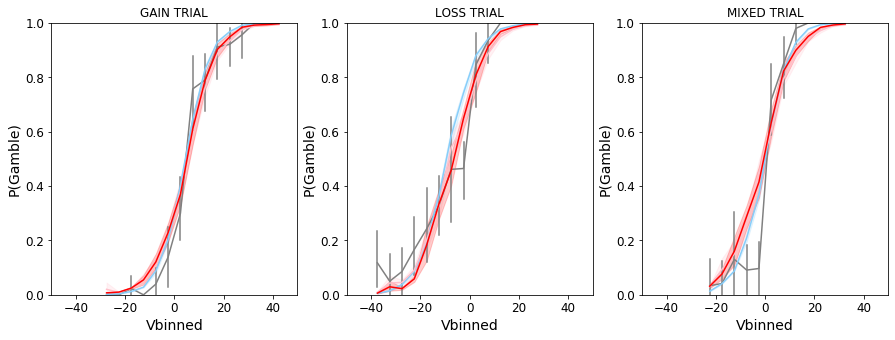

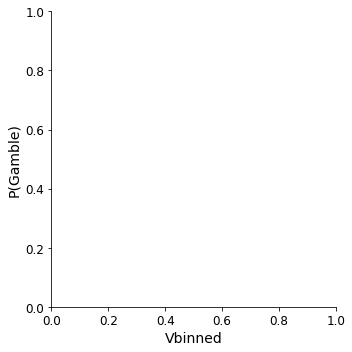

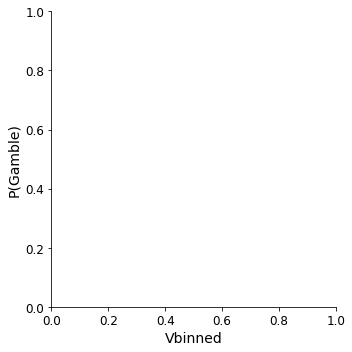

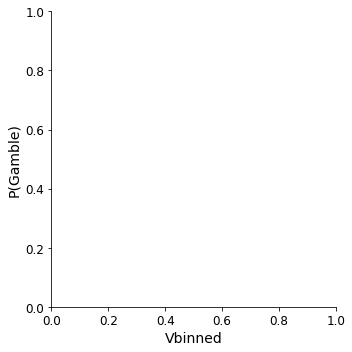

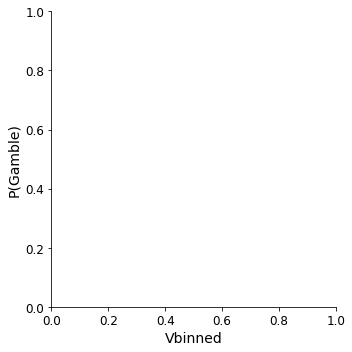

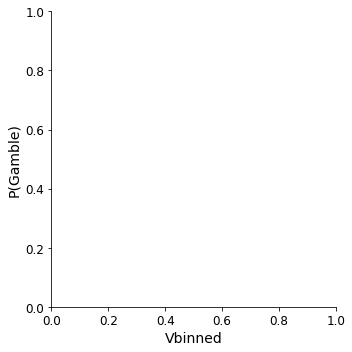

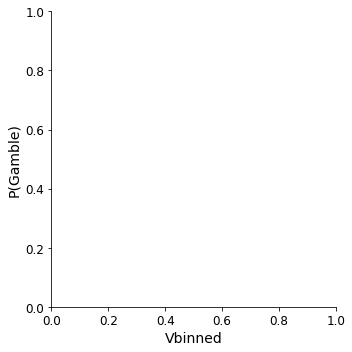

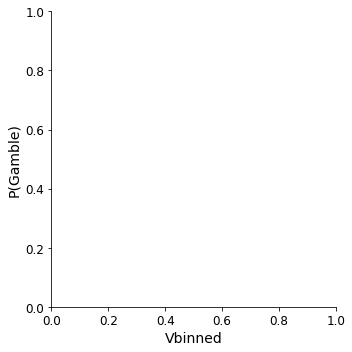

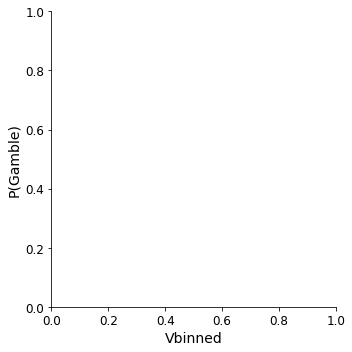

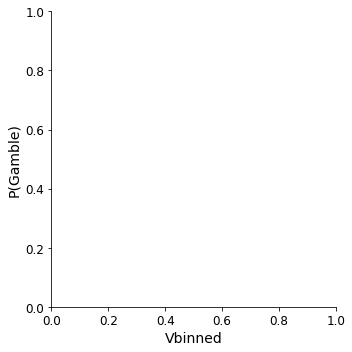

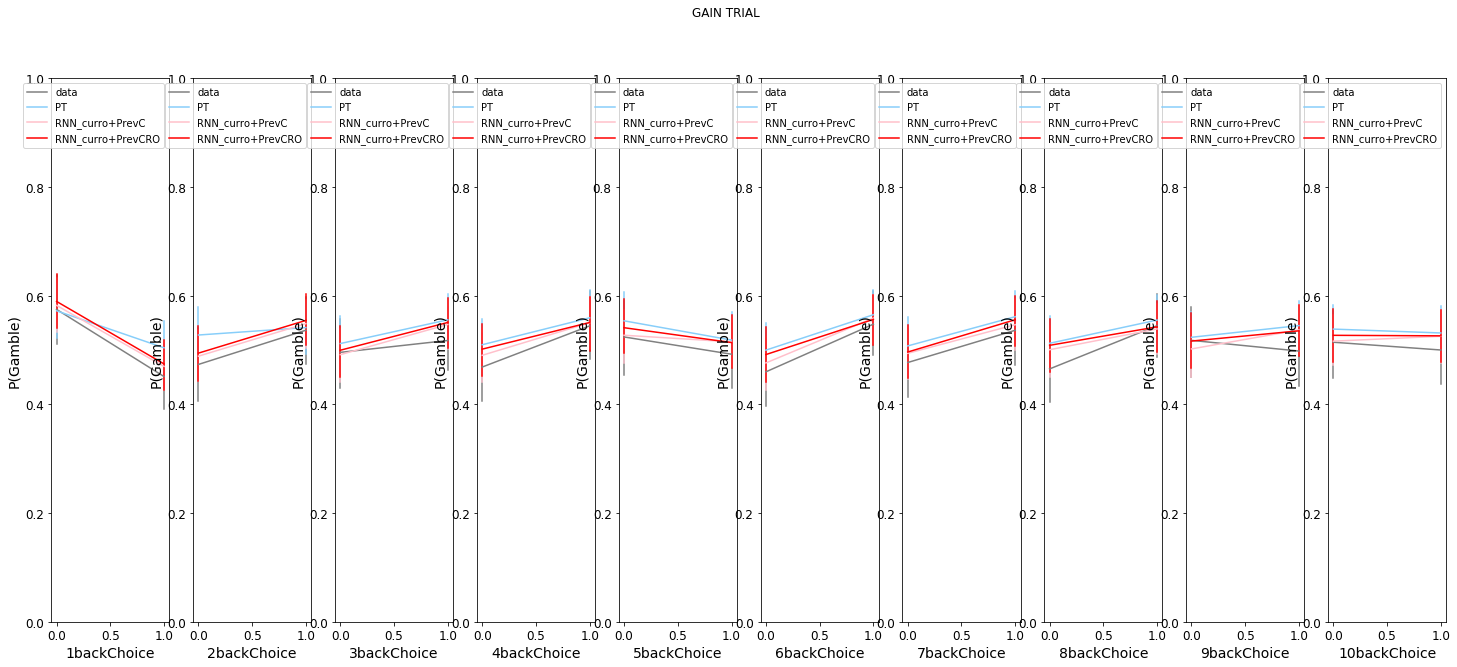

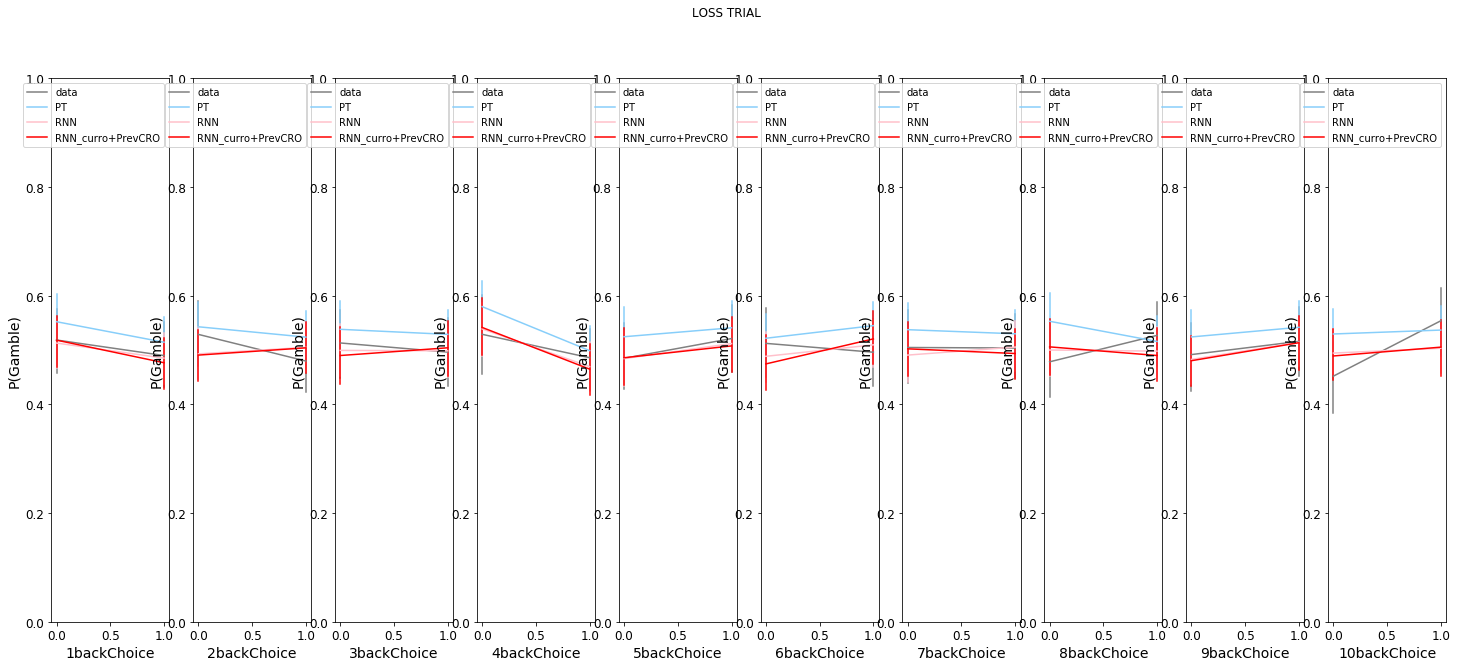

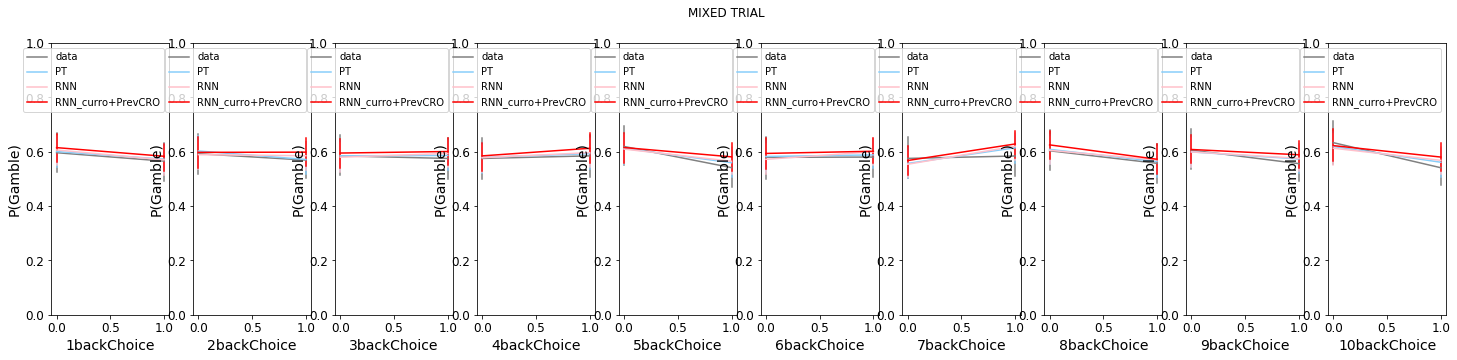

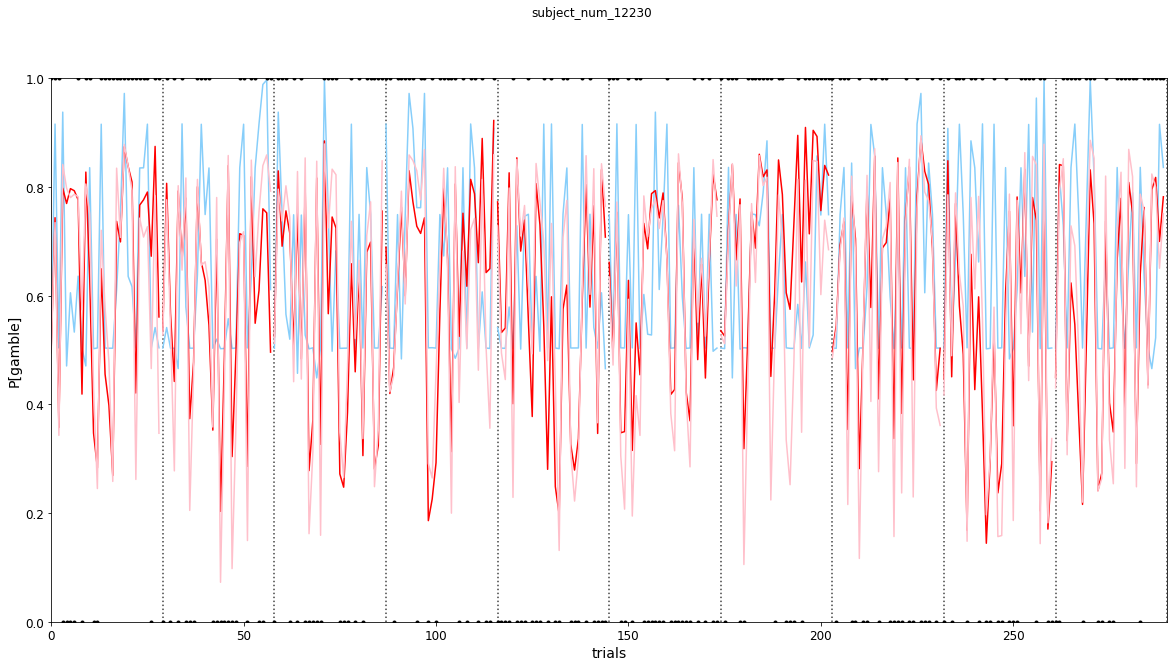

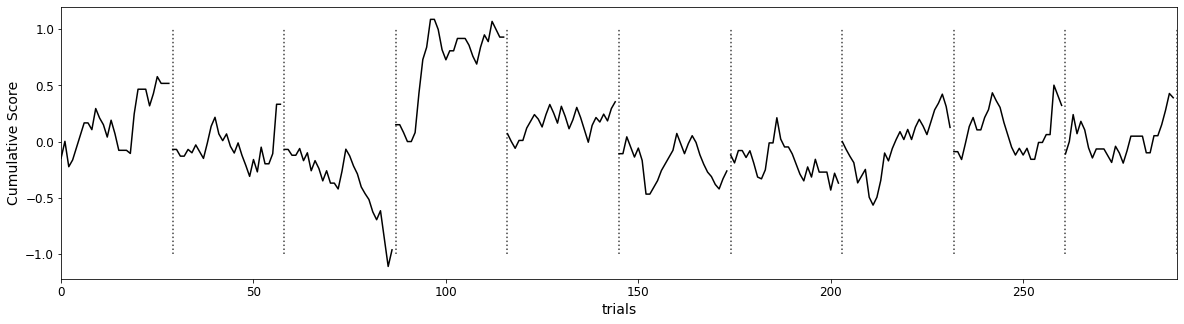

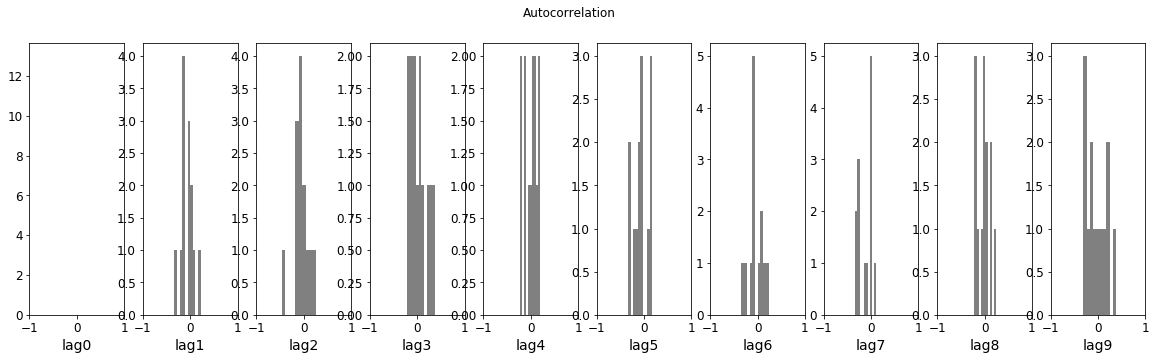

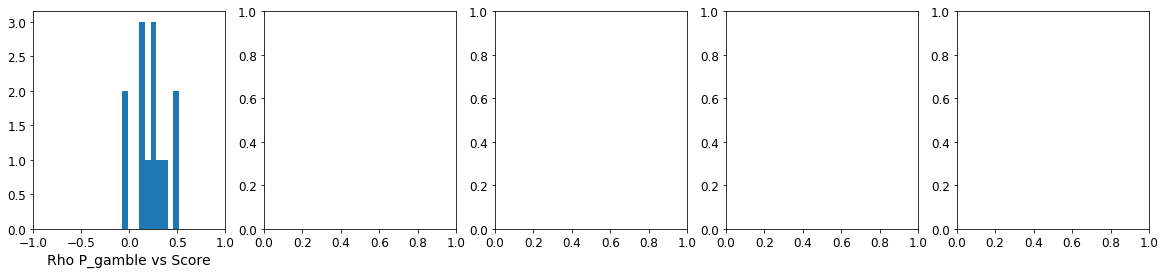

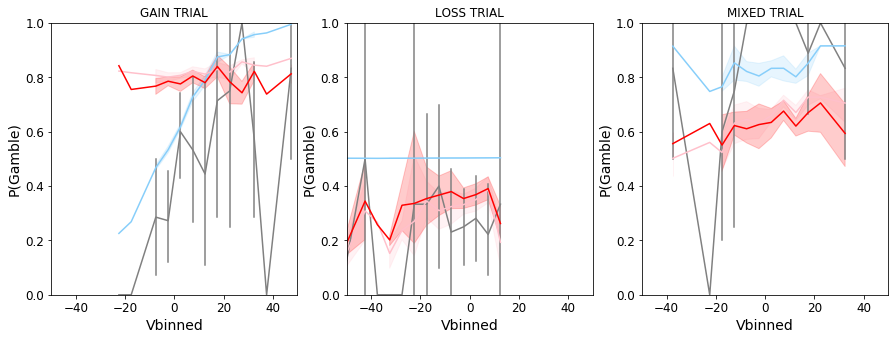

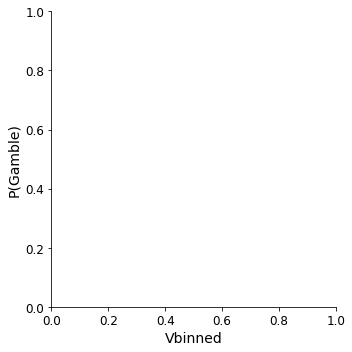

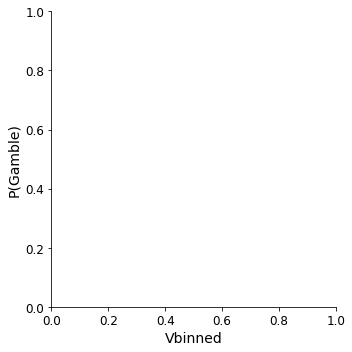

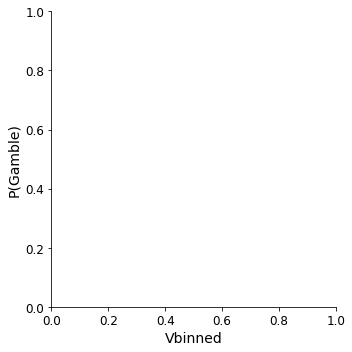

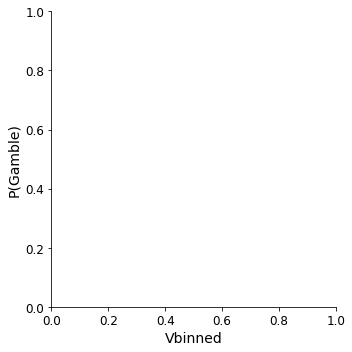

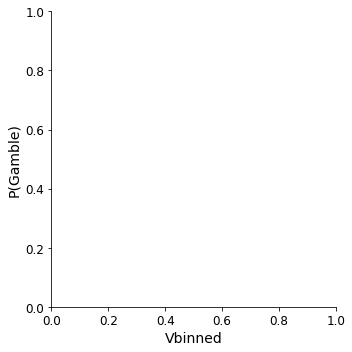

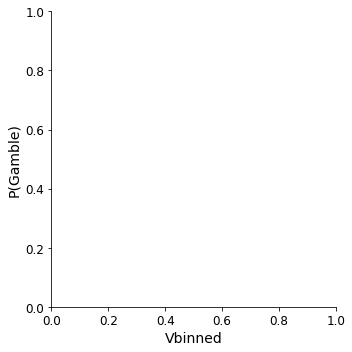

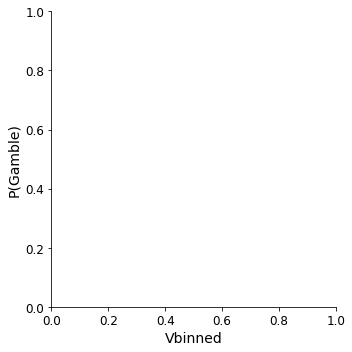

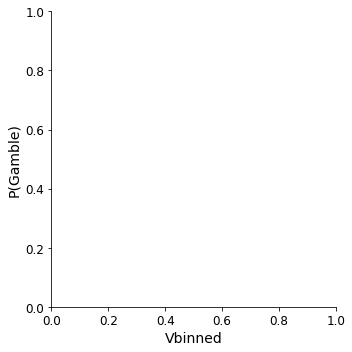

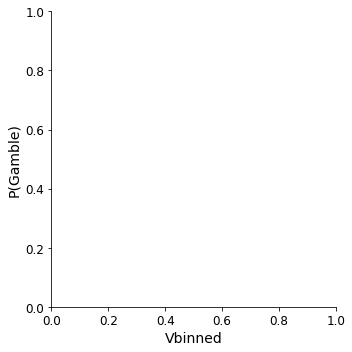

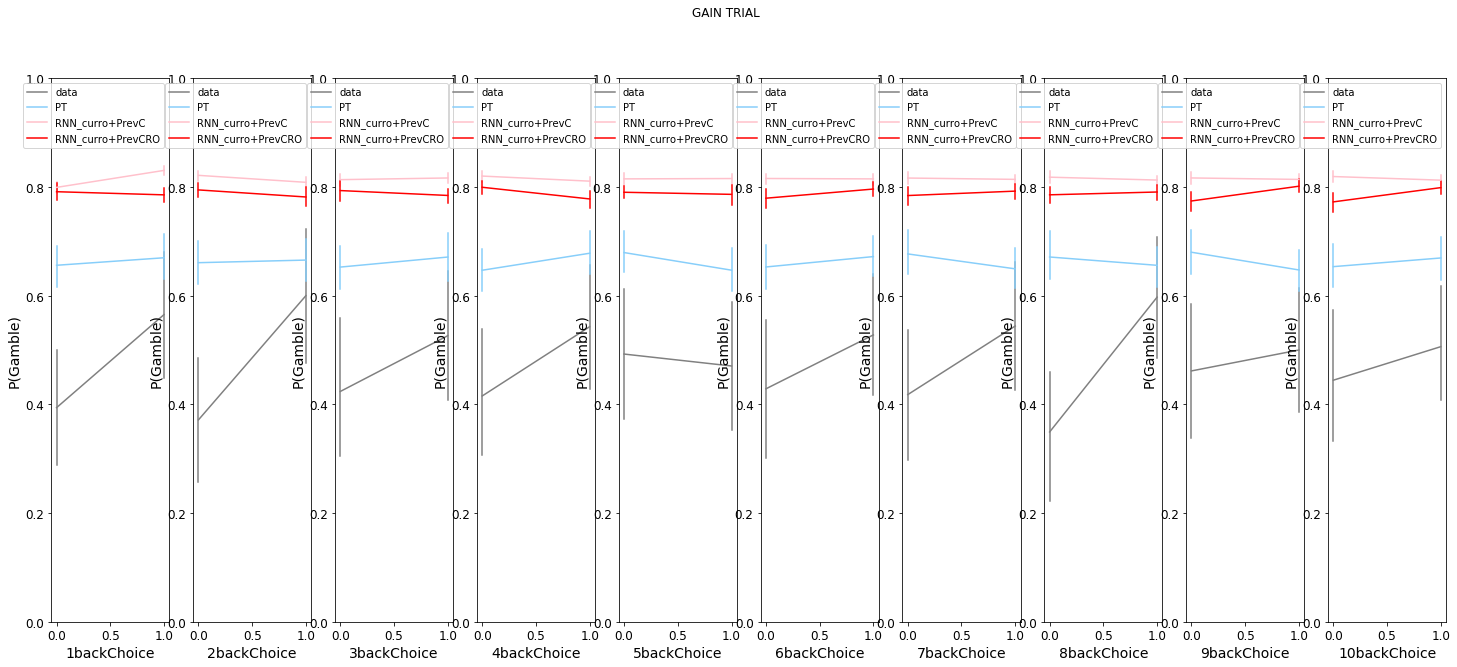

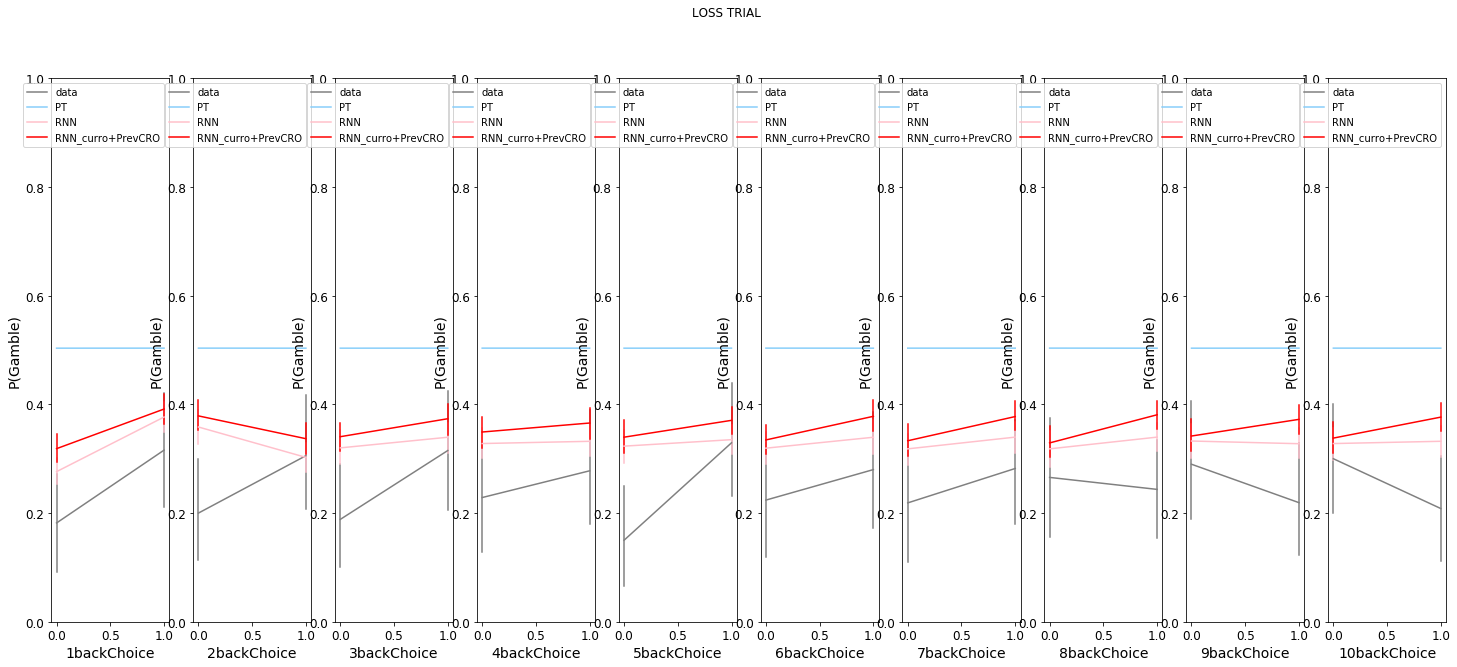

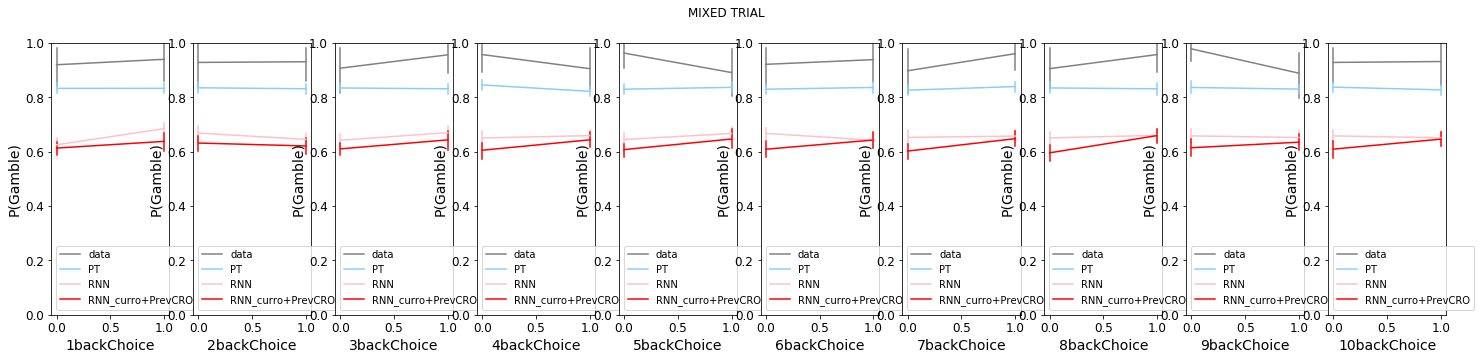

In [66]:
neurons=8

for num, subj_file_path in enumerate(subj_files_list[0:10]):
# for num, subj_file_path in enumerate([subj_files_list[0:2]
    corr_gamble_score = []; 
    
    file_path  ="/Users/ritwik7/Dropbox (Personal)/Postdoc_UCL/DATA/rlab_incomplete_rewardSWB_code/by_RN/appdata/"+ subj_file_path
#     print(num)
    Keras_file_path = file_path
    Keras_file_path = Keras_file_path + "/Play_by_play"
    
    ## RNN P(gamble) ###
    prob_test_df_currprevopts= pd.read_csv(Keras_file_path + "/prob_test_currentprevopts_neurons="+str(neurons)+".csv")
    prob_test_df_currOprevRC= pd.read_csv(Keras_file_path + "/prob_test_currOprevRC_neurons="+str(neurons)+".csv")

    prob_test_df_currOprevC= pd.read_csv(Keras_file_path + "/prob_test_currOprevC_neurons="+str(neurons)+".csv")
    prob_test_df_currOprevR= pd.read_csv(Keras_file_path + "/prob_test_currOprevR_neurons="+str(neurons)+".csv")


    prob_test_df_currO= pd.read_csv(Keras_file_path + "/prob_test_currO_neurons="+str(neurons)+".csv")

    
    ### PT ####
    probchoice_test_df = pd.DataFrame(pd.read_csv(Keras_file_path + "/PT_probchoice_test_50_split_combined_1sthalf.csv").values.reshape(-1,29))
    
    
    
    ### DATA ###
    test_data_df = pd.read_csv(Keras_file_path + "/test_data.csv")
    
    
    plt.figure(figsize=(20,10))
    for ep in range(0,10): 
        
        plt.plot(np.arange(ep*29,(ep+1)*29), probchoice_test_df.iloc[ep,:],linestyle="solid",color="lightskyblue",label="PT")

        plt.plot(np.arange(ep*29,(ep+1)*29), prob_test_df_currprevopts.iloc[ep,1:], color="red",label="RNN CurrO+prevRCO")
#         plt.plot(np.arange(ep*29,(ep+1)*29), prob_test_df_currOprevRC.iloc[ep,1:],linestyle="dashed",color="red",label = "RNN Curro+prevRC")
    
#         plt.plot(np.arange(ep*29,(ep+1)*29), prob_test_df_currOprevR.iloc[ep,1:],linestyle="dashed",color="magenta",label = "RNN Curro+prevR")
        plt.plot(np.arange(ep*29,(ep+1)*29), prob_test_df_currOprevC.iloc[ep,1:],linestyle="solid",color="pink",label = "RNN Curro+prevC")

#         plt.plot(np.arange(ep*29,(ep+1)*29), prob_test_df_currO.iloc[ep,1:],linestyle="dotted",color="red",label = "RNN Curro")
        


        plt.plot(test_data_df.iloc[ep*29:(ep+1)*29].Choice,marker='.',color='black',linestyle='none')
#         plt.plot([ [(ep+1)*29,0],[(ep+1)*29,1] ],color='black',alpha=0.75, zorder=0)
        plt.plot([(ep+1)*29,(ep+1)*29],[0,1],color='black',alpha=0.75, zorder=0,linestyle="dotted")


#     prob_test_df.iloc[:,1:].mean().plot(color="black",linewidth=2)
    plt.ylim([0,1])
    plt.xlabel('trials')
    plt.ylabel('P[gamble]')
    plt.ylim([0,1])
    plt.suptitle(subj_file_path)
    
    plt.xlim([0,29*10])
#     plt.legend(loc=0)
    
    plt.figure(figsize=(20,5))
    for ep in range(0,10):
        plt.plot(np.arange(ep*29,(ep+1)*29), test_data_df.iloc[ep*29:(ep+1)*29].Outcome.cumsum()/500, color="black",label = "Cumulative score")
        plt.plot([(ep+1)*29,(ep+1)*29],[-1,1],color='black',alpha=0.75, zorder=0,linestyle="dotted")

    
    plt.xlabel('trials')
    plt.ylabel('Cumulative Score')
    plt.xlim([0,29*10])
    
    
    acf_lag=np.empty([prob_test_df_currO.shape[0],10])
    
    for ep in range(0, prob_test_df_currO.shape[0]):

            corr_gamble_score.append(sc_stats.spearmanr(test_data_df.iloc[ep*29:(ep+1)*29].Outcome.cumsum(), prob_test_df_currOprevC.iloc[ep,1:])[0])
            
            acf_lag[ep,:] = acf(prob_test_df_currOprevC.iloc[ep,1:])[0:10]
    
    
    ### AUTOCORRELATIONS
    fig,ax = plt.subplots(nrows=1, ncols=10, figsize=(20,5))
    for lag in range(0,10):
        ax[lag].hist(acf_lag[:,lag], color ="gray"); ax[lag].set_xlim([-1,1]); ax[lag].set_xlabel("lag"+ str(lag)); plt.suptitle("Autocorrelation")
    
    
    ## CORR P(GAMBLE) vs CUM SCORE PER PLAY
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
    ax[0].hist(corr_gamble_score); ax[0].set_xlabel("Rho P_gamble vs Score"); ax[0].set_xlim([-1,1])


    
    
    
    ##### P(GAMBLE) STATICS ##########
    
    
    gain_locs = test_data_df.loc[test_data_df.Safe>0].index
    loss_locs = test_data_df.loc[test_data_df.Safe<0].index ## Loss Trials
    mixed_locs = test_data_df.loc[test_data_df.Safe==0].index ## MIxed trials
    
    
    data_gain_df = pd.DataFrame(columns = ["P(Gamble)","Vdiff","Vbinned","Choice"])
    data_gain_df["Vdiff"] = 0.5*(test_data_df.loc[gain_locs].BigRisky + test_data_df.loc[gain_locs].SmallRisky)  - test_data_df.loc[gain_locs].Safe
    data_gain_df["Vbinned"] = np.arange(-52.5,52.5,5)[np.digitize(data_gain_df['Vdiff'],bins=np.arange(-50,50,5))]
    data_gain_df["Choice"]=test_data_df.loc[gain_locs].Choice
    
    
    
    

    
    
    data_loss_df = pd.DataFrame(columns = ["P(Gamble)","Vdiff","Vbinned","Choice"])
    data_loss_df["Vdiff"] = 0.5*(test_data_df.loc[loss_locs].BigRisky + test_data_df.loc[loss_locs].SmallRisky)  - test_data_df.loc[loss_locs].Safe
    data_loss_df["Vbinned"] = np.arange(-52.5,52.5,5)[np.digitize(data_loss_df['Vdiff'],bins=np.arange(-50,50,5))]
    data_loss_df["Choice"]=test_data_df.loc[loss_locs].Choice
    
    
    data_mixed_df = pd.DataFrame(columns = ["P(Gamble)","Vdiff","Vbinned","Choice"])
    data_mixed_df["Vdiff"] = 0.5*(test_data_df.loc[mixed_locs].BigRisky + test_data_df.loc[mixed_locs].SmallRisky)  - test_data_df.loc[mixed_locs].Safe
    data_mixed_df["Vbinned"] = np.arange(-52.5,52.5,5)[np.digitize(data_mixed_df['Vdiff'],bins=np.arange(-50,50,5))]
    data_mixed_df["Choice"]=test_data_df.loc[mixed_locs].Choice
    
    
    for k in range(1,11):
        data_gain_df[str(k)+"backChoice"]=test_data_df.loc[gain_locs][str(k)+"backChoice"]
        data_loss_df[str(k)+"backChoice"]=test_data_df.loc[loss_locs][str(k)+"backChoice"]
        data_mixed_df[str(k)+"backChoice"]=test_data_df.loc[mixed_locs][str(k)+"backChoice"]
        
#         data_gain_df[str(k)+"backOutcome"]=test_data_df.loc[gain_locs][str(k)+"backOutcome"]
#         data_loss_df[str(k)+"backOutcome"]=test_data_df.loc[loss_locs][str(k)+"backOutcome"]
#         data_mixed_df[str(k)+"backOutcome"]=test_data_df.loc[mixed_locs][str(k)+"backOutcome"]
        


    
    
    
    
    PT_gain_df = pd.DataFrame(probchoice_test_df.values.reshape(probchoice_test_df.shape[0]*probchoice_test_df.shape[1],-1)).loc[gain_locs]
    PT_gain_df['Vdiff'] = 0.5*(test_data_df.loc[gain_locs].BigRisky + test_data_df.loc[gain_locs].SmallRisky)  - test_data_df.loc[gain_locs].Safe
    PT_gain_df.columns =["P(Gamble)","Vdiff"]
    PT_gain_df["Vbinned"] = np.arange(-52.5,52.5,5)[np.digitize(PT_gain_df['Vdiff'],bins=np.arange(-50,50,5))]
    PT_gain_df["1backChoice"]=test_data_df.loc[gain_locs]["1backChoice"]

    PT_loss_df = pd.DataFrame(probchoice_test_df.values.reshape(probchoice_test_df.shape[0]*probchoice_test_df.shape[1],-1)).loc[loss_locs]
    PT_loss_df['Vdiff'] = 0.5*(test_data_df.loc[loss_locs].BigRisky + test_data_df.loc[loss_locs].SmallRisky)  - test_data_df.loc[loss_locs].Safe
    PT_loss_df.columns =["P(Gamble)","Vdiff"]
    PT_loss_df["Vbinned"] = np.arange(-52.5,52.5,5)[np.digitize(PT_loss_df['Vdiff'],bins=np.arange(-50,50,5))]
   
    PT_mixed_df = pd.DataFrame(probchoice_test_df.values.reshape(probchoice_test_df.shape[0]*probchoice_test_df.shape[1],-1)).loc[mixed_locs]
    PT_mixed_df['Vdiff'] = 0.5*(test_data_df.loc[mixed_locs].BigRisky + test_data_df.loc[mixed_locs].SmallRisky)  - test_data_df.loc[mixed_locs].Safe
    PT_mixed_df.columns =["P(Gamble)","Vdiff"]
    PT_mixed_df["Vbinned"] = np.arange(-52.5,52.5,5)[np.digitize(PT_mixed_df['Vdiff'],bins=np.arange(-50,50,5))]


    
    
    for k in range(1,11):
        PT_gain_df[str(k)+"backChoice"]=test_data_df.loc[gain_locs][str(k)+"backChoice"]
        PT_loss_df[str(k)+"backChoice"]=test_data_df.loc[loss_locs][str(k)+"backChoice"]
        PT_mixed_df[str(k)+"backChoice"]=test_data_df.loc[mixed_locs][str(k)+"backChoice"]
        
#         PT_gain_df[str(k)+"backOutcome"]=test_data_df.loc[gain_locs][str(k)+"backOutcome"]
#         PT_loss_df[str(k)+"backOutcome"]=test_data_df.loc[loss_locs][str(k)+"backOutcome"]
#         PT_mixed_df[str(k)+"backOutcome"]=test_data_df.loc[mixed_locs][str(k)+"backOutcome"]


    
    
    
    
    RNN_curroprevC_gain_df = pd.DataFrame(prob_test_df_currOprevC.iloc[:,1:].values.reshape(prob_test_df_currOprevC.shape[0]*probchoice_test_df.shape[1],-1)).loc[gain_locs]
    RNN_curroprevC_gain_df['Vdiff']= 0.5*(test_data_df.loc[gain_locs].BigRisky + test_data_df.loc[gain_locs].SmallRisky)  - test_data_df.loc[gain_locs].Safe   
    RNN_curroprevC_gain_df.columns = ["P(Gamble)","Vdiff"]
    RNN_curroprevC_gain_df["Vbinned"] = np.arange(-52.5,52.5,5)[np.digitize(RNN_curroprevC_gain_df['Vdiff'],bins=np.arange(-50,50,5))]

    
    RNN_curroprevC_loss_df = pd.DataFrame(prob_test_df_currOprevC.iloc[:,1:].values.reshape(prob_test_df_currOprevC.shape[0]*probchoice_test_df.shape[1],-1)).loc[loss_locs]
    RNN_curroprevC_loss_df['Vdiff']= 0.5*(test_data_df.loc[loss_locs].BigRisky + test_data_df.loc[loss_locs].SmallRisky)  - test_data_df.loc[loss_locs].Safe   
    RNN_curroprevC_loss_df.columns = ["P(Gamble)","Vdiff"]
    RNN_curroprevC_loss_df["Vbinned"] = np.arange(-52.5,52.5,5)[np.digitize(RNN_curroprevC_loss_df['Vdiff'],bins=np.arange(-50,50,5))]

    
    RNN_curroprevC_mixed_df = pd.DataFrame(prob_test_df_currOprevC.iloc[:,1:].values.reshape(prob_test_df_currOprevC.shape[0]*probchoice_test_df.shape[1],-1)).loc[mixed_locs]
    RNN_curroprevC_mixed_df['Vdiff']= 0.5*(test_data_df.loc[mixed_locs].BigRisky + test_data_df.loc[mixed_locs].SmallRisky)  - test_data_df.loc[mixed_locs].Safe   
    RNN_curroprevC_mixed_df.columns = ["P(Gamble)","Vdiff"]
    RNN_curroprevC_mixed_df["Vbinned"] = np.arange(-52.5,52.5,5)[np.digitize(RNN_curroprevC_mixed_df['Vdiff'],bins=np.arange(-50,50,5))]
    
    
    for k in range(1,11):
        RNN_curroprevC_gain_df[str(k)+"backChoice"]=test_data_df.loc[gain_locs][str(k)+"backChoice"]
        RNN_curroprevC_loss_df[str(k)+"backChoice"]=test_data_df.loc[loss_locs][str(k)+"backChoice"]
        RNN_curroprevC_mixed_df[str(k)+"backChoice"]=test_data_df.loc[mixed_locs][str(k)+"backChoice"]

#         RNN_curroprevC_gain_df[str(k)+"backOutcome"]=test_data_df.loc[gain_locs][str(k)+"backOutcome"]
#         RNN_curroprevC_loss_df[str(k)+"backOutcome"]=test_data_df.loc[loss_locs][str(k)+"backOutcome"]
#         RNN_curroprevC_mixed_df[str(k)+"backOutcome"]=test_data_df.loc[mixed_locs][str(k)+"backOutcome"]

    
    
    RNN_currprevopts_gain_df = pd.DataFrame(prob_test_df_currprevopts.iloc[:,1:].values.reshape(prob_test_df_currOprevC.shape[0]*probchoice_test_df.shape[1],-1)).loc[gain_locs]
    RNN_currprevopts_gain_df['Vdiff']= 0.5*(test_data_df.loc[gain_locs].BigRisky + test_data_df.loc[gain_locs].SmallRisky)  - test_data_df.loc[gain_locs].Safe   
    RNN_currprevopts_gain_df.columns = ["P(Gamble)","Vdiff"]
    RNN_currprevopts_gain_df["Vbinned"] = np.arange(-52.5,52.5,5)[np.digitize(RNN_curroprevC_gain_df['Vdiff'],bins=np.arange(-50,50,5))]

    
    RNN_currprevopts_loss_df = pd.DataFrame(prob_test_df_currOprevRC.iloc[:,1:].values.reshape(prob_test_df_currOprevC.shape[0]*probchoice_test_df.shape[1],-1)).loc[loss_locs]
    RNN_currprevopts_loss_df['Vdiff']= 0.5*(test_data_df.loc[loss_locs].BigRisky + test_data_df.loc[loss_locs].SmallRisky)  - test_data_df.loc[loss_locs].Safe   
    RNN_currprevopts_loss_df.columns = ["P(Gamble)","Vdiff"]
    RNN_currprevopts_loss_df["Vbinned"] = np.arange(-52.5,52.5,5)[np.digitize(RNN_curroprevC_loss_df['Vdiff'],bins=np.arange(-50,50,5))]

    
    RNN_currprevopts_mixed_df = pd.DataFrame(prob_test_df_currprevopts.iloc[:,1:].values.reshape(prob_test_df_currOprevC.shape[0]*probchoice_test_df.shape[1],-1)).loc[mixed_locs]
    RNN_currprevopts_mixed_df['Vdiff']= 0.5*(test_data_df.loc[mixed_locs].BigRisky + test_data_df.loc[mixed_locs].SmallRisky)  - test_data_df.loc[mixed_locs].Safe   
    RNN_currprevopts_mixed_df.columns = ["P(Gamble)","Vdiff"]
    RNN_currprevopts_mixed_df["Vbinned"] = np.arange(-52.5,52.5,5)[np.digitize(RNN_curroprevC_mixed_df['Vdiff'],bins=np.arange(-50,50,5))]
    
    
    for k in range(1,11):
        RNN_currprevopts_gain_df[str(k)+"backChoice"]=test_data_df.loc[gain_locs][str(k)+"backChoice"]
        RNN_currprevopts_loss_df[str(k)+"backChoice"]=test_data_df.loc[loss_locs][str(k)+"backChoice"]
        RNN_currprevopts_mixed_df[str(k)+"backChoice"]=test_data_df.loc[mixed_locs][str(k)+"backChoice"]

    
    
    
    
    
    
    
    
    fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    sns.lineplot(x="Vbinned",y="Choice",data=data_gain_df,color="gray",err_style="bars",ax=ax[0])
    sns.relplot(x="Vbinned",y="P(Gamble)",data=PT_gain_df,kind="line",ax=ax[0],color="lightskyblue")
    sns.relplot(x="Vbinned",y="P(Gamble)",data=RNN_curroprevC_gain_df,kind="line",ax=ax[0],color="pink")
    sns.relplot(x="Vbinned",y="P(Gamble)",data=RNN_currprevopts_gain_df,kind="line",ax=ax[0],color="red")

    ax[0].set_xlim([-50,50]);
    ax[0].set_ylim([0,1]);
    ax[0].set_title("GAIN TRIAL")


    sns.lineplot(x="Vbinned",y="Choice",data=data_loss_df,color="gray",err_style="bars",ax=ax[1])
    sns.relplot(x="Vbinned",y="P(Gamble)",data=PT_loss_df,kind="line",ax=ax[1],color="lightskyblue")
    sns.relplot(x="Vbinned",y="P(Gamble)",data=RNN_curroprevC_loss_df,kind="line",ax=ax[1],color="pink")
    sns.relplot(x="Vbinned",y="P(Gamble)",data=RNN_currprevopts_loss_df,kind="line",ax=ax[1],color="red")

    ax[1].set_xlim([-50,50]);
    ax[1].set_ylim([0,1]);
    ax[1].set_title("LOSS TRIAL")

    sns.lineplot(x="Vbinned",y="Choice",data=data_mixed_df,color="gray",err_style="bars",ax=ax[2])
    sns.relplot(x="Vbinned",y="P(Gamble)",data=PT_mixed_df,kind="line",ax=ax[2],color="lightskyblue")
    sns.relplot(x="Vbinned",y="P(Gamble)",data=RNN_curroprevC_mixed_df,kind="line",ax=ax[2],color="pink")
    sns.relplot(x="Vbinned",y="P(Gamble)",data=RNN_currprevopts_mixed_df,kind="line",ax=ax[2],color="red")

    ax[2].set_xlim([-50,50]);
    ax[2].set_ylim([0,1]);
    ax[2].set_title("MIXED TRIAL");


#     plt.close(6); plt.close(7);plt.close(8);plt.close(9); plt.close(10); plt.close(11);



    fig,ax = plt.subplots(nrows=1, ncols=10, figsize=(25,10))#     ###########################
    for k in range(1,11):
            sns.lineplot(x=str(k)+"backChoice",y="Choice", data = data_gain_df,ax=ax[k-1], err_style="bars", label="data",color="gray")
            sns.lineplot(x=str(k)+"backChoice",y="P(Gamble)", data = PT_gain_df,ax=ax[k-1], err_style="bars", label="PT",color="lightskyblue")
            sns.lineplot(x=str(k)+"backChoice",y="P(Gamble)", data = RNN_curroprevC_gain_df,ax=ax[k-1], err_style="bars", label="RNN_curro+PrevC",color="pink")
            sns.lineplot(x=str(k)+"backChoice",y="P(Gamble)", data = RNN_currprevopts_gain_df,ax=ax[k-1], err_style="bars", label="RNN_curro+PrevCRO",color="red")

            ax[k-1].set_ylim([0,1])
            plt.suptitle("GAIN TRIAL")

            
    fig,ax = plt.subplots(nrows=1, ncols=10, figsize=(25,10))#   
    for k in range(1,11):
            sns.lineplot(x=str(k)+"backChoice",y="Choice", data = data_loss_df,ax=ax[k-1], err_style="bars", label="data",color="gray")
            sns.lineplot(x=str(k)+"backChoice",y="P(Gamble)", data = PT_loss_df,ax=ax[k-1], err_style="bars", label="PT",color="lightskyblue")
            sns.lineplot(x=str(k)+"backChoice",y="P(Gamble)", data = RNN_curroprevC_loss_df,ax=ax[k-1], err_style="bars", label="RNN",color="pink")
            sns.lineplot(x=str(k)+"backChoice",y="P(Gamble)", data = RNN_currprevopts_loss_df,ax=ax[k-1], err_style="bars", label="RNN_curro+PrevCRO",color="red")

            ax[k-1].set_ylim([0,1])
            plt.suptitle("LOSS TRIAL")

    fig,ax = plt.subplots(nrows=1, ncols=10, figsize=(25,5))# 

    for k in range(1,11):
            sns.lineplot(x=str(k)+"backChoice",y="Choice", data = data_mixed_df,ax=ax[k-1], err_style="bars", label="data",color="gray")
            sns.lineplot(x=str(k)+"backChoice",y="P(Gamble)", data = PT_mixed_df,ax=ax[k-1], err_style="bars", label="PT",color="lightskyblue")
            sns.lineplot(x=str(k)+"backChoice",y="P(Gamble)", data = RNN_curroprevC_mixed_df,ax=ax[k-1], err_style="bars", label="RNN",color="pink")
            sns.lineplot(x=str(k)+"backChoice",y="P(Gamble)", data = RNN_currprevopts_mixed_df,ax=ax[k-1], err_style="bars", label="RNN_curro+PrevCRO",color="red")

            ax[k-1].set_ylim([0,1])
            plt.suptitle("MIXED TRIAL")


                
        
    
    
    